# Natural vs. Internal variability: 
  
Katie Brennan  
Started September 2020  

In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import pickle

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils 
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
plt.rcParams['figure.dpi']=300

In [5]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [19]:
def recon_preprocess_it(var, time, anom_start, anom_end): 
    # Find indices to take anomalies over: 
    anom_ind = np.where((time<anom_end)&(time>=anom_start))
    
    var_ensmn = np.nanmean(var,axis=1)
    var_anom_mn = np.nanmean(var_ensmn,axis=1)

    var_97_5 = np.percentile(var_ensmn,97.5,axis=1)
    var_2_5 = np.percentile(var_ensmn,2.5,axis=1)
    
    return var_ensmn, var_anom_mn , var_97_5, var_2_5

In [7]:
def recon_preprocess(var, time, anom_start, anom_end): 
    # Find indices to take anomalies over: 
    anom_ind = np.where((time<anom_end)&(time>=anom_start))
    
    var_2d = np.reshape(var,(var.shape[0],var.shape[1]*var.shape[2]))
    var_anom_2d = var_2d - np.nanmean(np.squeeze(var_2d[anom_ind,:]),axis=0)
    var_anom_mn = np.nanmean(var_anom_2d,axis=1)

    var_97_5 = np.percentile(var_anom_2d,97.5,axis=1)
    var_2_5 = np.percentile(var_anom_2d,2.5,axis=1)
    
    return var_2d, var_anom_2d, var_anom_mn , var_97_5, var_2_5

In [8]:
def plot_hist_pre_post_sat(pre_industrial_trends, post_industrial_trends, sat_trends, 
                           percentile_low, percentile_high, start_year, binwidth, ax_hist,
                           strends=False): 
    hist_kwargs = dict(histtype='step',linewidth=1.5)

    ax_hist.axvspan(np.percentile(pre_industrial_trends,percentile_low),
                    np.percentile(pre_industrial_trends,percentile_high),
                    color='royalblue',alpha=0.2,edgecolor=None)

    # ax_hist.axvline(np.nanmean(post_industrial_trends),linestyle='--',color='navy')

    ax_hist.hist(pre_industrial_trends,facecolor='royalblue',edgecolor='royalblue',
                 fill=True,density=True,alpha=0.6,label='Reconstructed \ntrends ('+str(start_year)+'-1850)',
                 bins=np.arange(min(pre_industrial_trends),max(pre_industrial_trends) + binwidth, binwidth),
                 histtype='step',linewidth=1)
    ax_hist.hist(post_industrial_trends,edgecolor='navy',density=True,
                 alpha=0.9,label='Reconstructed \ntrends (1850-1979)',
                 bins=np.arange(min(post_industrial_trends),max(post_industrial_trends) + binwidth, binwidth),
                 **hist_kwargs)
    ax_hist.hist(sat_trends,edgecolor='c',density=True,
                 facecolor='c',alpha=0.9,label='Reconstructed \ntrends(1979-2000)',
                 bins=np.arange(min(sat_trends),max(sat_trends) + binwidth, binwidth),
                 **hist_kwargs)

    if strends is True: 
        ax_hist.axvline(np.mean(sat_trends),linestyle='--',color='c')

    return 

In [9]:
def calc_all_trends(length, start_time, end_time, timeseries, timeseries_time): 
    """
    inputs:
    -------------
    length = integer value
    start_time = integer, start year
    end_time = integer, end year
    timeseries = 2D array (time, nens)
    timeseries_time = array, years (time)
    """
    start_range = np.arange(start_time,end_time-length,1)
    end_range = np.arange(start_time+length,end_time,1)
    
    slope_all_recon = []

    for it in range(timeseries.shape[1]):
        hold = np.zeros((len(start_range)))
        if np.remainder(it,100) == 0:  
            print(str(it)+' of '+str(timeseries.shape[1]))
            
        for t in range(len(start_range)):
            hold[t] = rrutils.find_trend(timeseries[:,it],timeseries_time,
                                         start_range[t],end_range[t])
        slope_all_recon.append(hold)
        
    slope_all_endpts = np.array(slope_all_recon).flatten()   
    
    return slope_all_endpts

## Load reconstructions: 

In [10]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years_ccsm4, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [11]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
output_file_mpi = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years_mpi, 
 proxy_assim_loc_allit_mpi] = ce_utils.load_recon_allit(output_dir_mpi,output_file_mpi,niter)

In [11]:
output_dir_f400 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_f400 = 'sic_ccsm4_anrecon_fixedprox_1600_2000_fixedprox_inf2_6_loc15000_iter0.pkl'

niter = 1

[sic_lalo_allit_f400, tas_lalo_allit_f400, sic_ens_var_allit_f400, 
 nobs_allit_f400, sia_ens_allit_f400, sie_ens_allit_f400, Ye_assim_allit_f400, 
 Ye_assim_coords_allit_f400, Xb_inflate_allit_f400, recon_years_f400, 
 proxy_assim_loc_allit_f400] = ce_utils.load_recon_allit(output_dir_f400,output_file_f400,niter)

In [12]:
output_dir_f770 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_f770 = 'sic_ccsm4_anrecon_fixedprox_1200_1970_fixedprox_inf2_6_loc15000_iter0.pkl'

niter = 1

[sic_lalo_allit_f770, tas_lalo_allit_f770, sic_ens_var_allit_f770, 
 nobs_allit_f770, sia_ens_allit_f770, sie_ens_allit_f770, Ye_assim_allit_f770, 
 Ye_assim_coords_allit_f770, Xb_inflate_allit_f770, recon_years_f770, 
 proxy_assim_loc_allit_f770] = ce_utils.load_recon_allit(output_dir_f770,output_file_f770,niter)

## Load Satellite data: 

In [12]:
anom_start = 1979
anom_end = 2000

# Find indices to take anomalies over: 
#anom_ind = np.where((np.array(recon_years)<anom_end)&(np.array(recon_years)>=anom_start))

In [13]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, fet_sie_anom, fet_time] = rrutils.load_annual_satellite_anom(2000)
[fet_sia, fet_sie, fet_time2] = rrutils.load_annual_satellite()

### Load LM simulations: 

In [14]:
recon_start = 850
recon_end = 1849

In [15]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_lat, ccsm4_truth_lon] = ce_utils.load_ccsm4_lm_regridded()

ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_lat, ccsm4_truth_lon

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = ce_utils.calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                    ccsm4_truth_time, recon_start, recon_end)

In [16]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_lat, mpi_truth_lon] = ce_utils.load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                             mpi_time, recon_start, recon_end)

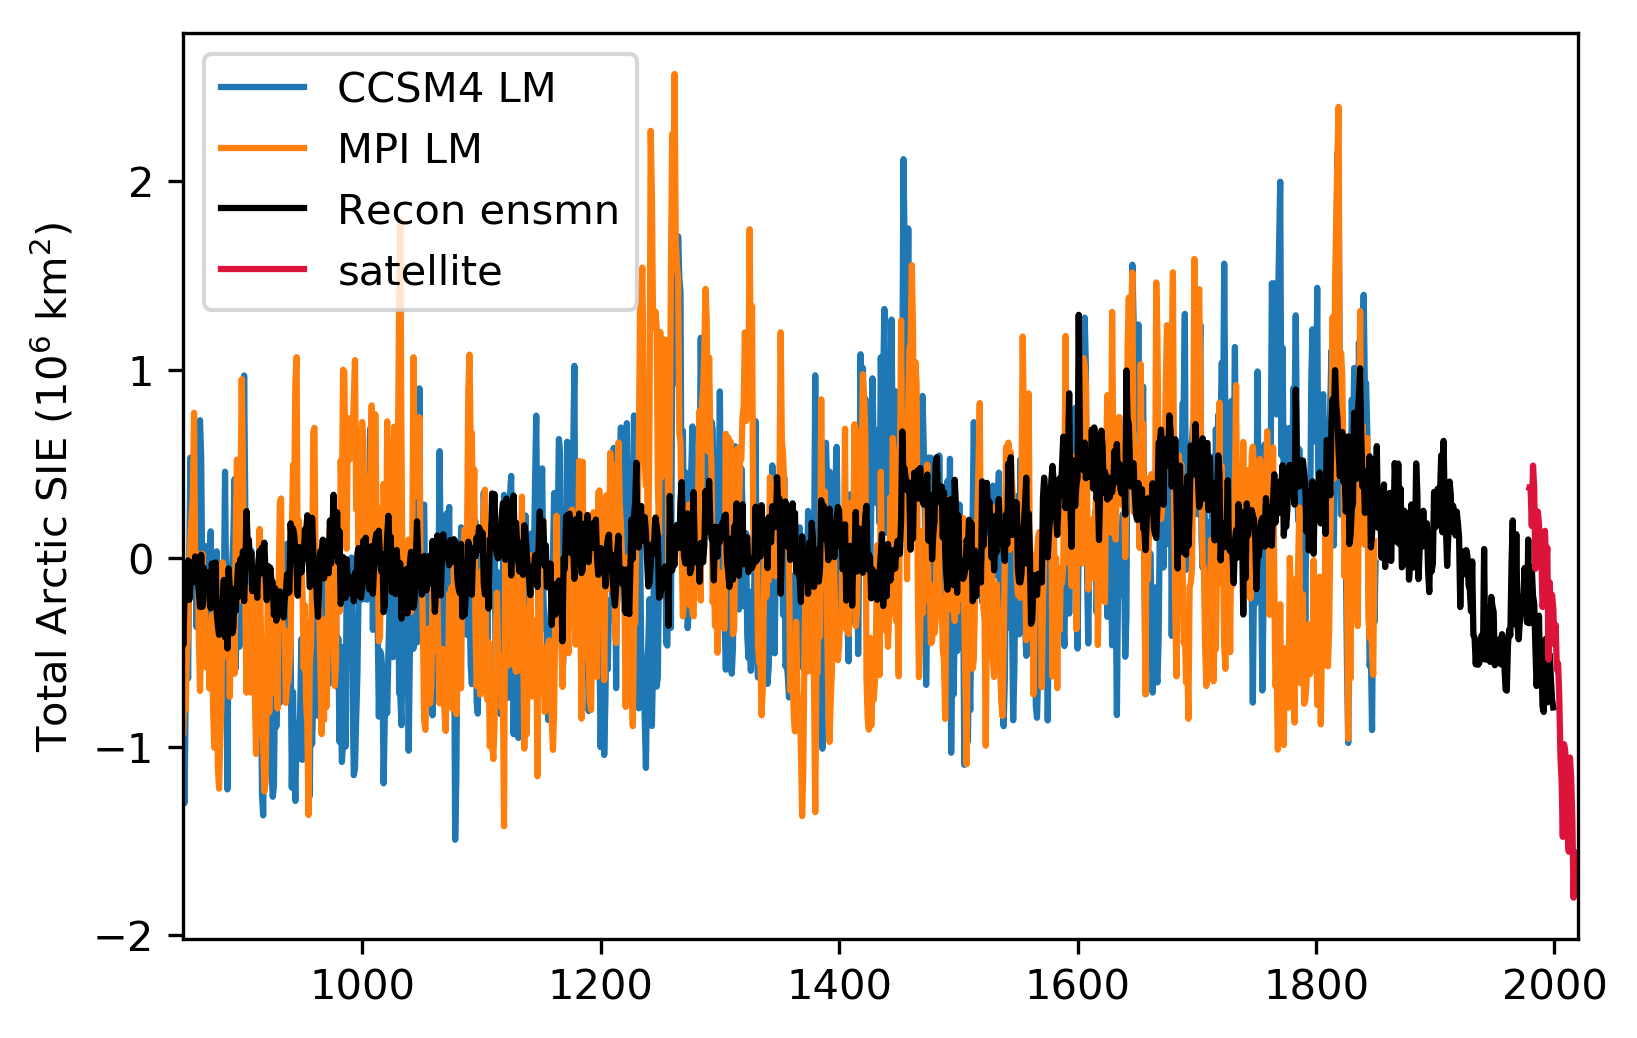

In [21]:
plt.plot(ccsm4_truth_time,sie_nh_ccsm4_truth_anom, label='CCSM4 LM')
plt.plot(mpi_time,sie_nh_mpi_anom, label='MPI LM')

recon_anom = sie_ensmn_anom_allit_ccsm4 - np.nanmean(sie_ensmn_anom_allit_ccsm4,axis=0)

plt.plot(np.array(recon_years_ccsm4),recon_anom, label='Recon ensmn', color='k')
plt.plot(fet_time,fet_sie_anom, color='crimson',label='satellite')

plt.ylabel('Total Arctic SIE (10$^6$ km$^2$)')

plt.xlim(850,2020)
plt.legend()

In [182]:
sie_nh_ccsm4_truth_anom.max() - sie_nh_ccsm4_truth_anom.min()

3.6404941433625595

### Preprocess recons: 

In [18]:
[sie_ens_allit_2d_ccsm4, 
 sie_ens_anom_allit_ccsm4, 
 sie_ensmn_anom_allit_ccsm4, 
 sie_97_5_allit_ccsm4, 
 sie_2_5_allit_ccsm4] = recon_preprocess(sie_ens_allit_ccsm4, np.array(recon_years_ccsm4), anom_start, anom_end)

In [19]:
[sie_ens_allit_2d_ccsm4_test, 
 sie_ens_anom_allit_ccsm4_test, 
 sie_ensmn_anom_allit_ccsm4_test, 
 sie_97_5_allit_ccsm4_test, 
 sie_2_5_allit_ccsm4_test] = recon_preprocess_it(sie_ens_allit_ccsm4, np.array(recon_years_ccsm4), 
                                                 anom_start, anom_end)

var_ensmn, var_anom_mn , var_97_5, var_2_5

In [34]:
var = sie_ens_allit_ccsm4
time = np.array(recon_years_ccsm4)

anom_ind = np.where((time<anom_end)&(time>=anom_start))

var_it_enmn = np.nanmean(var,axis=1)
var_anom_it_enmn = var_it_enmn - np.nanmean(np.squeeze(var_it_enmn[anom_ind,:]),axis=0)
var_anom_ensmn = np.nanmean(var_anom_it_enmn,axis=1)

var_97_5 = np.percentile(var_anom_it_enmn,97.5,axis=1)
var_2_5 = np.percentile(var_anom_it_enmn,2.5,axis=1)

Text(0.5,1,'ensemble mean spread')

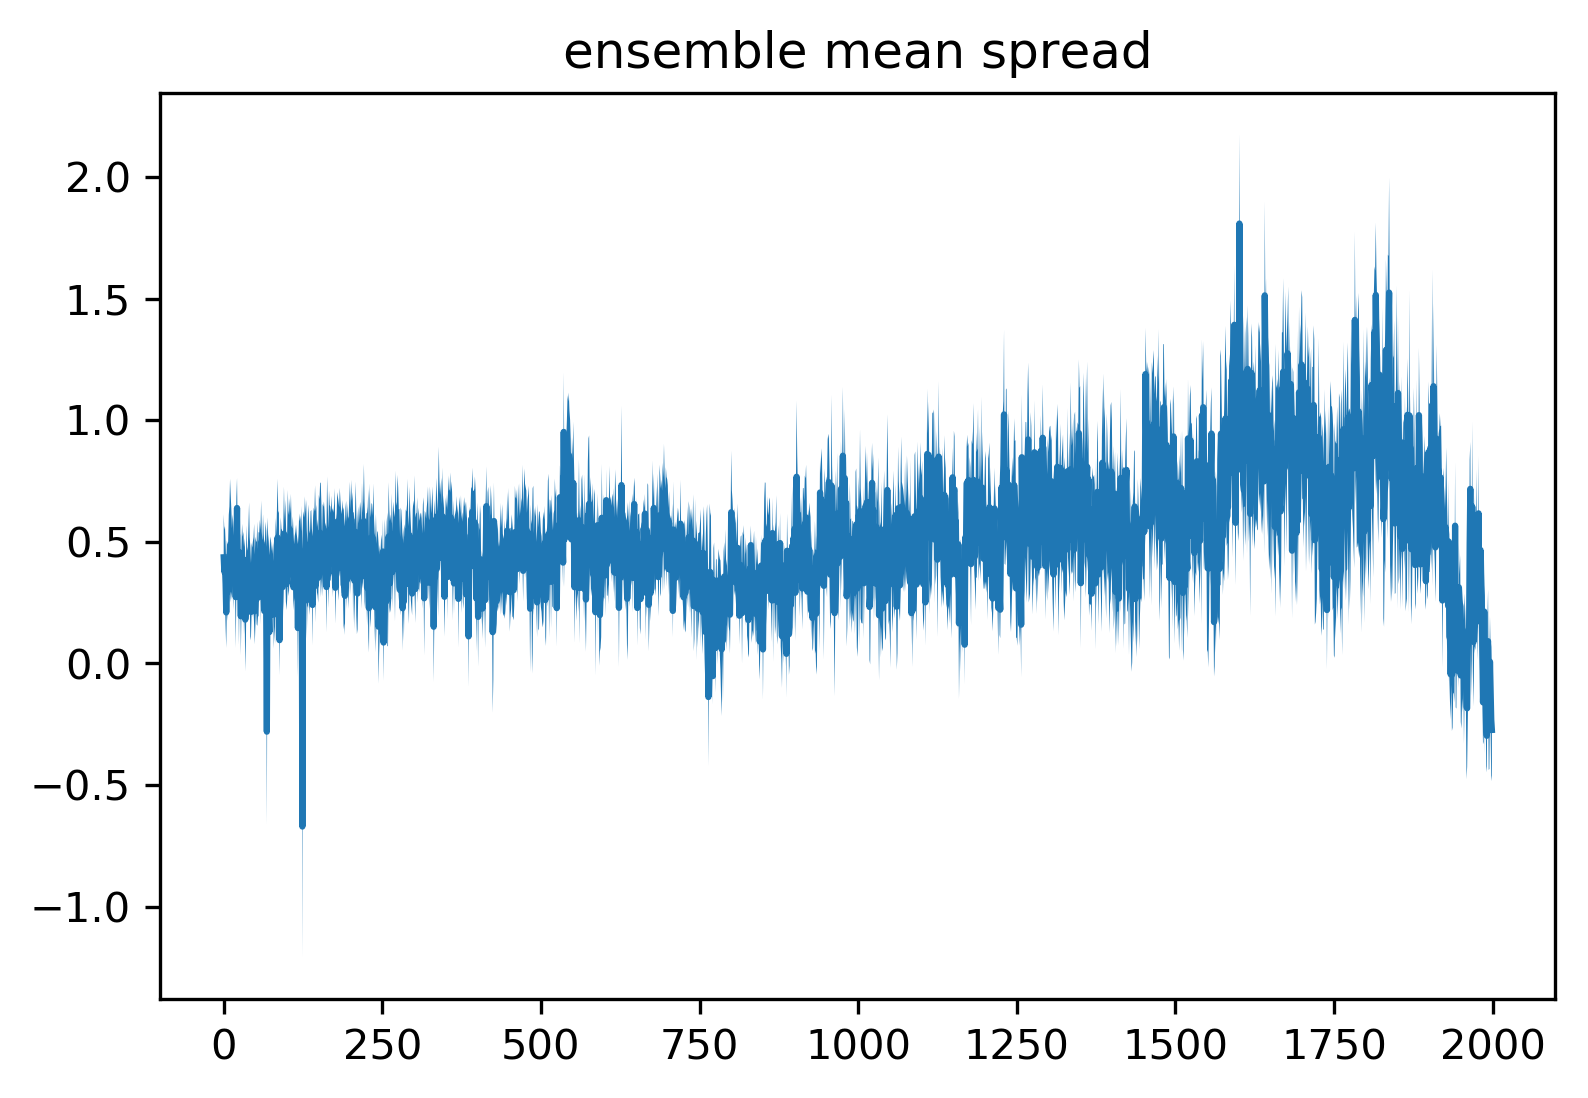

In [37]:
plt.plot(np.array(recon_years_ccsm4),var_anom_ensmn)

plt.fill_between(np.array(recon_years_ccsm4),var_2_5,var_97_5)
plt.title('ensemble mean spread')

(1700, 1800)

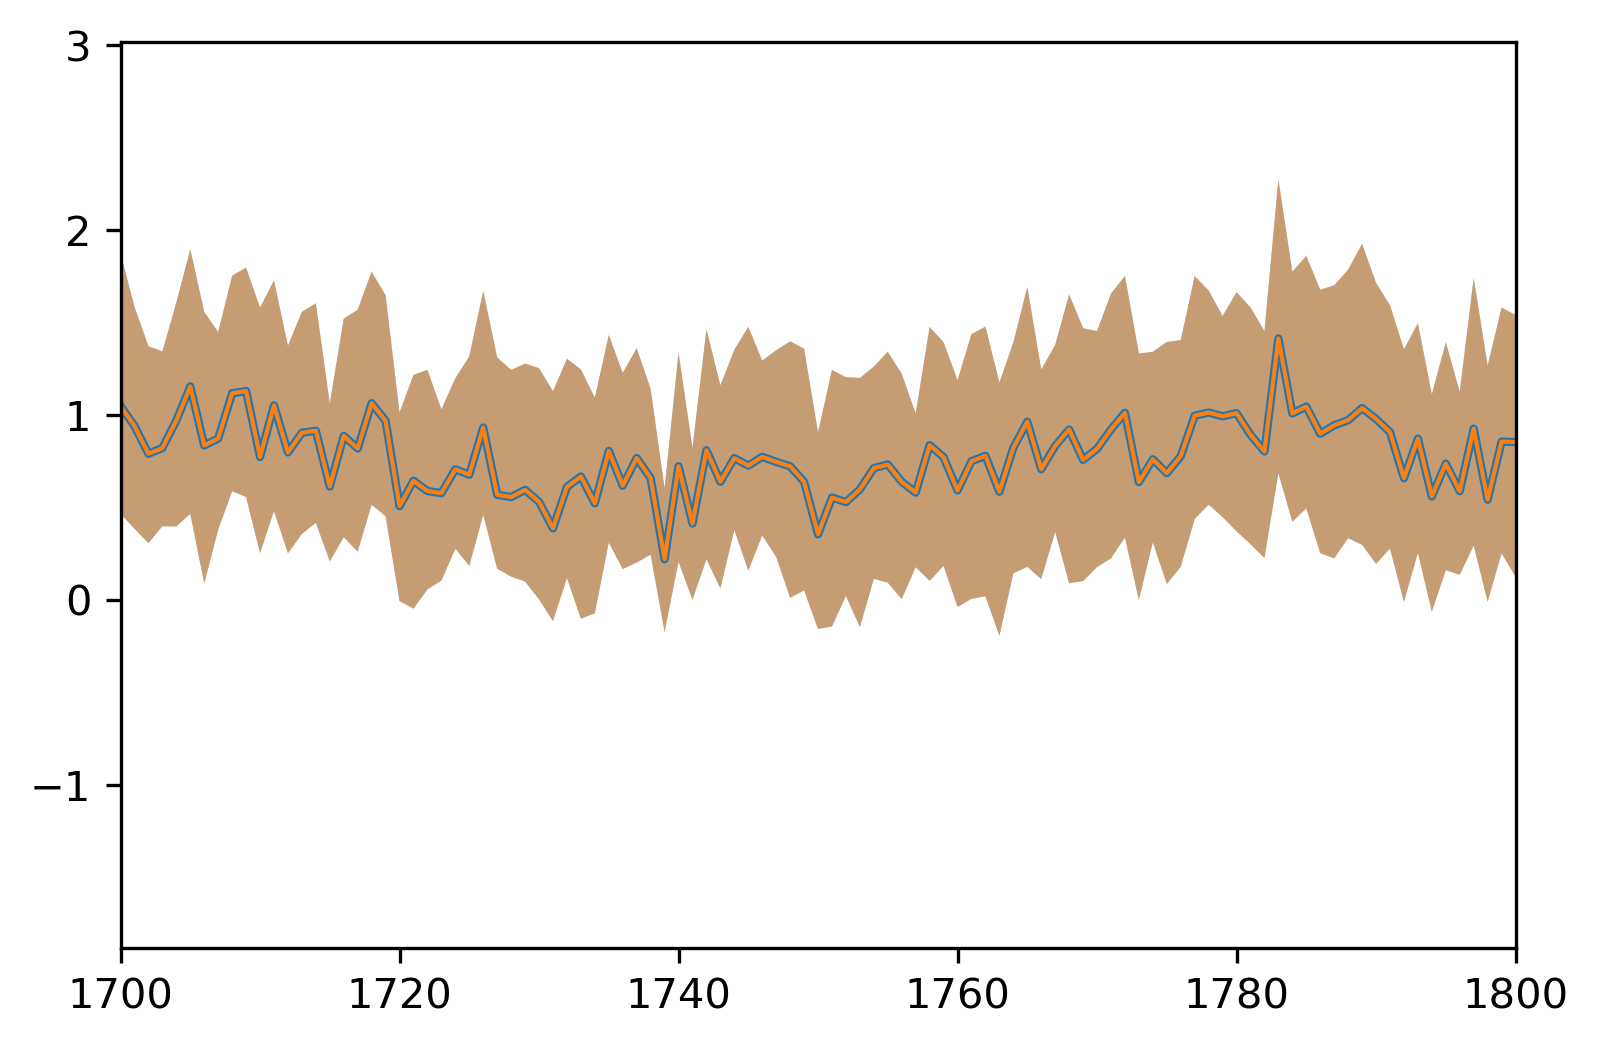

In [82]:
plt.plot(np.array(recon_years_ccsm4),sie_ensmn_anom_allit_ccsm4_test, label='test',linewidth=2)
plt.plot(np.array(recon_years_ccsm4),sie_ensmn_anom_allit_ccsm4, label='original',linewidth=1)

plt.fill_between(np.array(recon_years_ccsm4),sie_2_5_allit_ccsm4_test,sie_97_5_allit_ccsm4_test,alpha=0.5)
plt.fill_between(np.array(recon_years_ccsm4),sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,alpha=0.5)
plt.xlim(1700,1800)

In [60]:
sie_ens_allit_ccsm4.shape

(2000, 200, 10)

In [20]:
[sie_ens_allit_2d_mpi, 
 sie_ens_anom_allit_mpi, 
 sie_ensmn_anom_allit_mpi, 
 sie_97_5_allit_mpi, 
 sie_2_5_allit_mpi] = recon_preprocess(sie_ens_allit_mpi, np.array(recon_years_mpi), anom_start, anom_end)

In [21]:
[sie_ens_allit_2d_f400, 
 sie_ens_anom_allit_f400, 
 sie_ensmn_anom_allit_f400, 
 sie_97_5_allit_f400, 
 sie_2_5_allit_f400] = recon_preprocess(sie_ens_allit_f400, np.array(recon_years_f400), anom_start, anom_end)

In [22]:
[sie_ens_allit_2d_f770, 
 sie_ens_anom_allit_f770, 
 sie_ensmn_anom_allit_f770, 
 sie_97_5_allit_f770, 
 sie_2_5_allit_f770] = recon_preprocess(sie_ens_allit_f770, np.array(recon_years_f770), 1940, 1970)

In [23]:
sie_ens_allit_ccsm4_2d = np.reshape(sie_ens_allit_ccsm4,(sie_ens_allit_ccsm4.shape[0],
                                    sie_ens_allit_ccsm4.shape[1]*sie_ens_allit_ccsm4.shape[2]))
sie_ens_allit_mpi_2d = np.reshape(sie_ens_allit_mpi,(sie_ens_allit_mpi.shape[0],
                                    sie_ens_allit_mpi.shape[1]*sie_ens_allit_mpi.shape[2]))
# sie_ens_allit_f400_2d = np.reshape(sie_ens_allit_f400,(sie_ens_allit_f400.shape[0],
#                                     sie_ens_allit_f400.shape[1]*sie_ens_allit_f400.shape[2]))
# sie_ens_allit_f770_2d = np.reshape(sie_ens_allit_f770,(sie_ens_allit_f770.shape[0],
#                                     sie_ens_allit_f770.shape[1]*sie_ens_allit_f770.shape[2]))

## Variance changes in time?

In [24]:
seg_length = np.arange(10,501,10)
start_year = 1000
end_year = 2000

var_chunked_f1000 = np.ones((seg_length.shape[0],end_year-start_year-10))*np.nan
#var_chunked_full = np.ones((seg_length.shape[0],99))*np.nan

for ln,sln in enumerate(seg_length):
    for s,seg in enumerate(np.arange(start_year,end_year-sln,1)):
#         print(s)
        ind = np.where((np.array(recon_years_ccsm4)>=seg)&(np.array(recon_years_ccsm4)<=seg+sln-1))
        hold = np.var(sie_ensmn_anom_allit_ccsm4[ind])

        var_chunked_f1000[ln,s] = hold

NameError: name 'var_chunked_full' is not defined

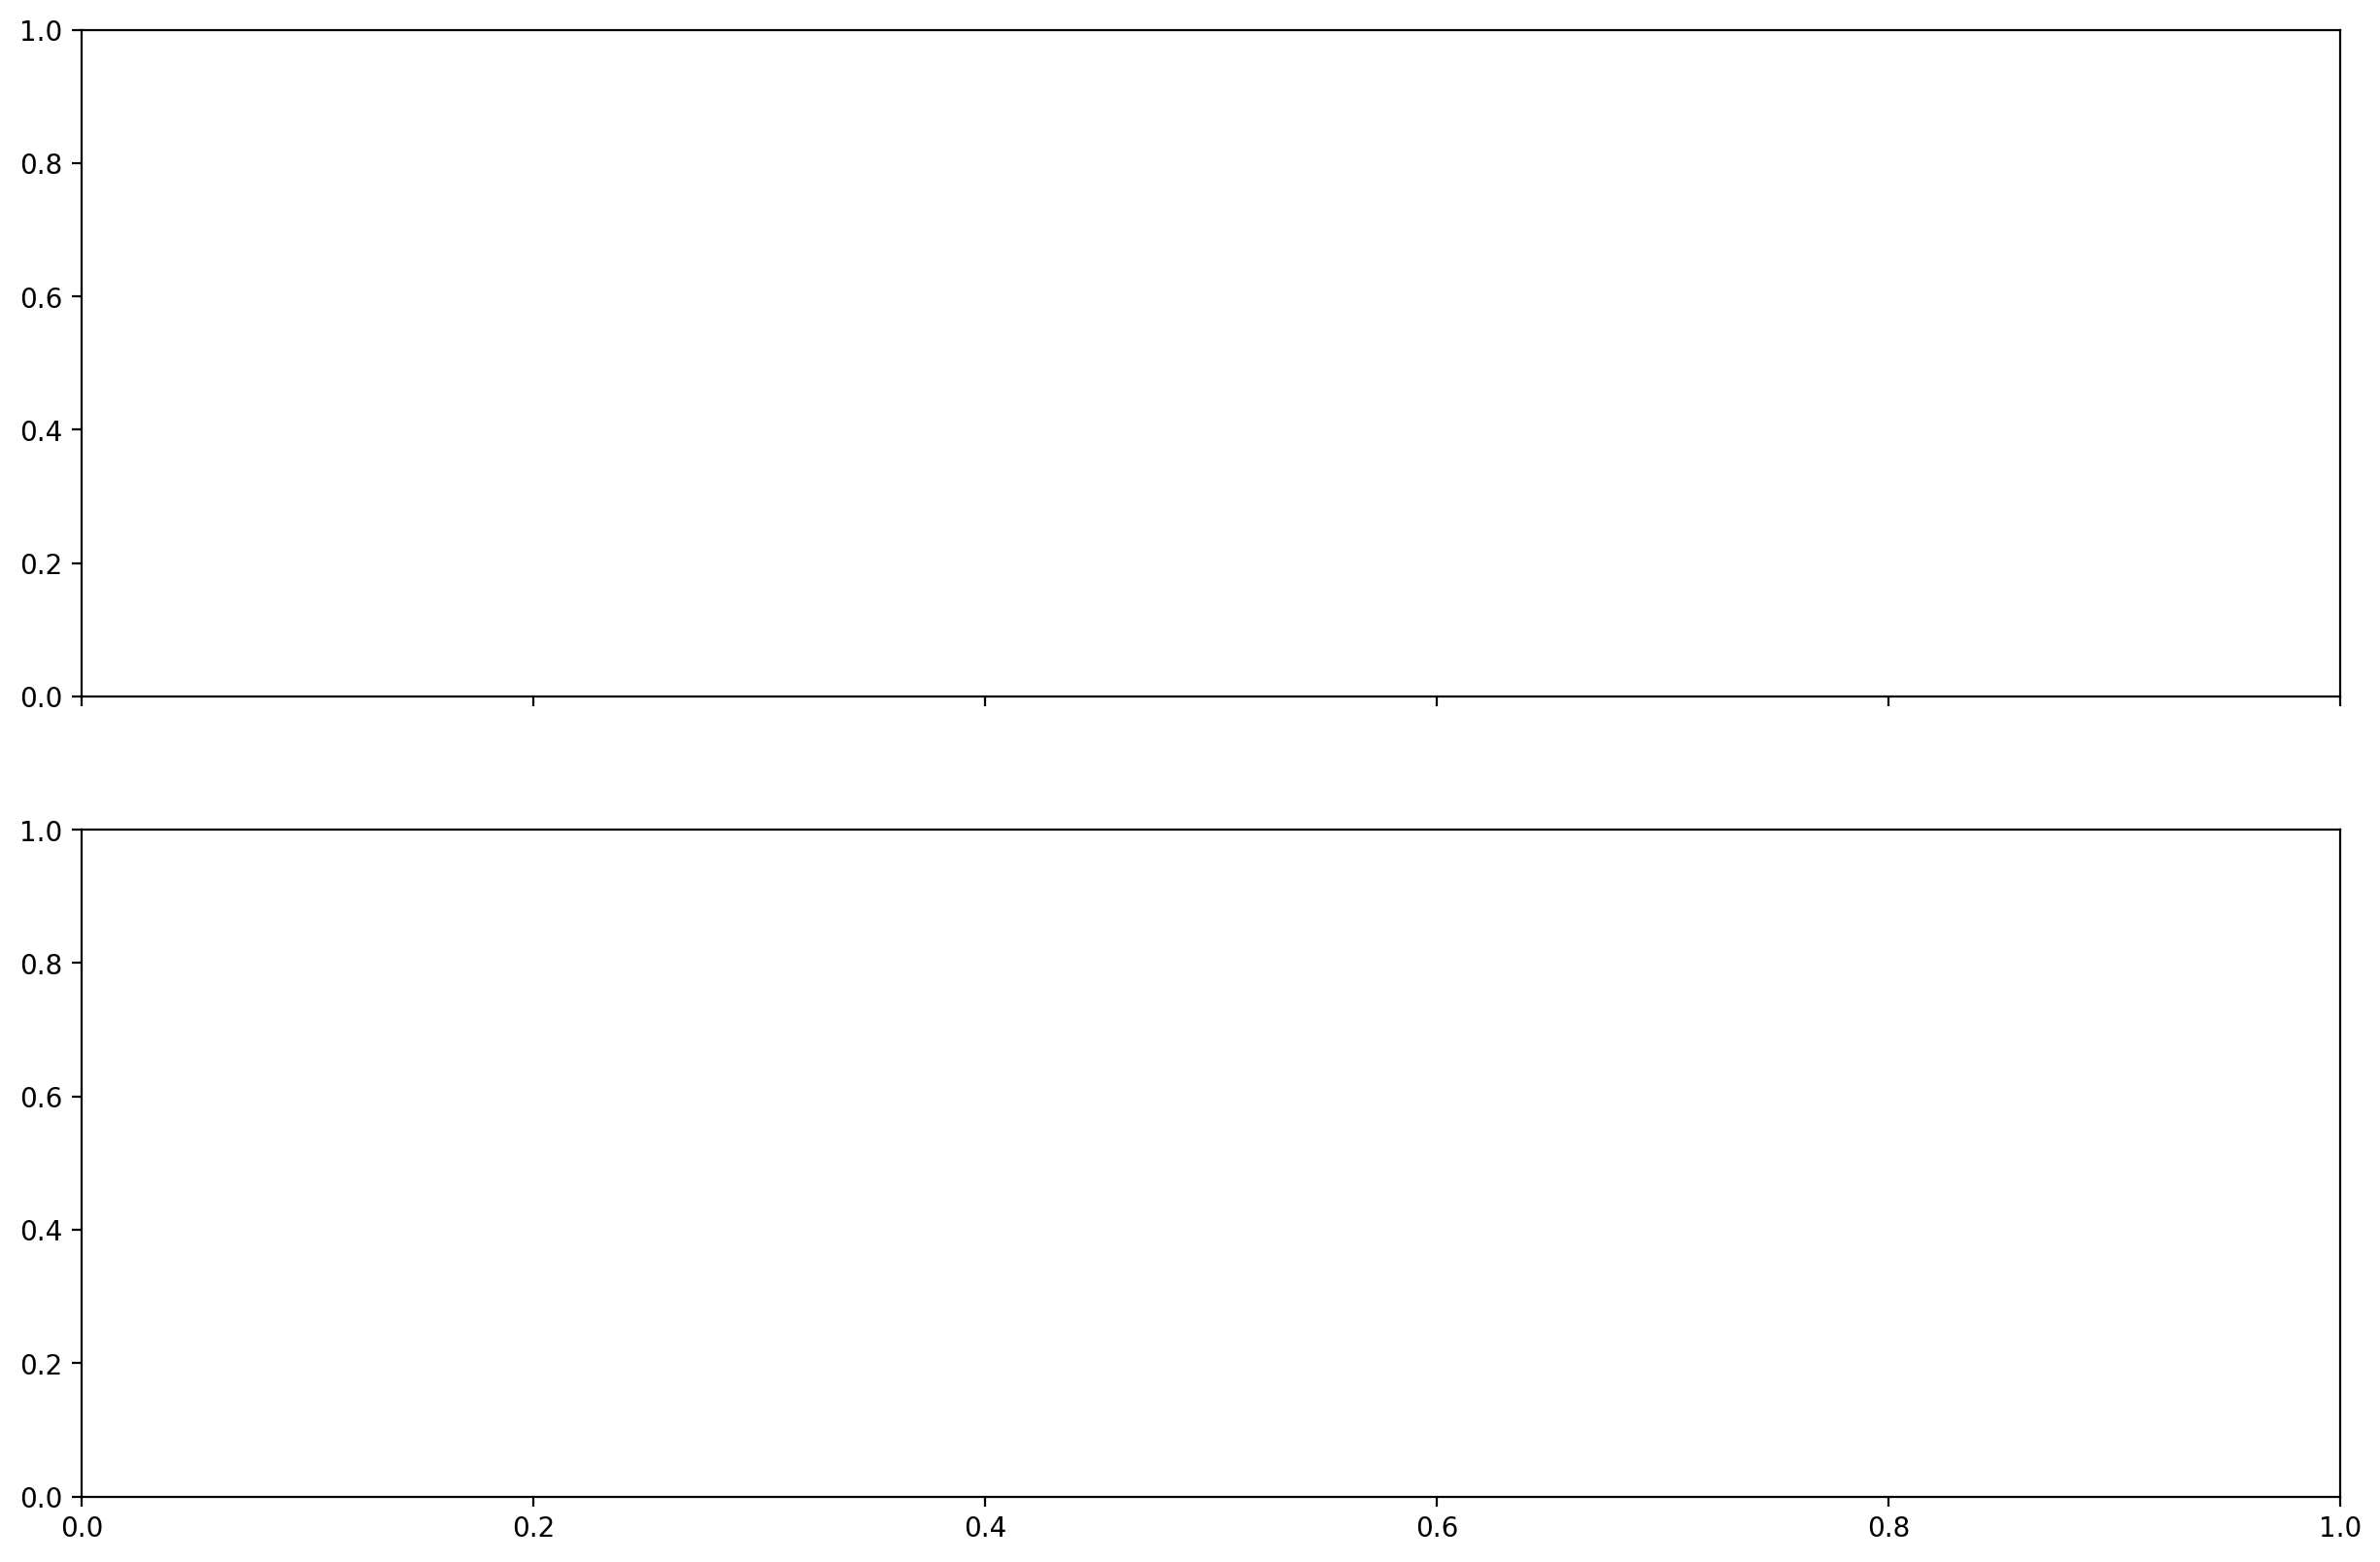

In [25]:
fig, (ax) = plt.subplots(2,1,figsize=(15,10),sharex=True)
ax = ax.flatten()

im = ax[0].pcolormesh(np.arange(var_chunked_full.shape[1]), np.arange(seg_length.shape[0]), 
                      var_chunked_full, cmap='YlGnBu_r')
im2 = ax[1].pcolormesh(np.arange(var_chunked_f1000.shape[1]), np.arange(seg_length.shape[0]), 
                       var_chunked_f1000, cmap='YlGnBu_r')

ax[1].set_yticks(np.arange(0.5,seg_length.shape[0],5))
ax[0].set_yticks(np.arange(0.5,seg_length.shape[0],5))
ax[1].set_yticklabels(np.arange(10,500,50))
ax[0].set_yticklabels(np.arange(10,500,50))

ax[1].set_xticks(np.arange(0,var_chunked_full.shape[1],100))
ax[0].set_xticks(np.arange(0,var_chunked_full.shape[1],100))
ax[1].set_xticklabels(np.arange(start_year,end_year-10,100))
ax[0].set_xticklabels(np.arange(start_year,end_year-10,100))

ax[1].invert_yaxis()
ax[0].invert_yaxis()

ax[1].set_xlabel('Start year',fontsize=14)
ax[0].set_ylabel('Window length (years)',fontsize=14)
ax[1].set_ylabel('Window length (years)',fontsize=14)
#plt.ylim(0,5)

ax[1].set_title('Fixed proxy experiment (101 proxies)',fontsize=14)
ax[0].set_title('Full reconstruction',fontsize=14)

position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label('Variance (10$^6$ km$^2$)$^2$)', fontsize=14)

plt.tight_layout()

## Scramble ensemble members 

In [22]:
import random

In [23]:
sie_ens_allit_ccsm4_2d.shape, sie_ens_allit_ccsm4.shape

NameError: name 'sie_ens_allit_ccsm4_2d' is not defined

In [26]:
sie_ensmn_allmit_ccsm4 = np.nanmean(sie_ens_allit_ccsm4,axis=1)[:,np.newaxis,:]
sie_ensmn_allmit_mpi = np.nanmean(sie_ens_allit_ccsm4,axis=1)[:,np.newaxis,:]

sie_perturbs_allit_ccsm4 = sie_ens_allit_ccsm4 - sie_ensmn_allmit_ccsm4
sie_perturbs_allit_mpi = sie_ens_allit_mpi - sie_ensmn_allmit_mpi

sie_ens_allit_ccsm4_scrambled = np.zeros((2000,2000,10))
sie_ens_allit_mpi_scrambled = np.zeros((2000,2000,10))

for mit in range(10):
    print('iteration '+str(mit))
    for y in range(2000):
        randomlist = [random.randint(0,199) for x in range(2000)]
        for i,rint in enumerate(randomlist):        
            sie_ens_allit_ccsm4_scrambled[y,i,mit] = sie_ensmn_allmit_ccsm4[y,0,mit]+sie_perturbs_allit_ccsm4[y,rint,mit]
            sie_ens_allit_mpi_scrambled[y,i,mit] = sie_ensmn_allmit_mpi[y,0,mit]+sie_perturbs_allit_mpi[y,rint,mit]

#         sie_ens_anom_allit_ccsm4_scrambled[y,:] = sie_ens_anom_allit_ccsm4[y,randomlist]
#         sie_ens_anom_allit_mpi_scrambled[y,:] = sie_ens_anom_allit_mpi[y,randomlist]

(2000, 200, 10)

In [84]:
sie_ens_allit_ccsm4.shape

(2000, 200, 10)

In [162]:
ndraws = 500
sie_ens_allit_ccsm4_scrambled = np.zeros((2000,ndraws,10))
sie_ens_allit_mpi_scrambled = np.zeros((2000,ndraws,10))
rlist = np.zeros((2000,ndraws,10))

for mit in range(10):
    print('iteration '+str(mit))
    for y in range(2000):
        randomlist = [random.randint(0,199) for x in range(ndraws)]    
        sie_ens_allit_ccsm4_scrambled[y,:,mit] = sie_ens_allit_ccsm4[y,randomlist,mit]
        sie_ens_allit_mpi_scrambled[y,:,mit] = sie_ens_allit_mpi[y,randomlist,mit]
        rlist[y,:,mit] = np.array(randomlist)

#         sie_ens_anom_allit_ccsm4_scrambled[y,:] = sie_ens_anom_allit_ccsm4[y,randomlist]
#         sie_ens_anom_allit_mpi_scrambled[y,:] = sie_ens_anom_allit_mpi[y,randomlist]

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [161]:
sie_ens_allit_ccsm4_scrambled.shape, sie_ens_allit_ccsm4.shape

((2000, 500, 10), (2000, 200, 10))

In [132]:
# # 200 member draws 
# sie_ens_allit_ccsm4_scrambled = np.zeros((2000,2000,10))
# sie_ens_allit_mpi_scrambled = np.zeros((2000,2000,10))

# for mit in range(10):
#     for y in range(2000):
#         randomlist = random.sample(range(0, 200), 2000)
        
#         sie_ens_allit_ccsm4_scrambled[y,:,mit] = sie_ensmn_allmit_ccsm4[y,0,mit]+sie_perturbs_allit_ccsm4[y,randomlist,mit]
#         sie_ens_allit_mpi_scrambled[y,:,mit] = sie_ensmn_allmit_mpi[y,0,mit]+sie_perturbs_allit_mpi[y,randomlist,mit]

# #         sie_ens_anom_allit_ccsm4_scrambled[y,:] = sie_ens_anom_allit_ccsm4[y,randomlist]
# #         sie_ens_anom_allit_mpi_scrambled[y,:] = sie_ens_anom_allit_mpi[y,randomlist]

IndexError: index 200 is out of bounds for axis 1 with size 200

Text(0.5,1,'Ensemble mean - 10 iterations')

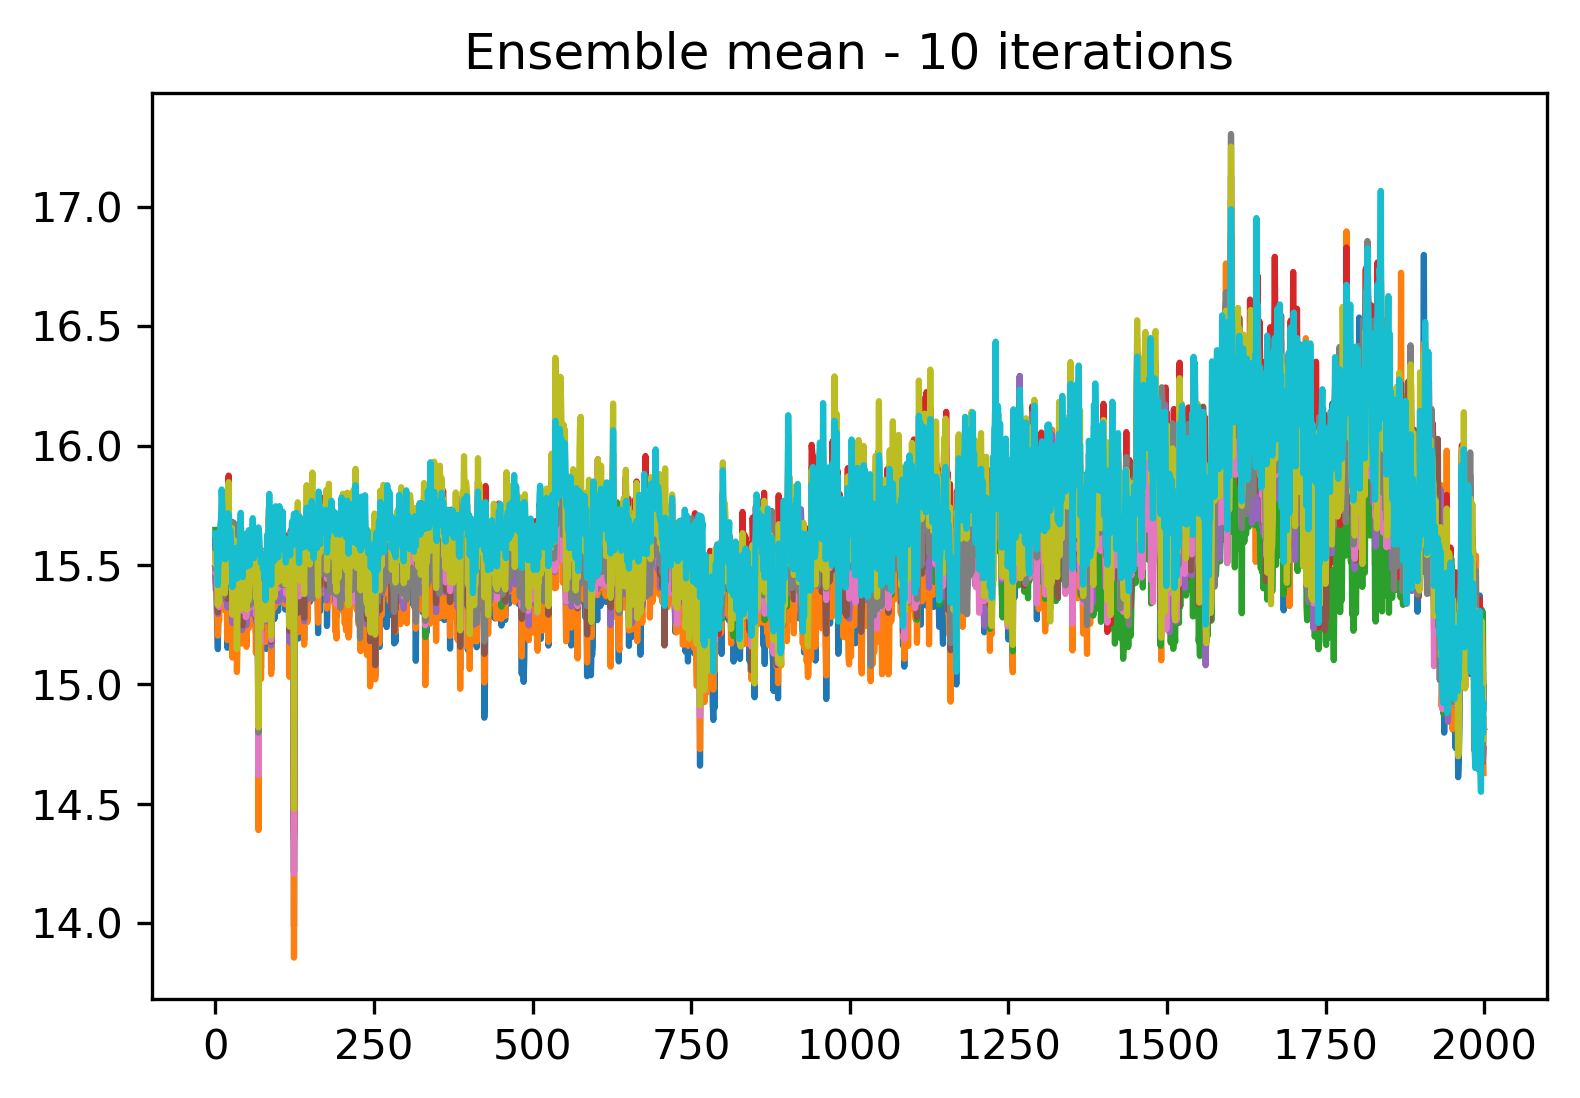

In [28]:
plt.plot(sie_ensmn_allmit_ccsm4[:,0,:])
plt.title('Ensemble mean - 10 iterations')

Text(0.5,1,'Full values: 10 ensemble members -1st monte iterations')

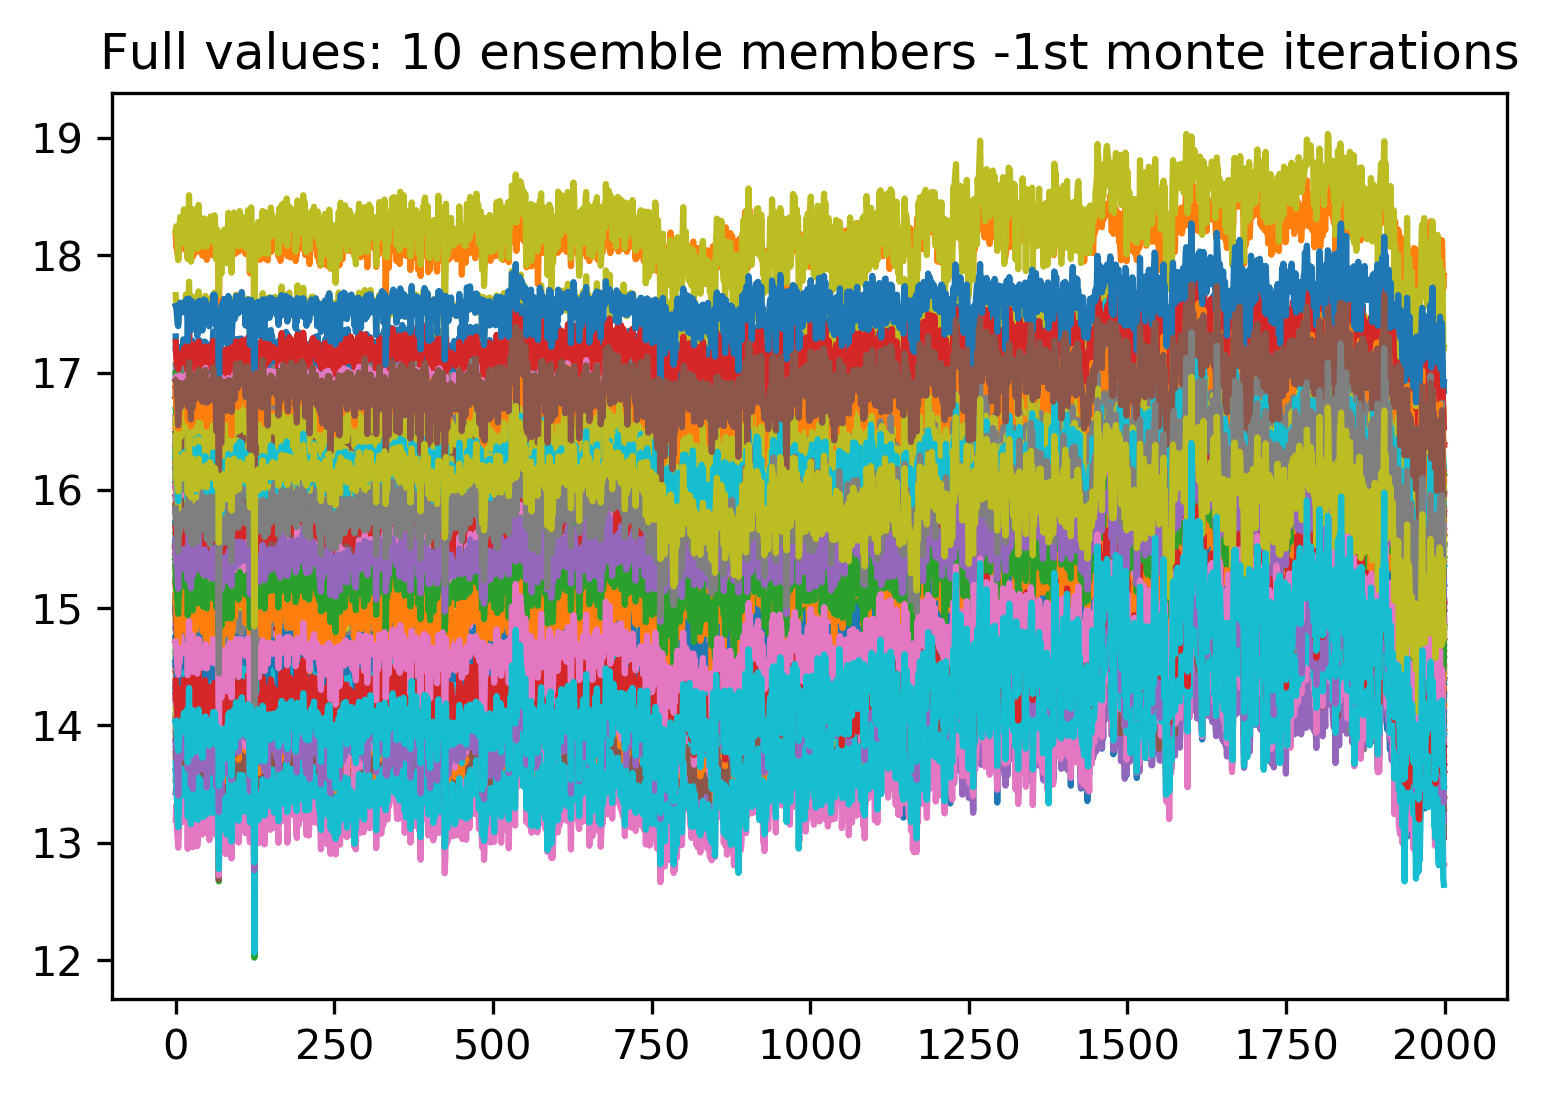

In [26]:
plt.plot(sie_ens_allit_ccsm4[:,:,0])
plt.title('Full values: 10 ensemble members -1st monte iterations')

(-1.5, 2.0)

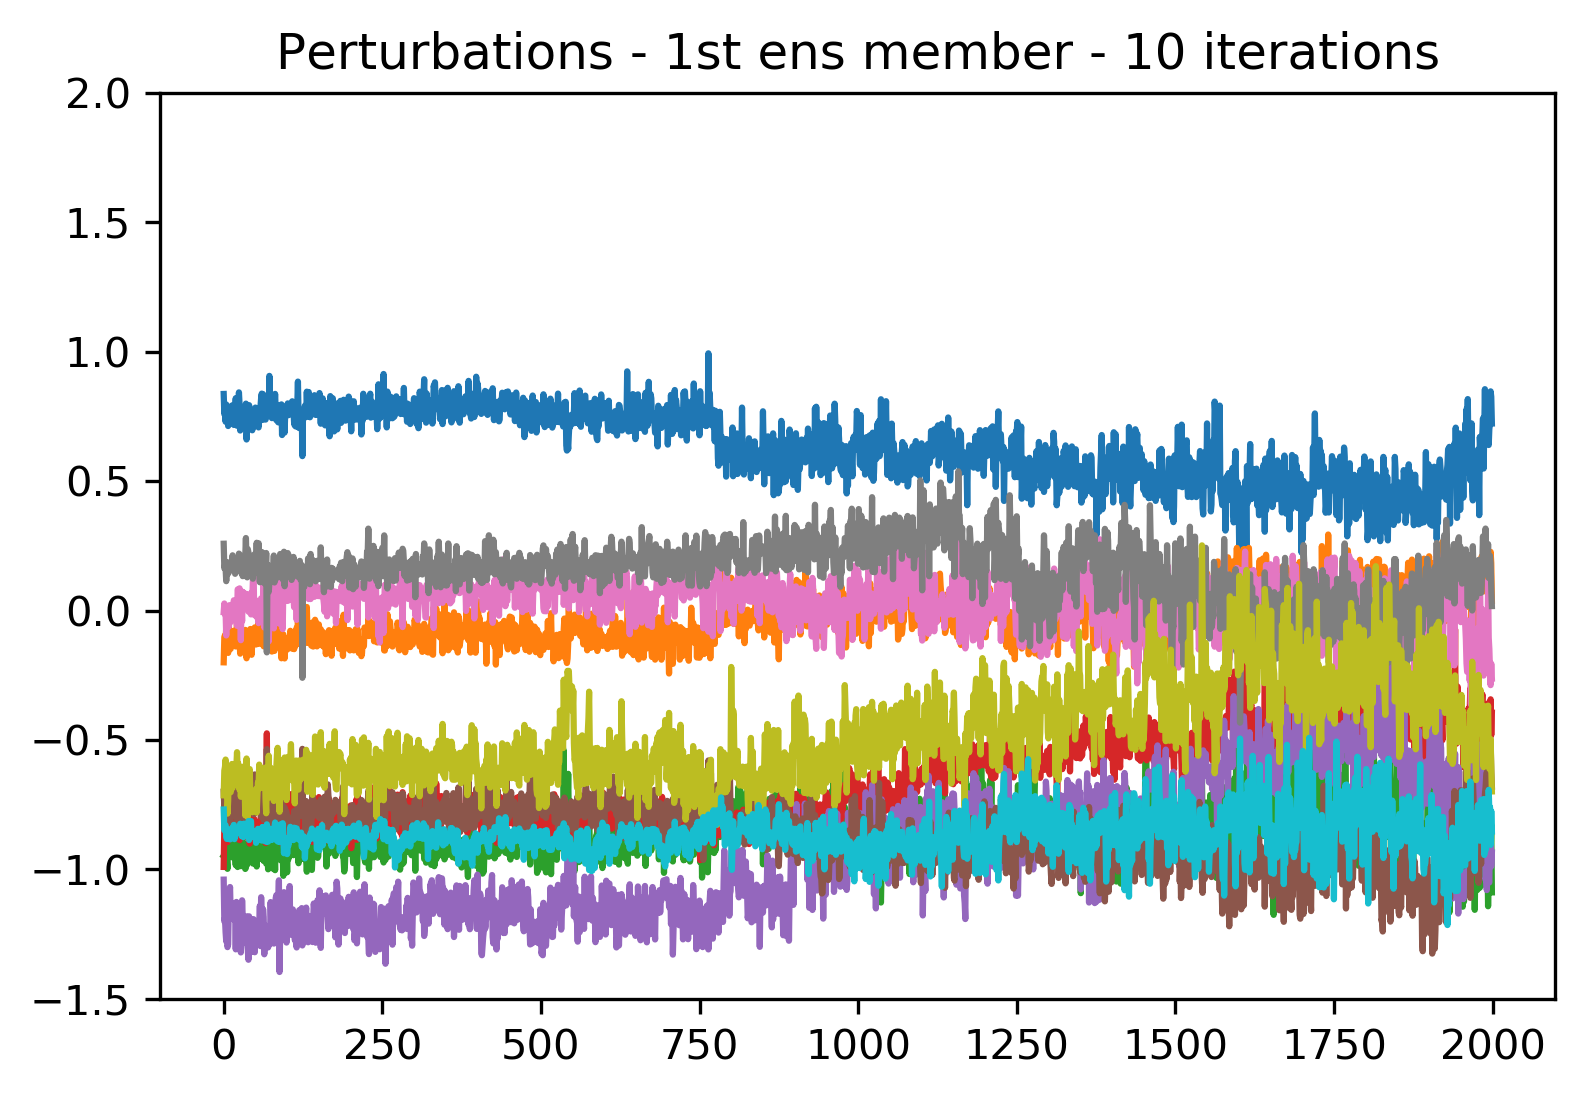

In [31]:
plt.plot(sie_perturbs_allit_ccsm4[:,0,:])
plt.title('Perturbations - 1st ens member - 10 iterations')
plt.ylim(-1.5,2.0)

(-1.5, 2.0)

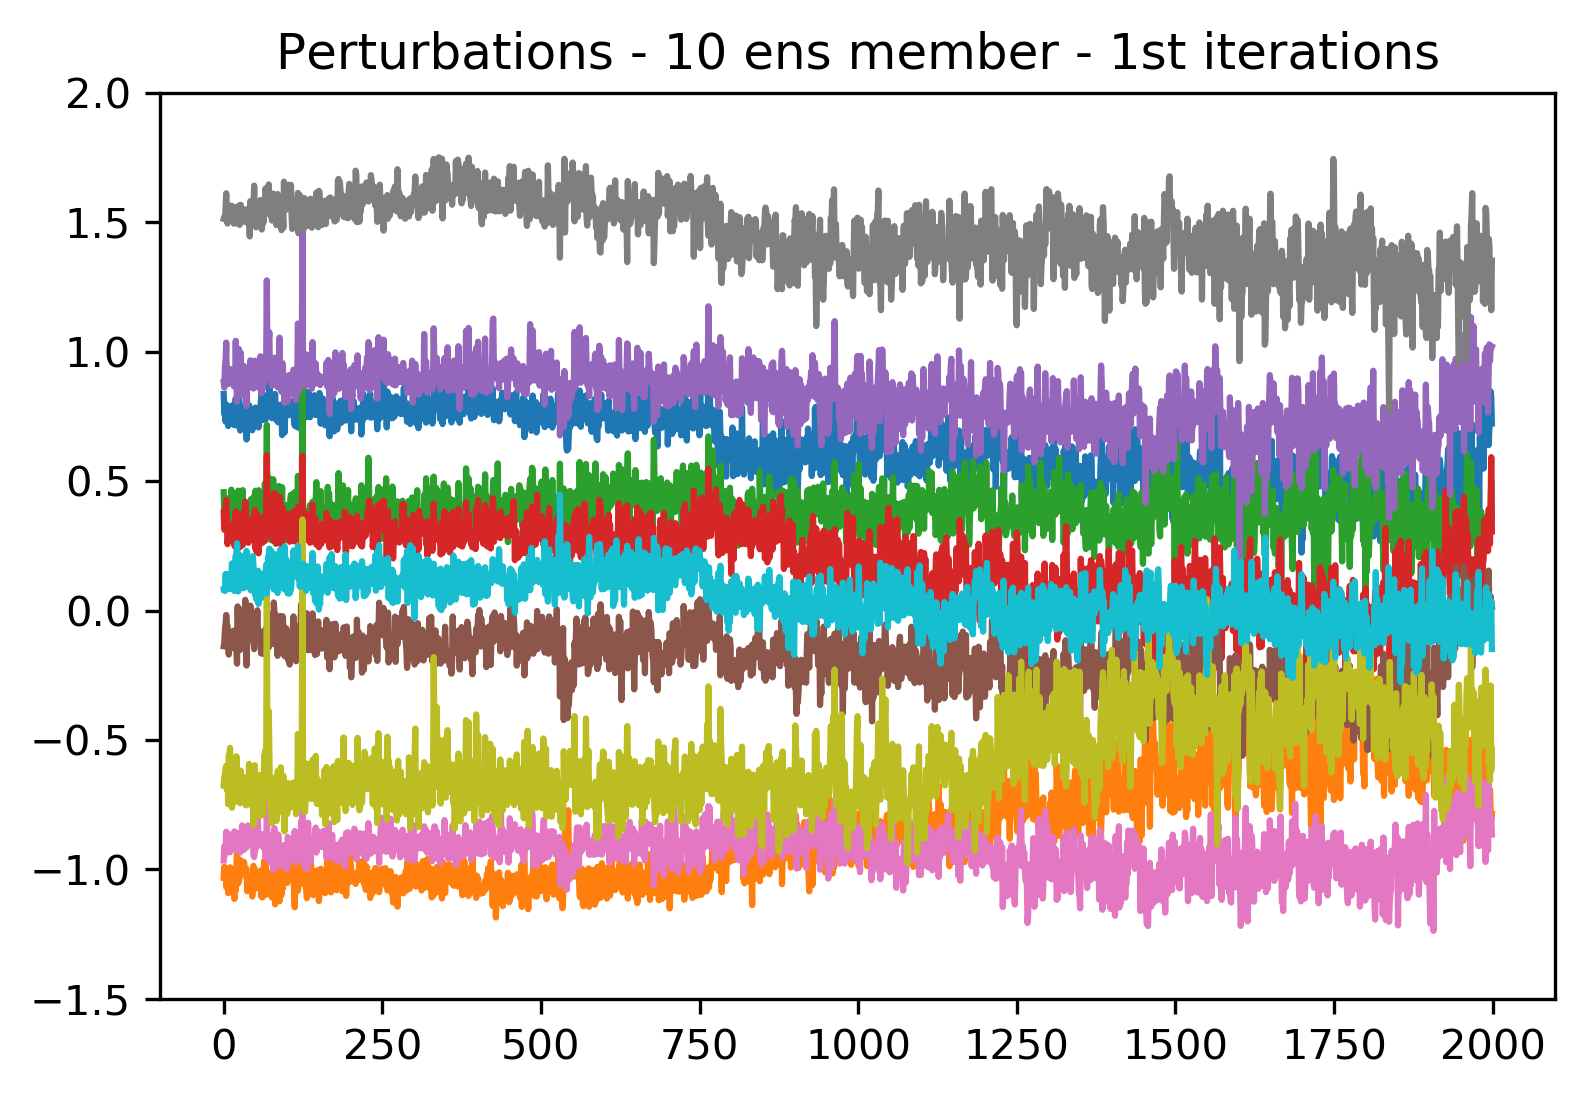

In [30]:
plt.plot(sie_perturbs_allit_ccsm4[:,0:10,0])
plt.title('Perturbations - 10 ens member - 1st iterations')
plt.ylim(-1.5,2.0)

In [32]:
sie_perturbs_allit_ccsm4.shape, sie_ensmn_allmit_ccsm4.shape

((2000, 200, 10), (2000, 1, 10))

In [188]:
sie_mn_ens = np.nanmean(sie_ens_allit_ccsm4,axis=0)
np.max(sie_mn_ens,axis=0) - np.min(sie_mn_ens,axis=0)

array([4.64370936, 4.14433138, 4.61615617, 4.80223845, 4.54597486,
       4.47949696, 4.82539783, 4.78825317, 4.7944632 , 4.81993897])

No handles with labels found to put in legend.


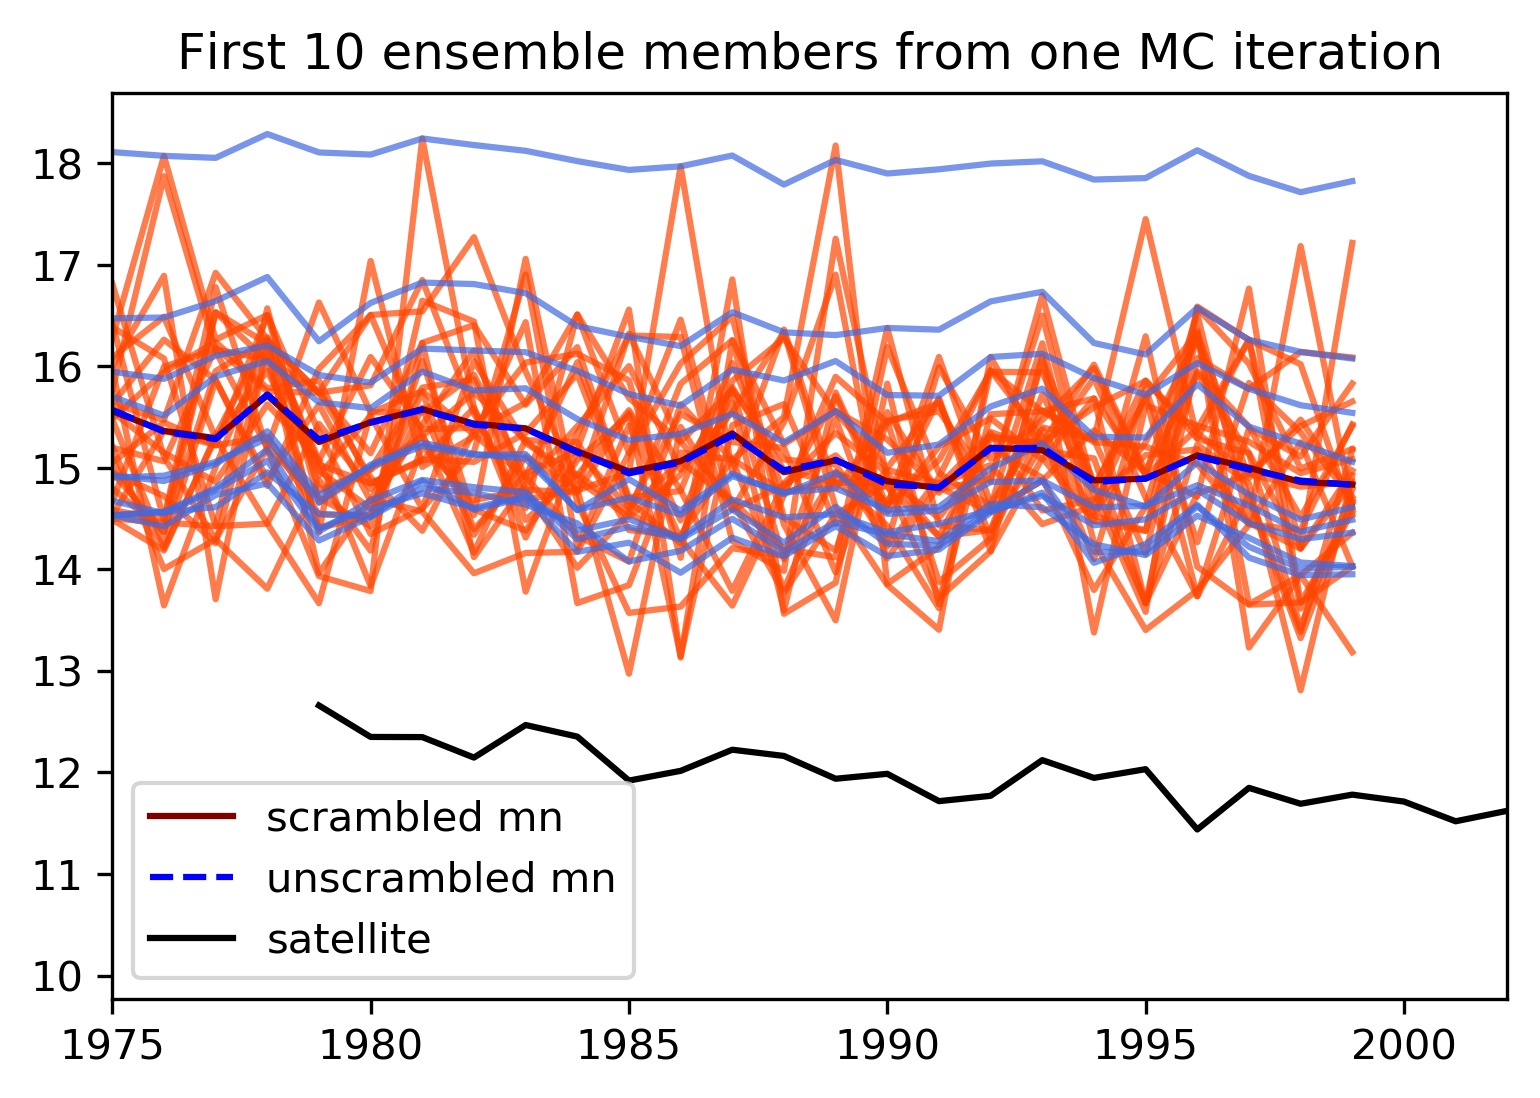

In [147]:
plt.plot(np.arange(1975,2000,1),sie_ens_allit_ccsm4_scrambled[1975:,1::20,0],color='orangered',alpha=0.7)
plt.plot(np.arange(1975,2000,1),sie_ens_allit_ccsm4[1975:,1::20,0],color='royalblue',alpha=0.7)
plt.legend()

plt.plot(np.arange(1975,2000,1),np.nanmean(np.nanmean(sie_ens_allit_ccsm4_scrambled[1975:,:,:],axis=1),axis=1),
         color='maroon',label='scrambled mn')
plt.plot(np.arange(1975,2000,1),np.nanmean(np.nanmean(sie_ens_allit_ccsm4[1975:,:,:],axis=1),axis=1),
         color='b',label='unscrambled mn', linestyle='--')
plt.plot(fet_time, fet_sie[:-1], label='satellite', color='k')

plt.xlim(1975,2002)

plt.title('First 10 ensemble members from one MC iteration')
plt.legend()

In [225]:
sie_ens_allit_ccsm4_scrambled.shape

(2000, 2000, 10)

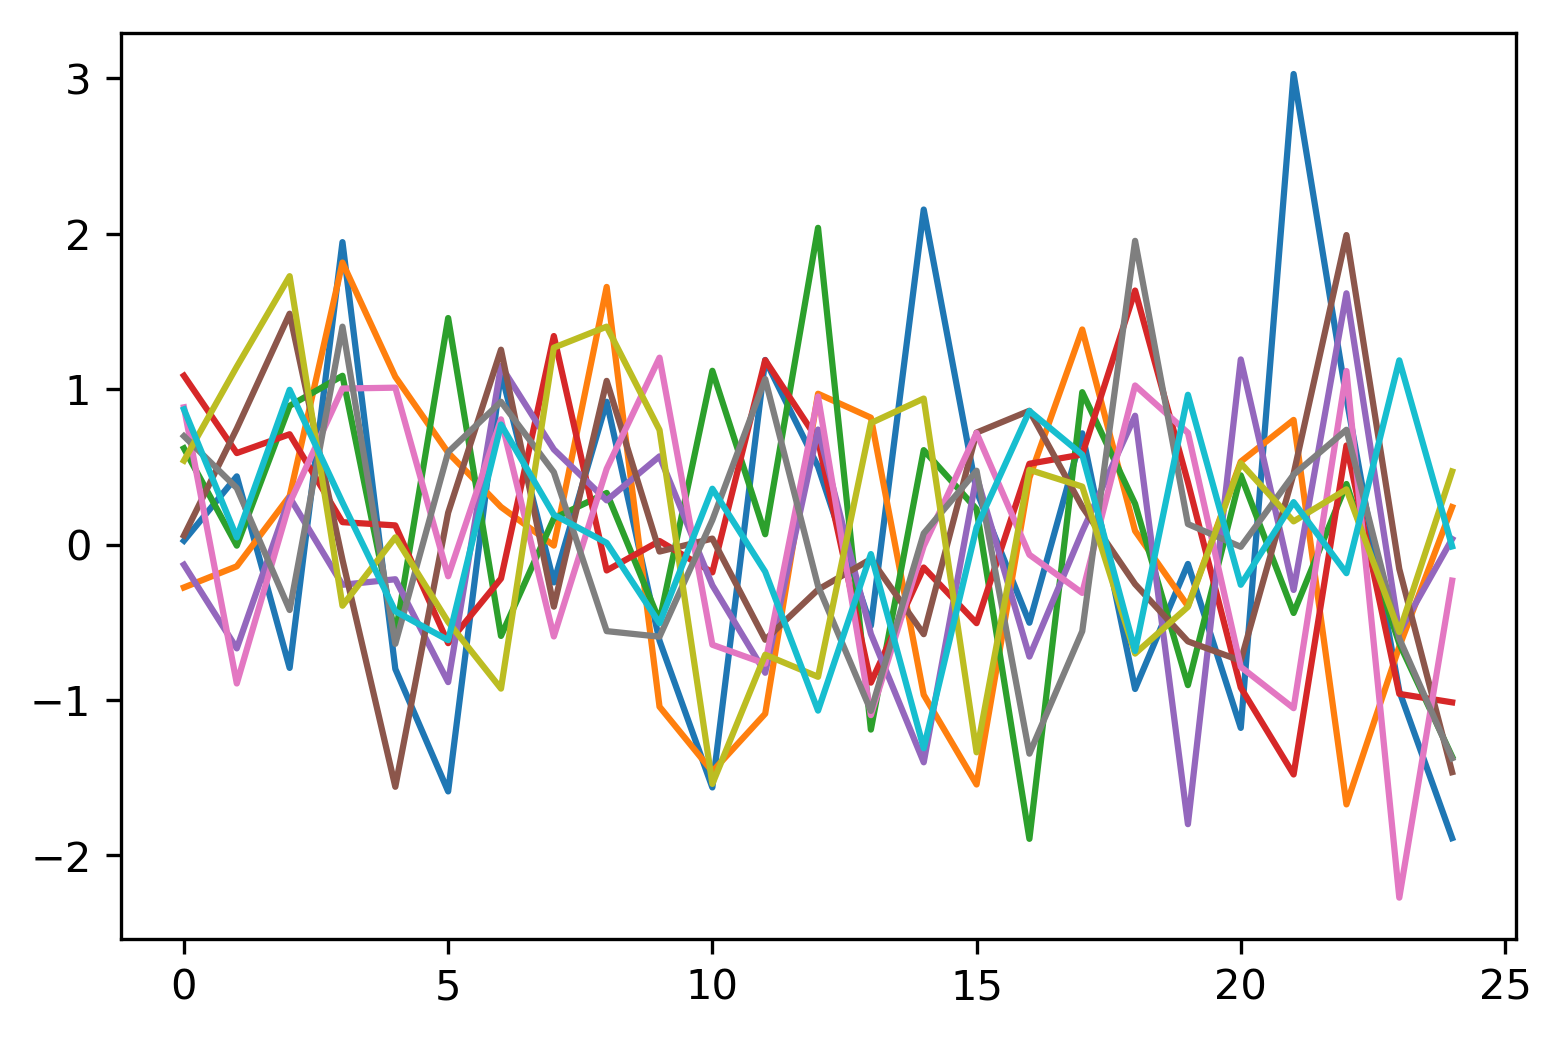

In [36]:
mn = np.nanmean(np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,20000))[1979:2000,:],axis=0)
mn_2d = np.reshape(mn,(2000,10))
sie_anom = sie_ens_allit_ccsm4_scrambled - mn_2d
plt.plot(sie_anom[1975:,0:10,0])

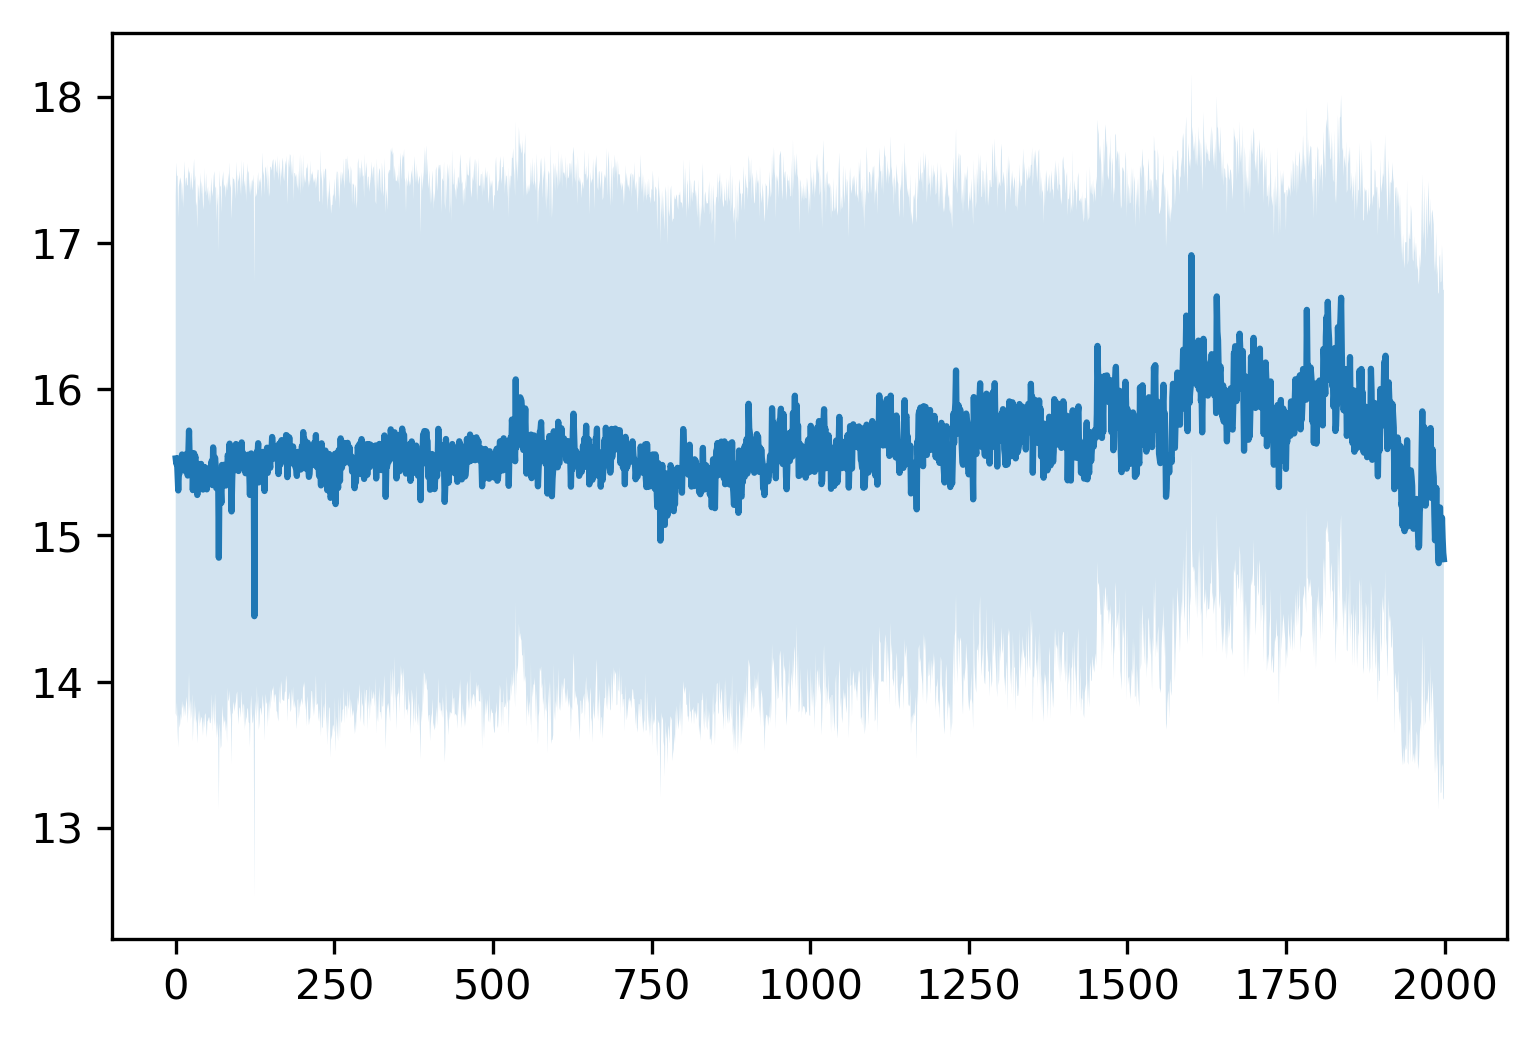

In [94]:
var_97_5 = np.percentile(np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,2000)),97.5,axis=1)
var_2_5 = np.percentile(np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,2000)),2.5,axis=1)

plt.plot(np.nanmean(np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,2000)),axis=1))
plt.fill_between(np.arange(0,2000,1),var_2_5,var_97_5,alpha=0.2)


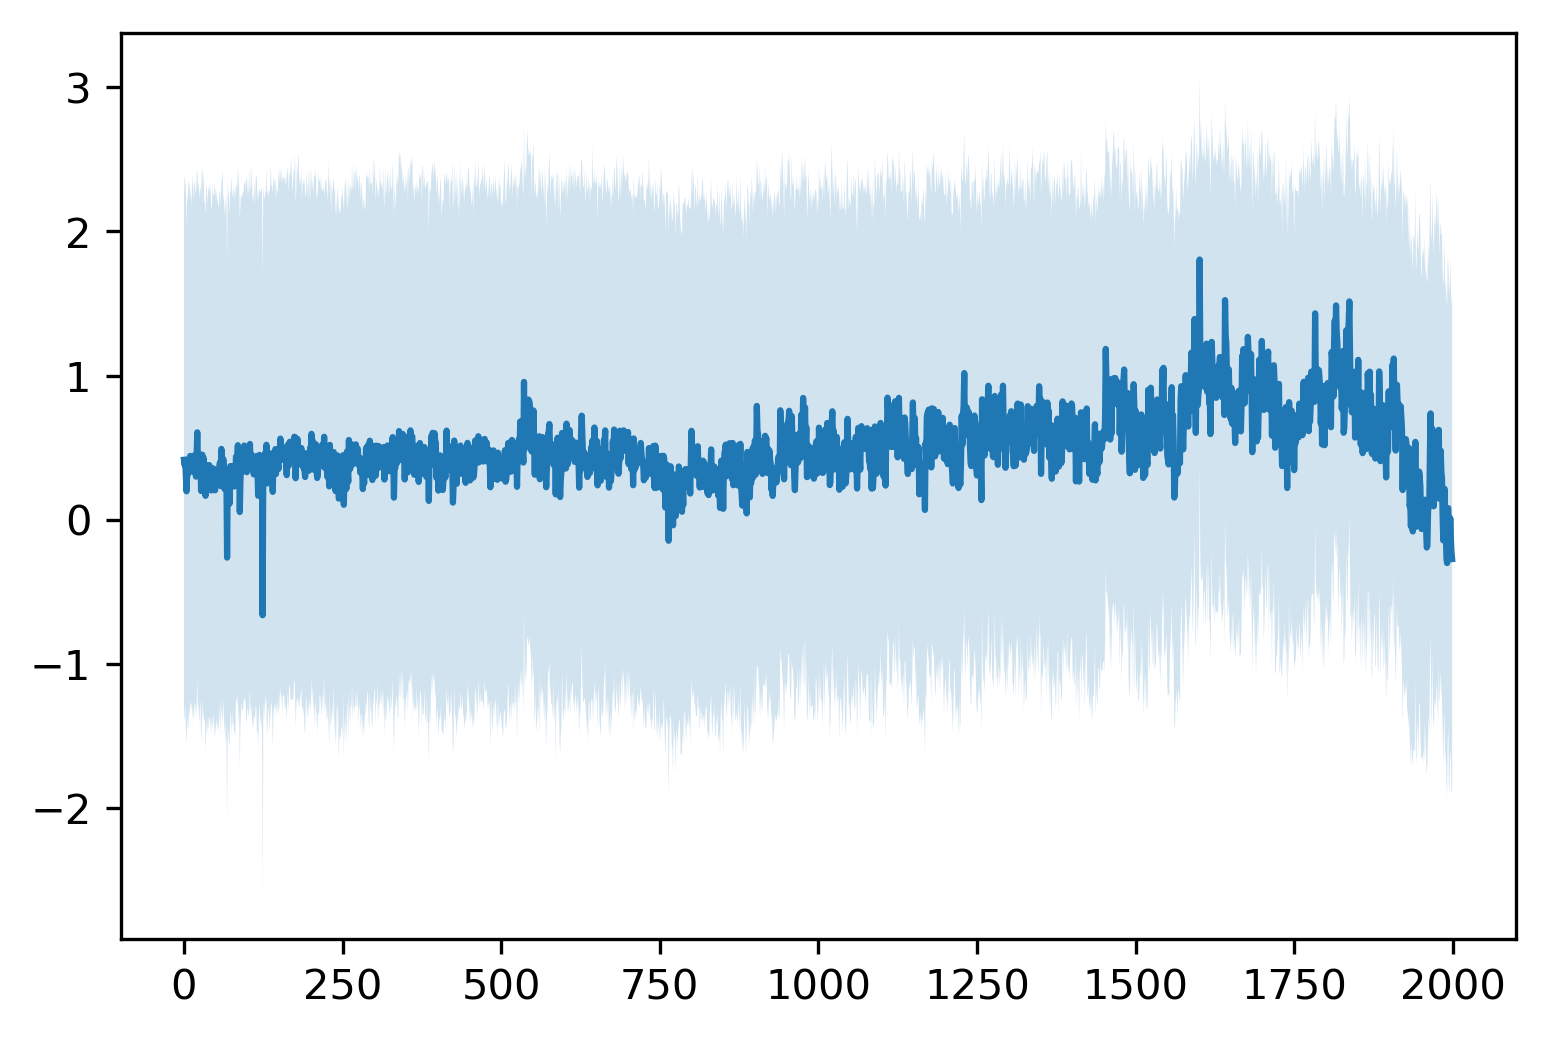

In [98]:
a = np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,2000))
sie_ens_allit_anom_ccsm4_scrambled = a - np.nanmean(a[1979:2000,:],axis=0)

var_97_5 = np.percentile(np.reshape(sie_ens_allit_anom_ccsm4_scrambled,(2000,2000)),97.5,axis=1)
var_2_5 = np.percentile(np.reshape(sie_ens_allit_anom_ccsm4_scrambled,(2000,2000)),2.5,axis=1)

plt.plot(np.nanmean(np.reshape(sie_ens_allit_anom_ccsm4_scrambled,(2000,2000)),axis=1))
plt.fill_between(np.arange(0,2000,1),var_2_5,var_97_5,alpha=0.2)

In [39]:
ensmn_test = np.nanmean(np.reshape(sie_ens_anom_allit_ccsm4_scrambled,(2000,2000)),axis=1)
sie_ens_allit_ccsm4_2d.shape

NameError: name 'sie_ens_anom_allit_ccsm4_scrambled' is not defined

(0, 100)

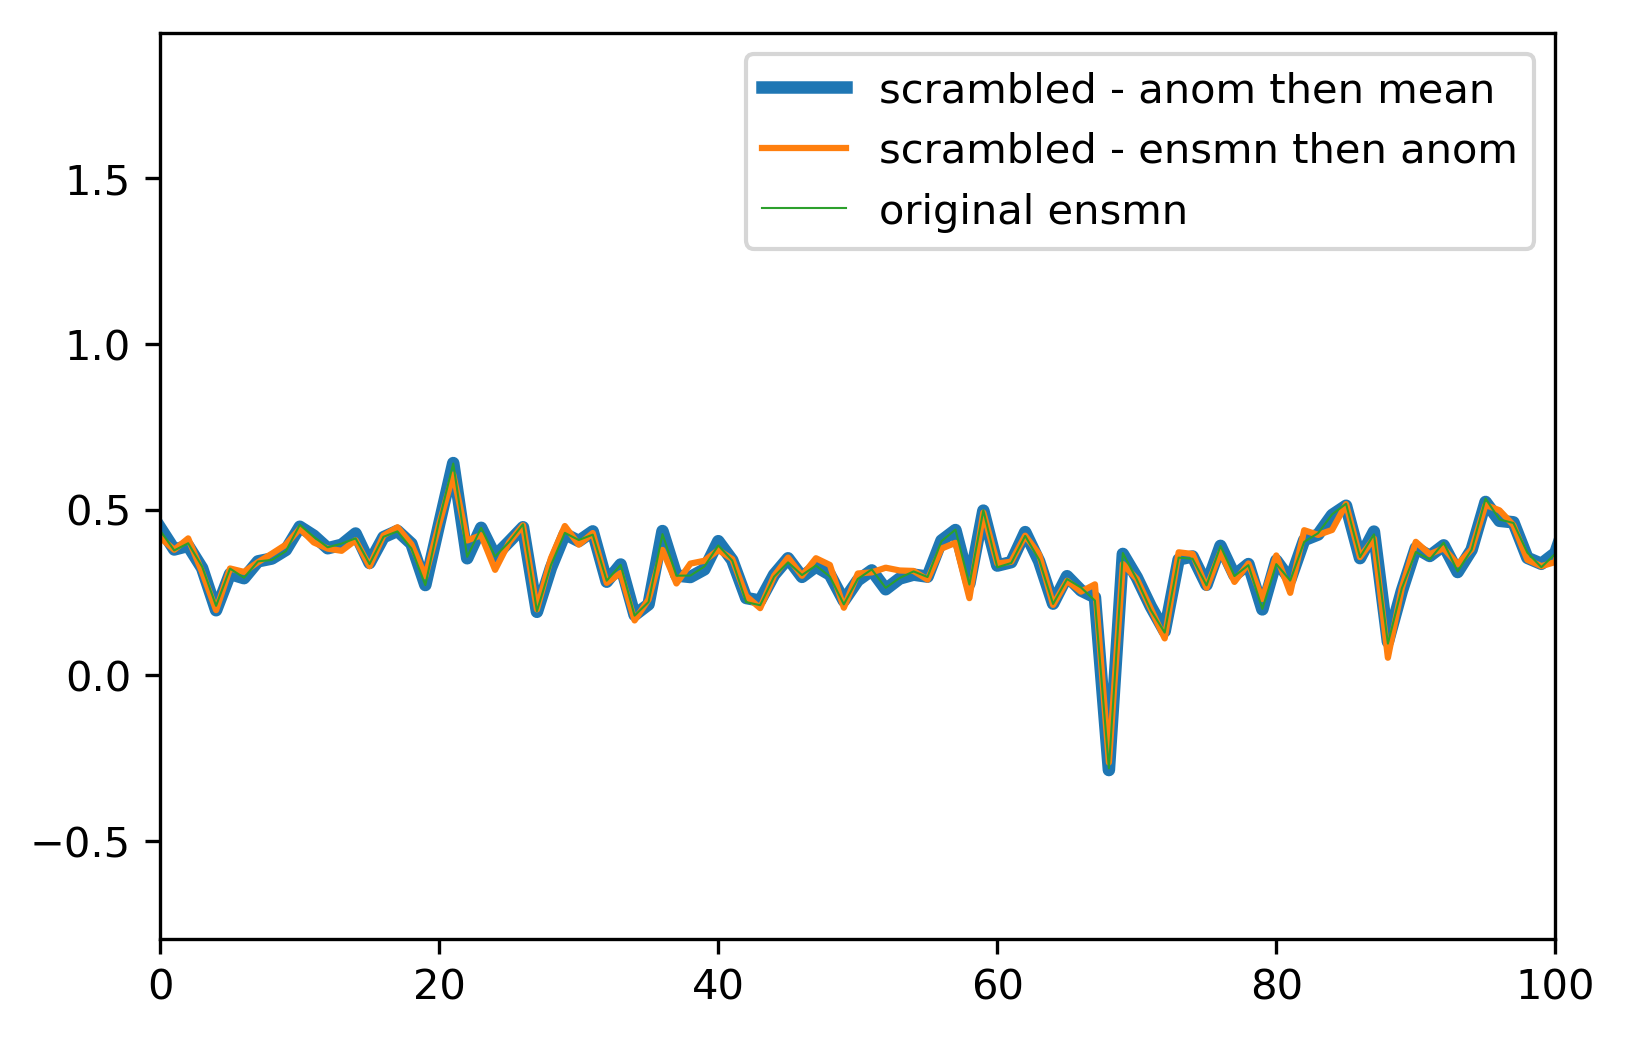

In [101]:
t = np.nanmean(sie_ens_allit_ccsm4_2d,axis=1)

plt.plot(np.nanmean(np.reshape(sie_anom,(2000,20000)),axis=1),label='scrambled - anom then mean',linewidth=3.0)
plt.plot(np.nanmean(np.reshape(sie_ens_allit_anom_ccsm4_scrambled,(2000,2000)),axis=1), label='scrambled - ensmn then anom',linewidth=1.5)
plt.plot(t - np.nanmean(t[1979:2000],axis=0),label='original ensmn',linewidth=0.5)
plt.legend()
plt.xlim(0,100)

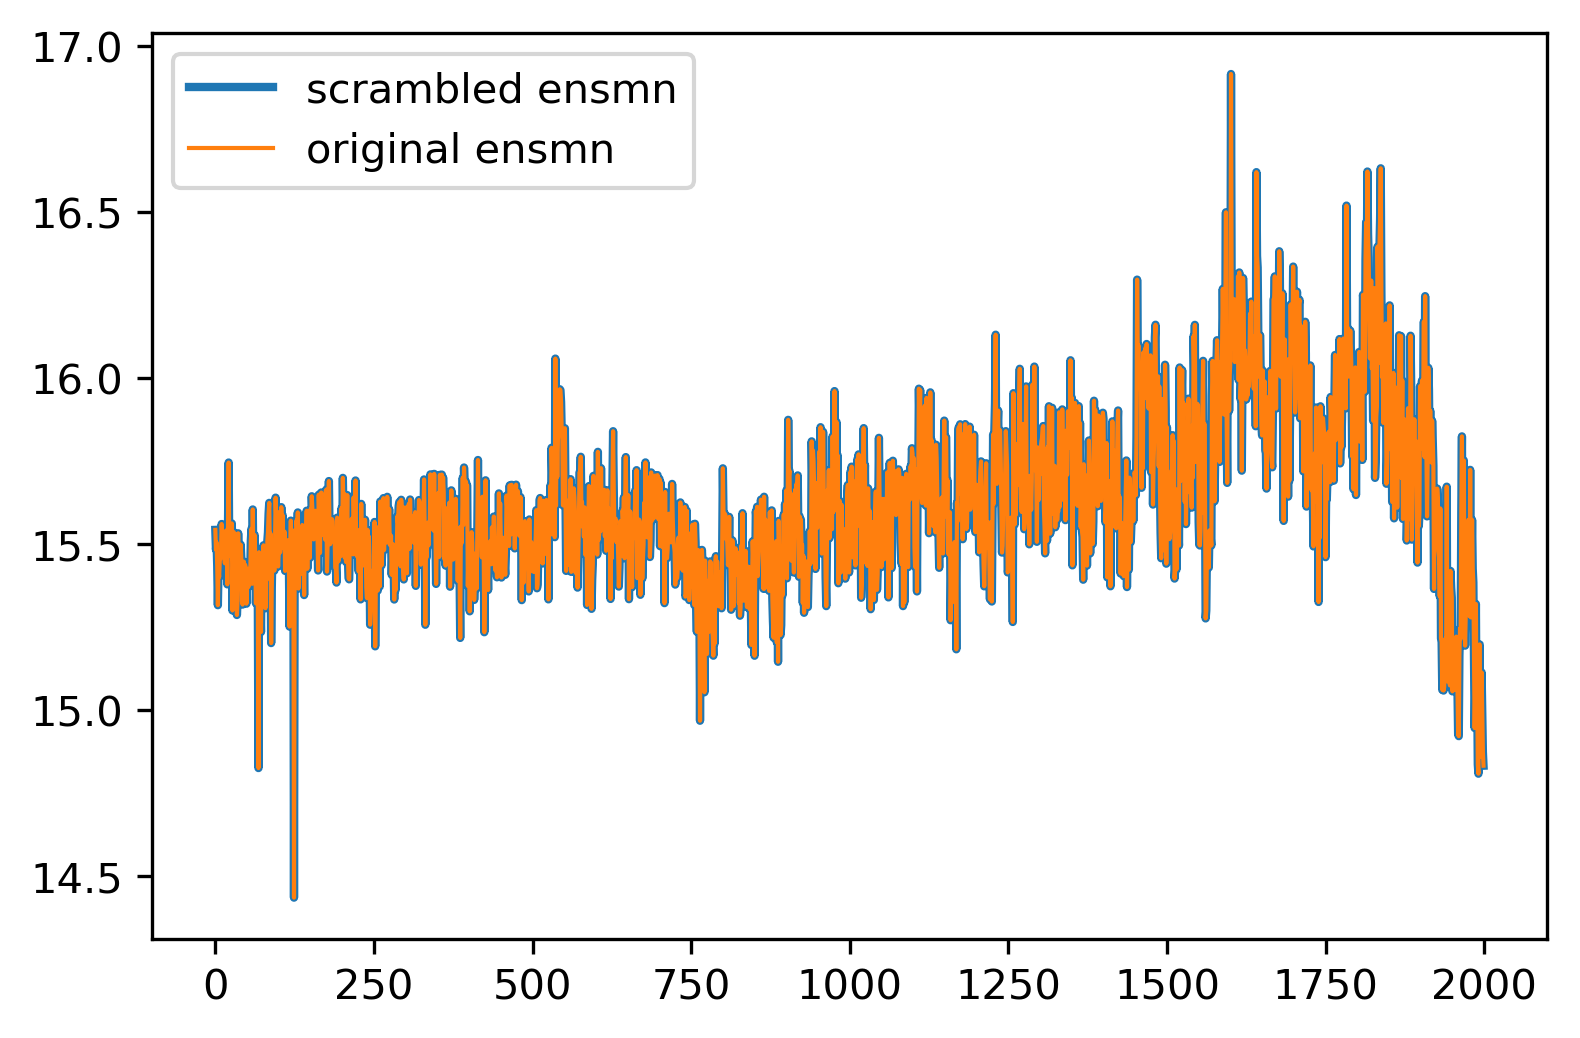

In [235]:
plt.plot(ensmn_test, label='scrambled ensmn',linewidth=2.0)
plt.plot(np.nanmean(sie_ens_allit_ccsm4_2d,axis=1),label='original ensmn',linewidth=1.0)

plt.legend()

In [148]:
sie_ens_allit_ccsm4_scrambled.shape

(2000, 500, 10)

### 30-year trends: 

In [177]:
sie_ens_allit_ccsm4_scrambled_2d = np.reshape(sie_ens_allit_ccsm4_scrambled,(2000,5000))
sie_ens_allit_mpi_scrambled_2d = np.reshape(sie_ens_allit_mpi_scrambled,(2000,5000))

In [178]:
length = 30 

sat_range_start = np.arange(1979,2017-length,1)
sat_range_end = np.arange(1979+length,2017,1)

sat30_slope_all_endpts = np.zeros(len(sat_range_start))

for t,time in enumerate(sat_range_start):
    sat30_slope_all_endpts[t] = rrutils.find_trend(fet_sie_anom,fet_time,
                                                 sat_range_start[t],sat_range_end[t])
    
sat30_slope_79_00 = rrutils.find_trend(fet_sie_anom,fet_time,1979,2000)

In [179]:
# pre30_slope_all_endpts_ccsm4 = calc_all_trends(30,1000,1850,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
pre30_slope_all_endpts_ccsm4 = calc_all_trends(30,1000,1850,sie_ens_allit_ccsm4_scrambled_2d,
                                               np.array(recon_years_ccsm4))

0 of 5000
100 of 5000
200 of 5000
300 of 5000
400 of 5000
500 of 5000
600 of 5000
700 of 5000
800 of 5000
900 of 5000
1000 of 5000
1100 of 5000
1200 of 5000
1300 of 5000
1400 of 5000
1500 of 5000
1600 of 5000
1700 of 5000
1800 of 5000
1900 of 5000
2000 of 5000
2100 of 5000
2200 of 5000
2300 of 5000
2400 of 5000
2500 of 5000
2600 of 5000
2700 of 5000
2800 of 5000
2900 of 5000
3000 of 5000
3100 of 5000
3200 of 5000
3300 of 5000
3400 of 5000
3500 of 5000
3600 of 5000
3700 of 5000
3800 of 5000
3900 of 5000
4000 of 5000
4100 of 5000
4200 of 5000
4300 of 5000
4400 of 5000
4500 of 5000
4600 of 5000
4700 of 5000
4800 of 5000
4900 of 5000


In [247]:
pre30_slope_all_endpts_ccsm4_770 = calc_all_trends(30,1200,1850,sie_ens_allit_f770_2d,
                                               np.array(recon_years_f770))

NameError: name 'sie_ens_allit_f770_2d' is not defined

In [ ]:
# pre30_slope_all_endpts_mpi = calc_all_trends(30,1000,1850,sie_ens_allit_mpi_2d,
#                                                np.array(recon_years_mpi))
pre30_slope_all_endpts_mpi = calc_all_trends(30,1000,1850,sie_ens_allit_mpi_scrambled_2d,
                                               np.array(recon_years_mpi))

In [180]:
# post30_slope_all_endpts_ccsm4 = calc_all_trends(30,1850,1979,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
post30_slope_all_endpts_ccsm4 = calc_all_trends(30,1850,1979,sie_ens_allit_ccsm4_scrambled_2d,
                                               np.array(recon_years_ccsm4))

0 of 5000
100 of 5000
200 of 5000
300 of 5000
400 of 5000
500 of 5000
600 of 5000
700 of 5000
800 of 5000
900 of 5000
1000 of 5000
1100 of 5000
1200 of 5000
1300 of 5000
1400 of 5000
1500 of 5000
1600 of 5000
1700 of 5000
1800 of 5000
1900 of 5000
2000 of 5000
2100 of 5000
2200 of 5000
2300 of 5000
2400 of 5000
2500 of 5000
2600 of 5000
2700 of 5000
2800 of 5000
2900 of 5000
3000 of 5000
3100 of 5000
3200 of 5000
3300 of 5000
3400 of 5000
3500 of 5000
3600 of 5000
3700 of 5000
3800 of 5000
3900 of 5000
4000 of 5000
4100 of 5000
4200 of 5000
4300 of 5000
4400 of 5000
4500 of 5000
4600 of 5000
4700 of 5000
4800 of 5000
4900 of 5000


In [158]:
post30_slope_all_endpts_ccsm4_770 = calc_all_trends(30,1850,1970,sie_ens_allit_f770_2d,
                                               np.array(recon_years_f770))

0 of 200
100 of 200


In [86]:
# post30_slope_all_endpts_mpi = calc_all_trends(30,1850,1979,sie_ens_allit_mpi_2d,
#                                                np.array(recon_years_mpi))
post30_slope_all_endpts_mpi = calc_all_trends(30,1850,1979,sie_ens_allit_mpi_scrambled_2d,
                                               np.array(recon_years_mpi))

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [87]:
# etcw30_slope_all_endpts_ccsm4 = calc_all_trends(30,1900,1945,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
etcw30_slope_all_endpts_ccsm4 = calc_all_trends(30,1900,1945,sie_ens_allit_ccsm4_scrambled_2d,
                                               np.array(recon_years_ccsm4))

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [106]:
sie_ens_allit_ccsm4_scrambled.shape

(2000, 200, 10)

In [108]:
pre30_ccsm4_test = np.zeros((164000,10))

for i in range(10):
    print('iteration '+str(i))
    pre30_ccsm4_test[:,i] = calc_all_trends(30,1000,1850,sie_ens_allit_ccsm4_scrambled[:,:,i],
                                            np.array(recon_years_ccsm4))

iteration 0
0 of 200
100 of 200
iteration 1
0 of 200
100 of 200
iteration 2
0 of 200
100 of 200
iteration 3
0 of 200
100 of 200
iteration 4
0 of 200
100 of 200
iteration 5
0 of 200
100 of 200
iteration 6
0 of 200
100 of 200
iteration 7
0 of 200
100 of 200
iteration 8
0 of 200
100 of 200
iteration 9
0 of 200
100 of 200


In [155]:
99*500

49500

In [156]:
nv = (1979-1850-30)*ndraws
post30_ccsm4_test = np.zeros((nv,10))

for i in range(10):
    print('iteration '+str(i))
    post30_ccsm4_test[:,i] = calc_all_trends(30,1850,1979,sie_ens_allit_ccsm4_scrambled[:,:,i],
                                               np.array(recon_years_ccsm4))

iteration 0
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 1
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 2
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 3
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 4
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 5
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 6
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 7
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 8
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500
iteration 9
0 of 500
100 of 500
200 of 500
300 of 500
400 of 500


In [163]:

sat20_ccsm4_test = np.zeros((ndraws,10))

for i in range(10):
    print('iteration '+str(i))
    for it in range(ndraws):
        sat20_ccsm4_test[it,i] = rrutils.find_trend(sie_ens_allit_ccsm4_scrambled[:,it,i],
                                                    np.array(recon_years_ccsm4),1979,2000)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [164]:
np.argmax(sat20_ccsm4_test[:,0])

19

Text(0.5,1,'Iteration 1: Ens member with maximum trend')

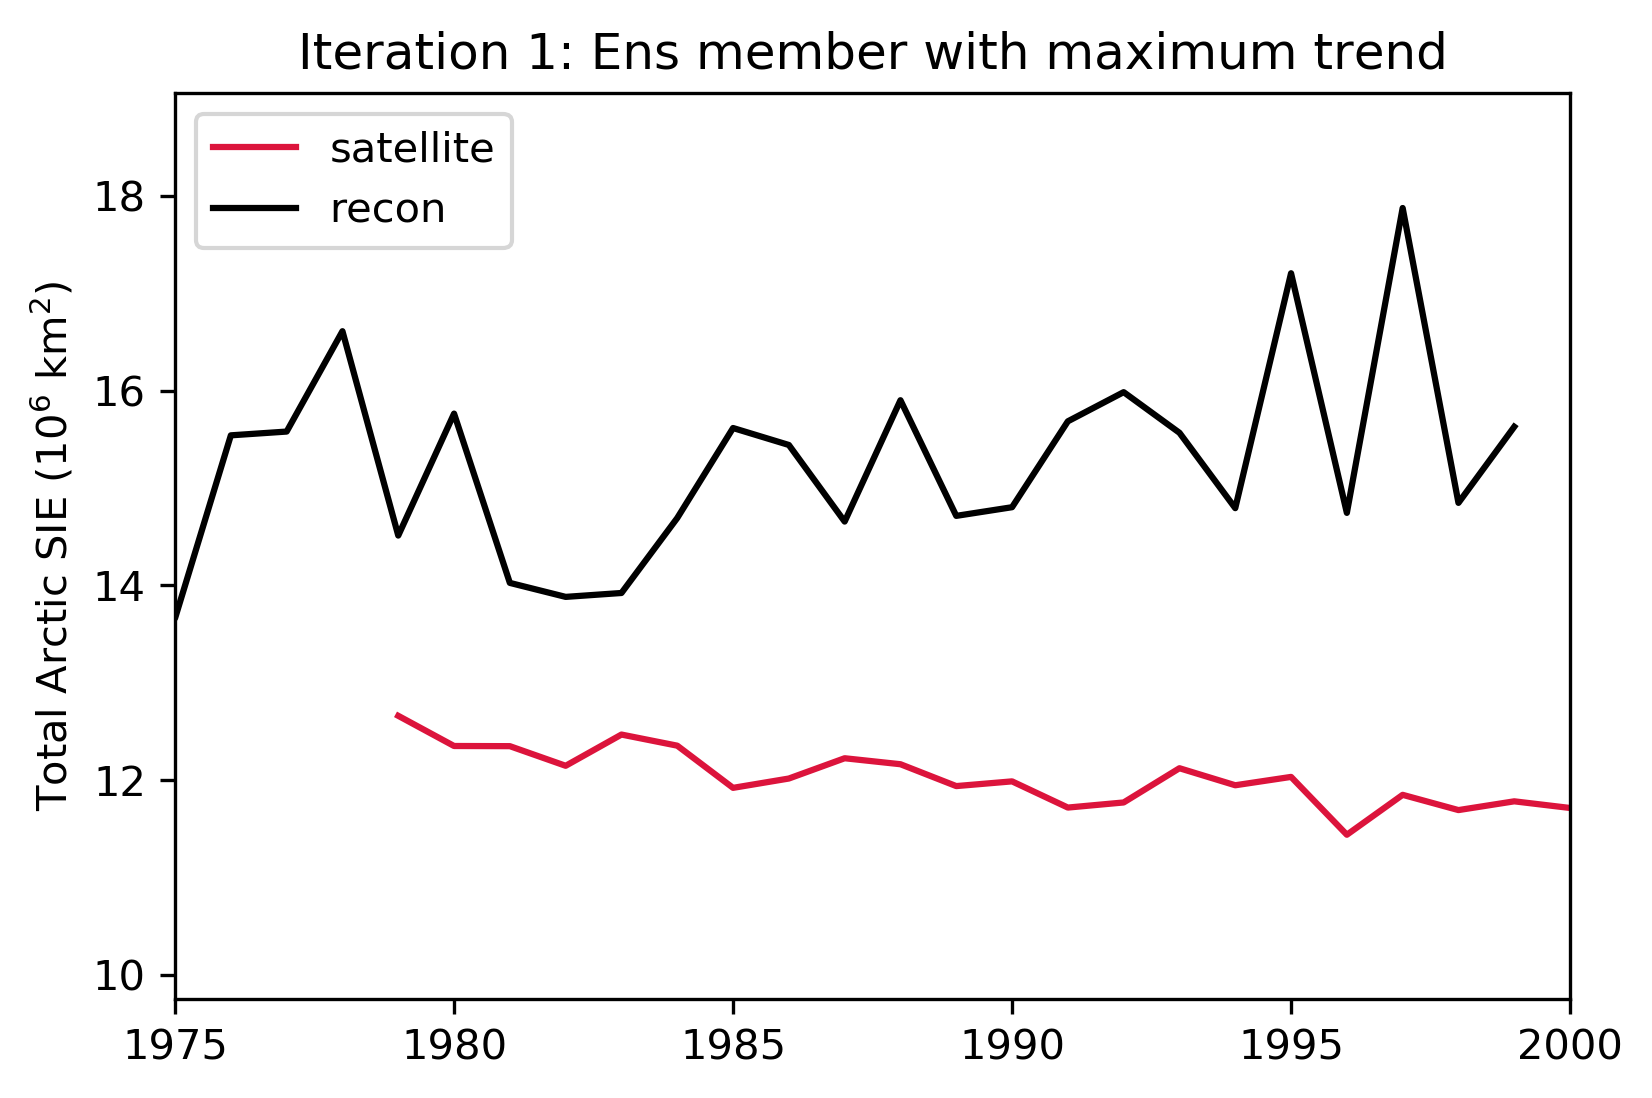

In [180]:
plt.plot(fet_time,fet_sie[:-1], color='crimson',label='satellite')
plt.plot(np.array(recon_years_ccsm4),np.squeeze(sie_ens_allit_ccsm4_scrambled[:,np.argmax(sat20_ccsm4_test[:,0]),0]),
        label='recon', color='k')
plt.xlim(1975,2000)
plt.legend()

plt.ylabel('Total Arctic SIE (10$^6$ km$^2$)')
plt.title('Iteration 1: Ens member with maximum trend')

In [138]:
rlist.shape, np.argmax(sat20_ccsm4_test[:,0]),sie_ens_allit_ccsm4.shape

((2000, 500), 24, (2000, 200, 10))

In [171]:
arglist = rlist[:,np.argmax(sat20_ccsm4_test[:,0]),0]

argls = np.array([int(i) for i in arglist])
argls.shape, np.array(recon_years_ccsm4).shape

((2000,), (2000,))

(1975, 2000)

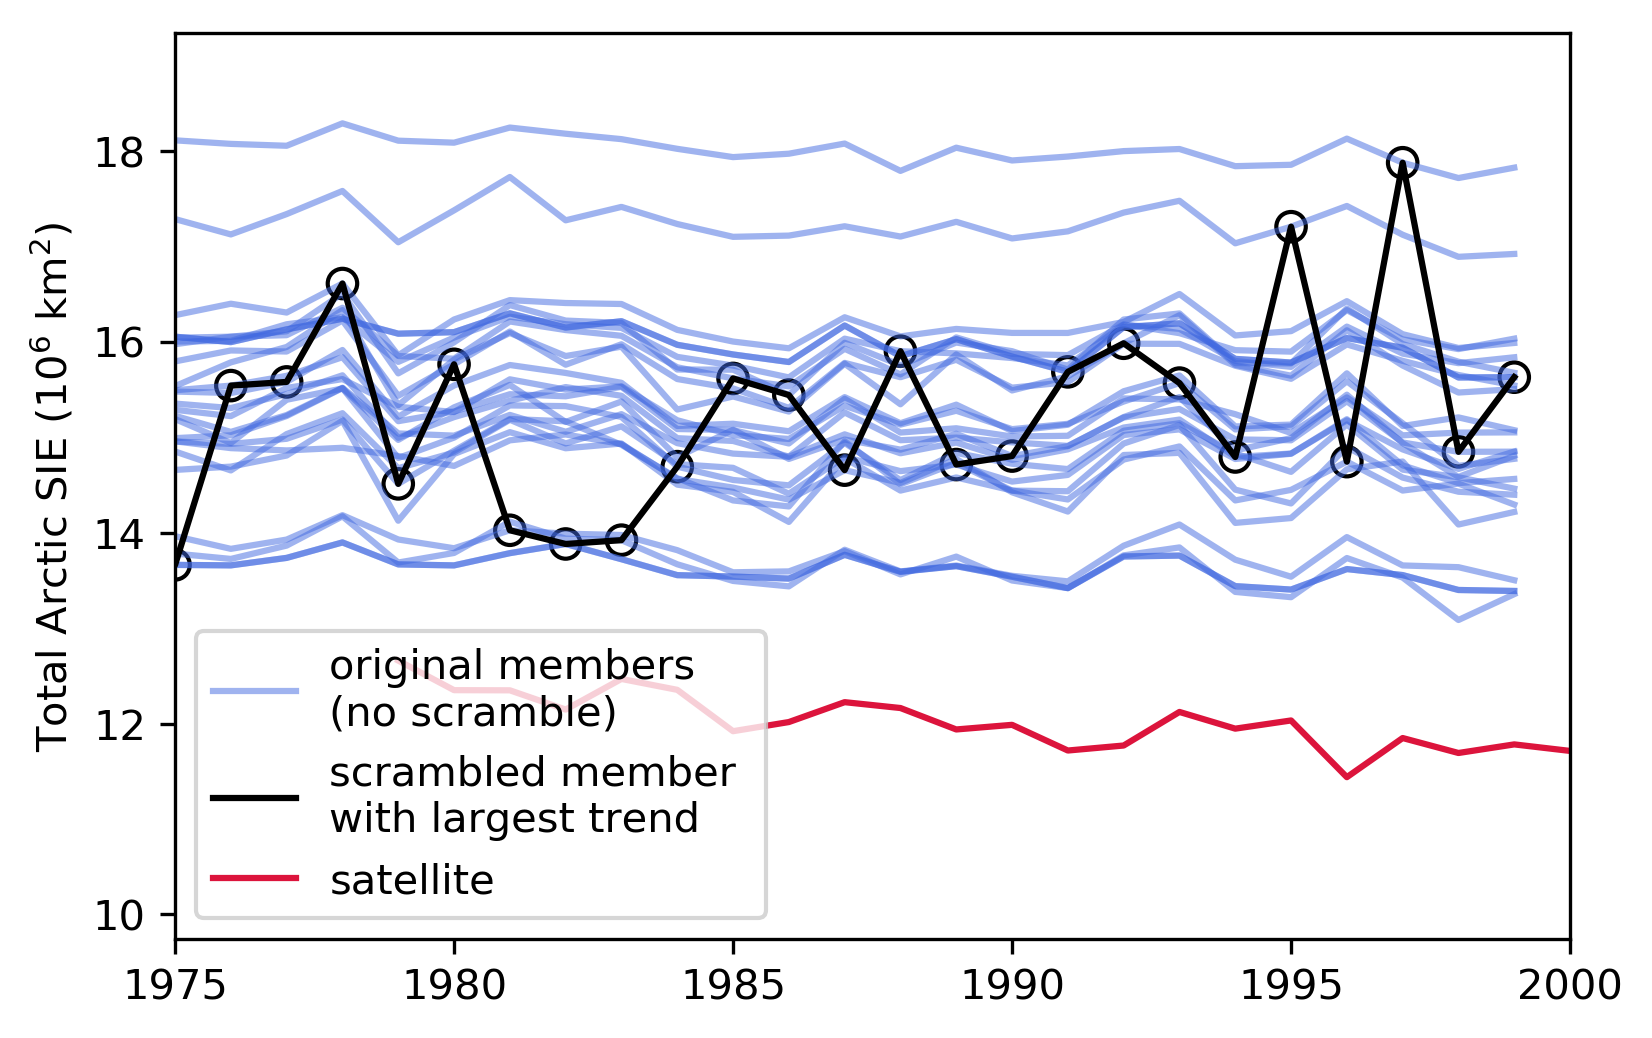

In [179]:
plt.plot(np.array(recon_years_ccsm4),sie_ens_allit_ccsm4[:,argls[1975],0], color='royalblue',
         alpha=0.5, label='original members \n(no scramble)')
plt.plot(np.array(recon_years_ccsm4),sie_ens_allit_ccsm4[:,argls[1976:],0], color='royalblue',
         alpha=0.5)
plt.plot(np.array(recon_years_ccsm4),
         np.squeeze(sie_ens_allit_ccsm4_scrambled[:,np.argmax(sat20_ccsm4_test[:,0]),0]),
         color='k',label='scrambled member \nwith largest trend')

for y in np.array(recon_years_ccsm4):
    plt.scatter(y,sie_ens_allit_ccsm4[y,argls[y],0],
                s=50, facecolors='none', edgecolors='k')

plt.plot(fet_time,fet_sie[:-1], color='crimson',label='satellite')
plt.ylabel('Total Arctic SIE (10$^6$ km$^2$)')
plt.legend()
plt.xlim(1975,2000)

In [238]:
np.nanmean(sat20_ccsm4_test,axis=0).min(), np.nanmean(sat20_ccsm4_test,axis=0).max(), np.nanmean(np.reshape(sat20_ccsm4_test,2000))

(-0.04217034158350461, -0.014749843582440114, -0.026794122553270985)

In [162]:
sat20_ccsm4_test.shape

(500, 10)

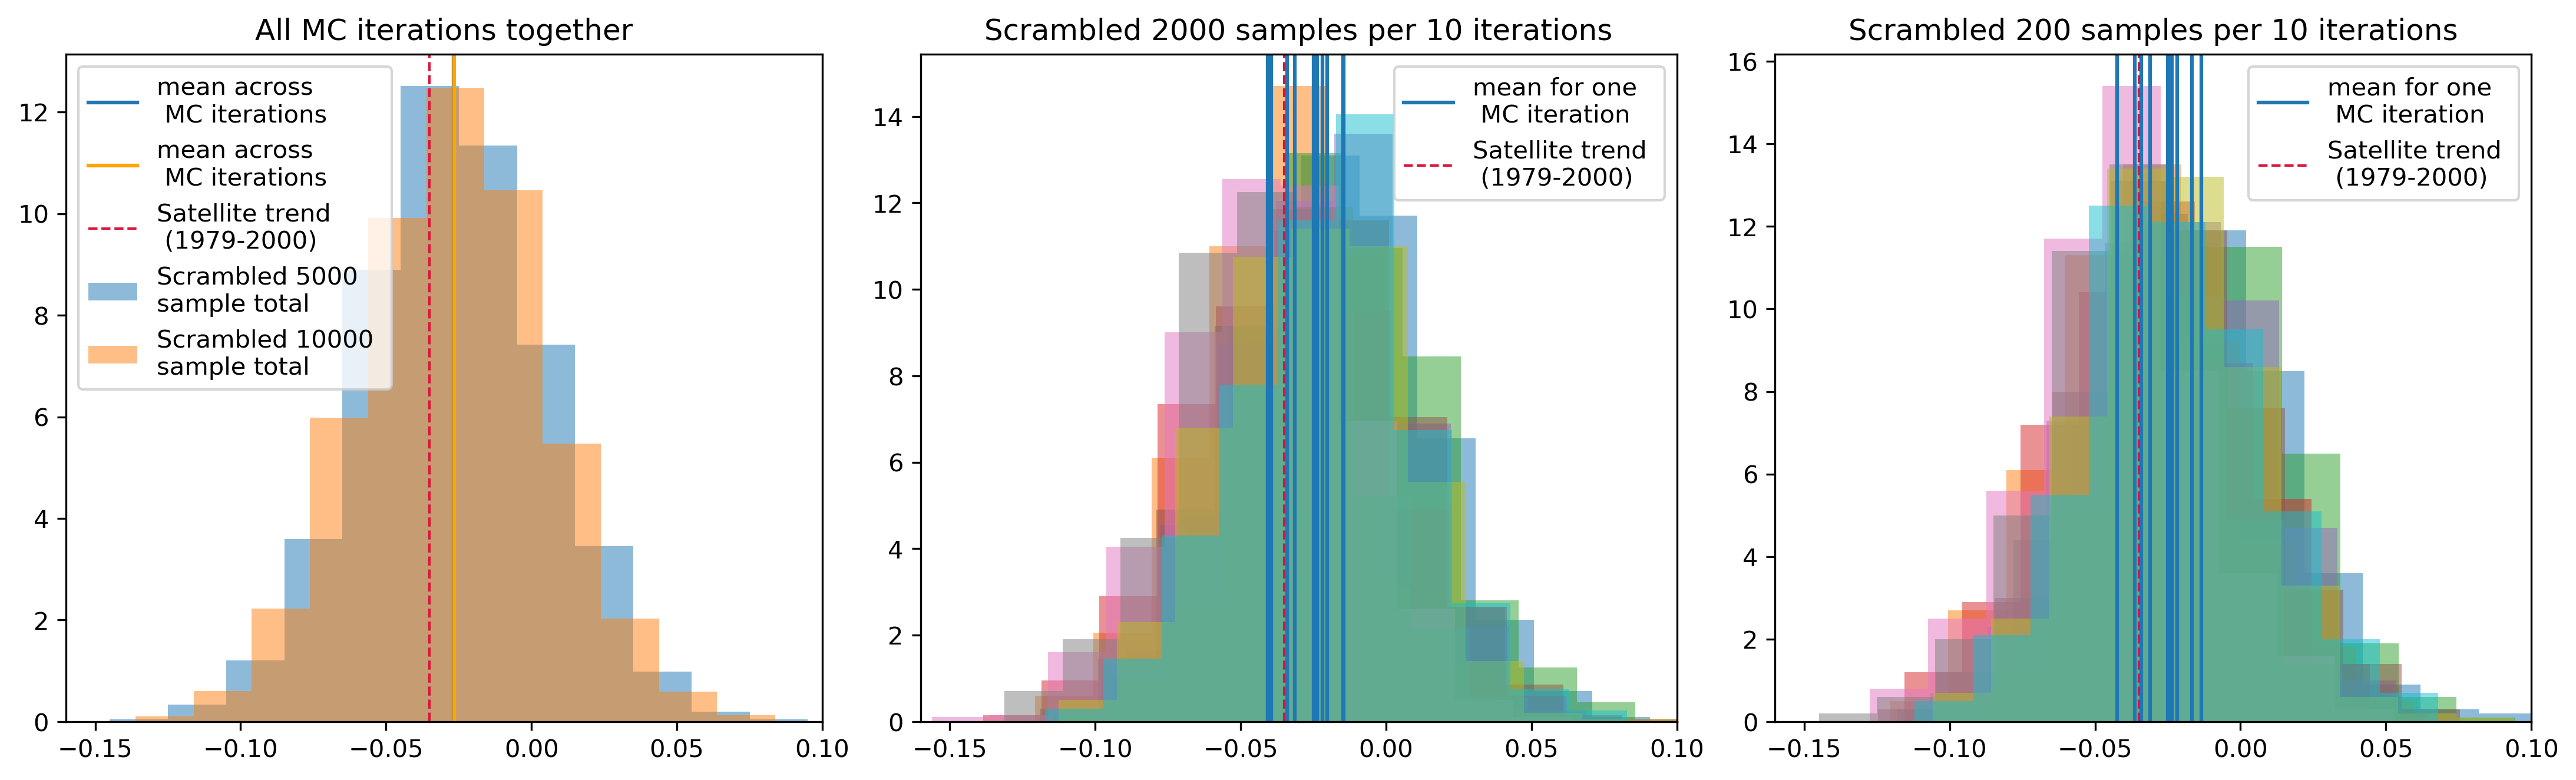

In [173]:
title2 = '30 year trends'
binwidth=0.02

ndraws1 = 500
ndraws2 = 1000

fig, (ax_hist) = plt.subplots(1,3,figsize=(18,5))
ax_hist=ax_hist.flatten()

hist_kwargs = dict(histtype='step',linewidth=1.5)

ax_hist[0].hist(np.reshape(sat20_ccsm4_test,ndraws1*10),alpha=0.5,
             bins=np.arange(min(np.reshape(sat20_ccsm4_test,ndraws1*10)),
                            max(np.reshape(sat20_ccsm4_test,ndraws1*10)) + binwidth, binwidth),
             density=True,label='Scrambled 5000 \nsample total')
ax_hist[0].axvline(np.nanmean(np.reshape(sat20_ccsm4_test,ndraws1*10),axis=0),label = 'mean across \n MC iterations')

ax_hist[0].hist(np.reshape(sat20_ccsm4_test2,ndraws2*10),alpha=0.5,
             bins=np.arange(min(np.reshape(sat20_ccsm4_test2,ndraws2*10)),
                            max(np.reshape(sat20_ccsm4_test2,ndraws2*10)) + binwidth, binwidth),
              density=True,label='Scrambled 10000 \nsample total')
ax_hist[0].axvline(np.nanmean(np.reshape(sat20_ccsm4_test2,ndraws2*10),axis=0),color='orange',
            label = 'mean across \n MC iterations')

ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')

for i in range(10):
    ax_hist[1].hist(sat20_ccsm4_test2[:,i],alpha=0.5,
                 bins=np.arange(min(sat20_ccsm4_test2[:,i]),max(sat20_ccsm4_test2[:,i]) + binwidth, binwidth),
                 density=True)
    if i is 0: 
        ax_hist[1].axvline(np.nanmean(sat20_ccsm4_test2[:,i],axis=0),label='mean for one\n MC iteration')
    else: 
        ax_hist[1].axvline(np.nanmean(sat20_ccsm4_test2[:,i],axis=0))

ax_hist[1].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')

for i in range(10):
    ax_hist[2].hist(sat20_ccsm4_test[:,i],alpha=0.5,
                 bins=np.arange(min(sat20_ccsm4_test[:,i]),max(sat20_ccsm4_test[:,i]) + binwidth, binwidth),
                 density=True)
    if i is 0: 
        ax_hist[2].axvline(np.nanmean(sat20_ccsm4_test[:,i],axis=0),label='mean for one\n MC iteration')
    else: 
        ax_hist[2].axvline(np.nanmean(sat20_ccsm4_test[:,i],axis=0))
    
ax_hist[2].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')

ax_hist[1].set_title('Scrambled 2000 samples per 10 iterations')
ax_hist[2].set_title('Scrambled 200 samples per 10 iterations')
ax_hist[0].set_title('All MC iterations together')

ax_hist[0].set_xlim(-0.16,0.10)
ax_hist[1].set_xlim(-0.16,0.10)
ax_hist[2].set_xlim(-0.16,0.10)
    
ax_hist[0].legend()
ax_hist[1].legend()
ax_hist[2].legend()

plt.subplots_adjust(wspace=0.13, hspace=0.0)

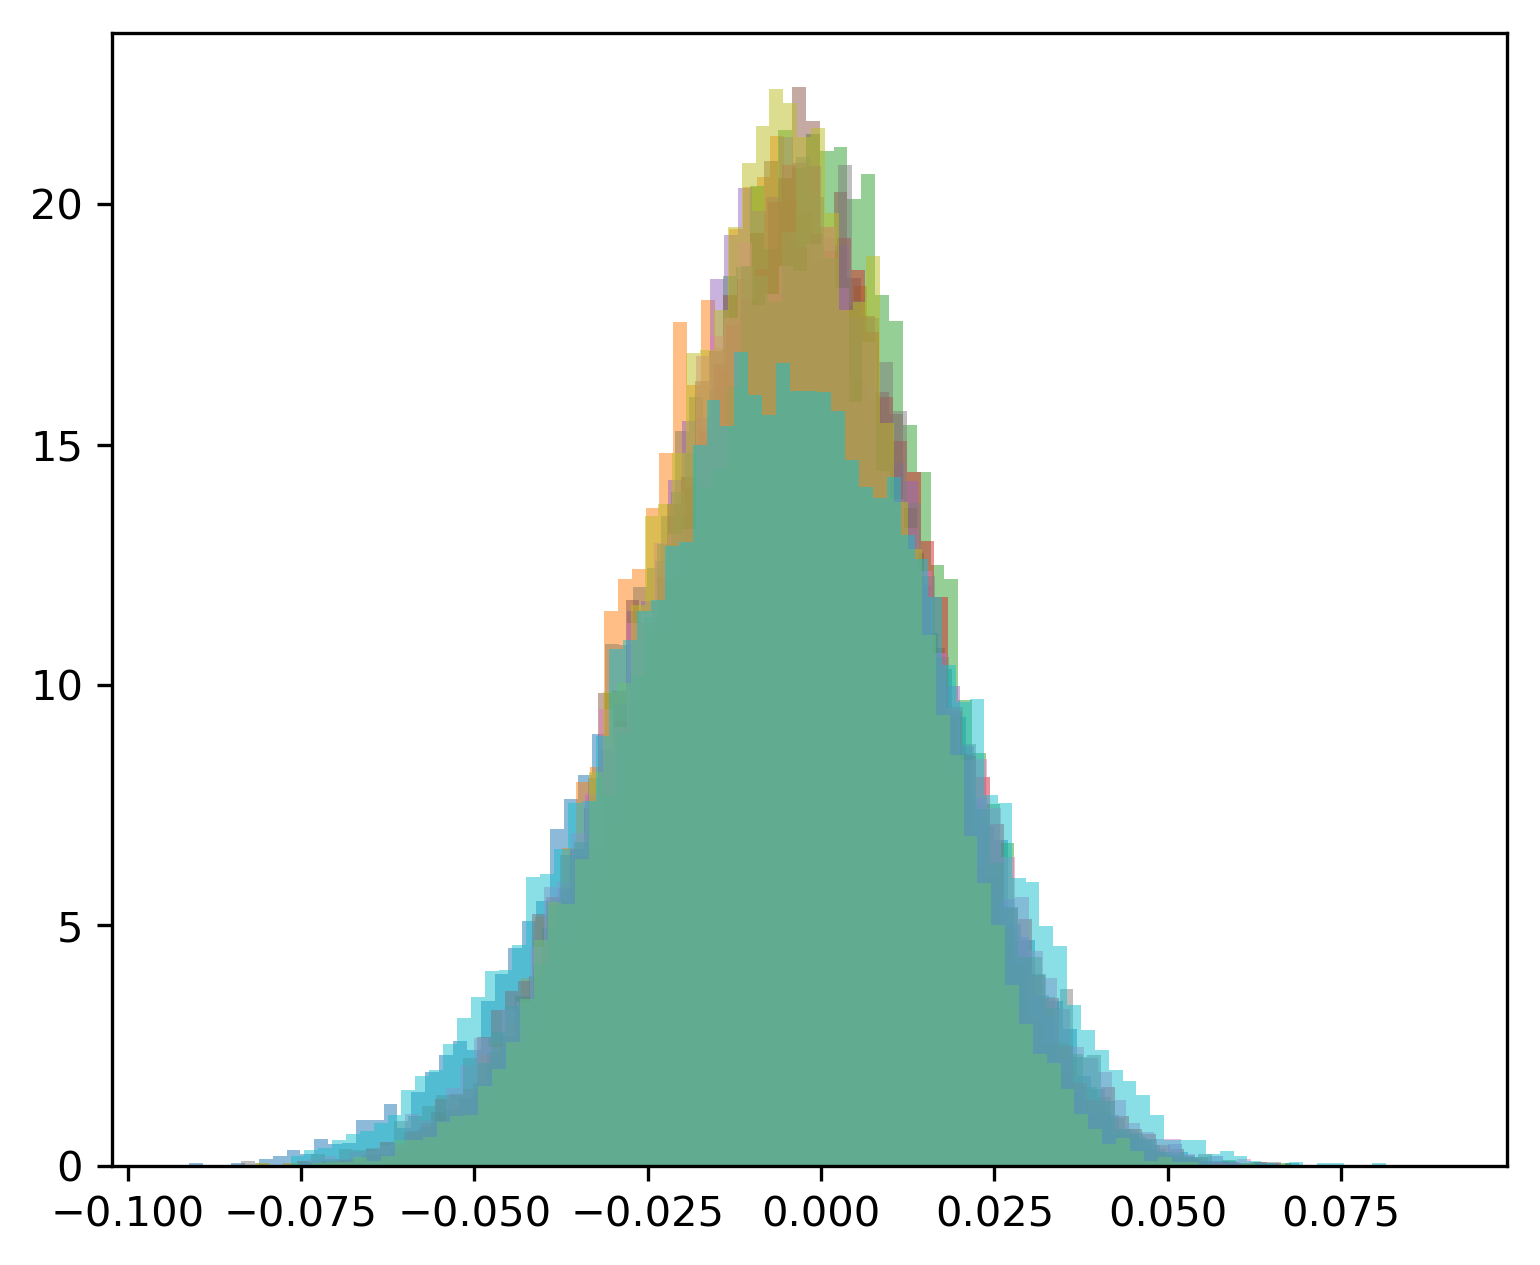

In [116]:
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,1,figsize=(6,5))

hist_kwargs = dict(histtype='step',linewidth=1.5)

for i in range(10):
    ax_hist.hist(post30_ccsm4_test[:,i],alpha=0.5,
                 bins=np.arange(min(post30_ccsm4_test[:,i]),max(post30_ccsm4_test[:,i]) + binwidth, binwidth),
                 density=True,label=('it '+str(i)))
    

plt.subplots_adjust(wspace=0.13, hspace=0.0)

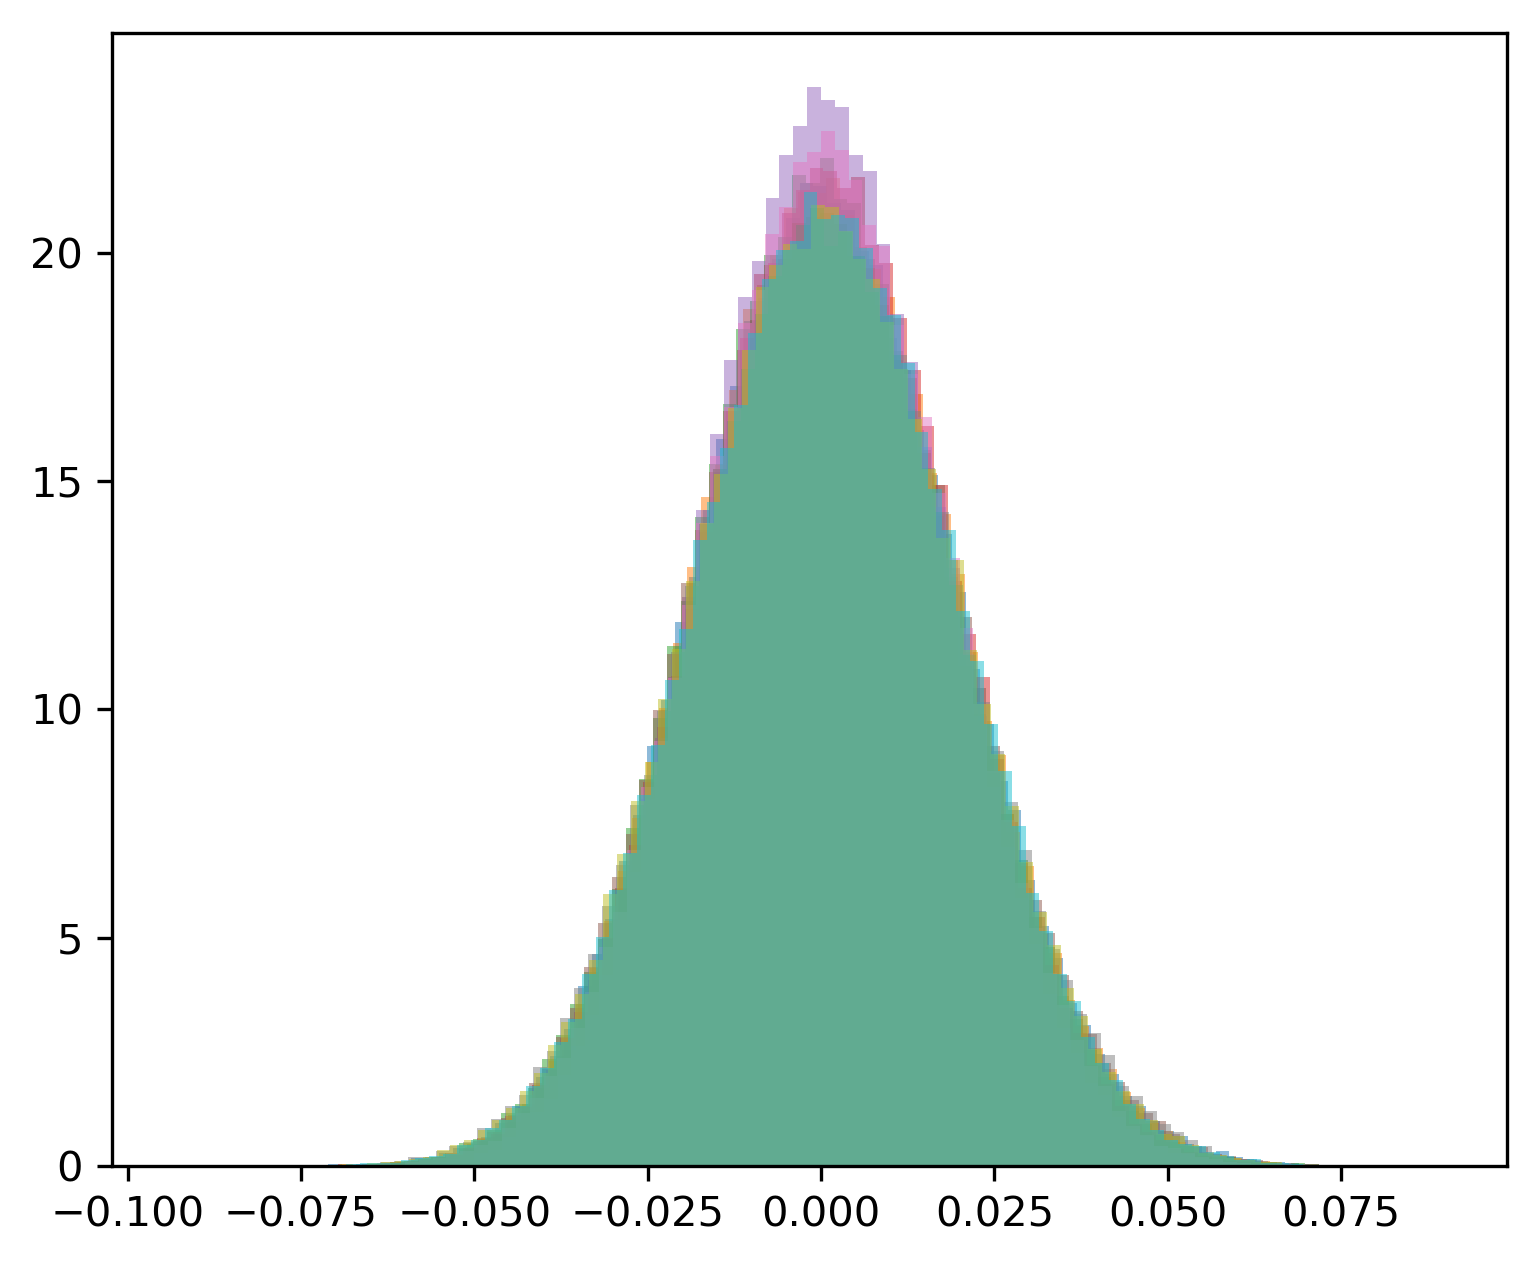

In [113]:
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,1,figsize=(6,5))

hist_kwargs = dict(histtype='step',linewidth=1.5)

for i in range(10):
    ax_hist.hist(pre30_ccsm4_test[:,i],alpha=0.5,
                 bins=np.arange(min(pre30_ccsm4_test[:,i]),max(pre30_ccsm4_test[:,i]) + binwidth, binwidth),
                 density=True,label=('it '+str(i)))
    

plt.subplots_adjust(wspace=0.13, hspace=0.0)

### 20-year trends: 

In [182]:
length = 20 

sat_range_start = np.arange(1979,2017-length,1)
sat_range_end = np.arange(1979+length,2017,1)

sat20_slope_all_endpts = np.zeros(len(sat_range_start))

for t,time in enumerate(sat_range_start):
    sat20_slope_all_endpts[t] = rrutils.find_trend(fet_sie_anom,fet_time,
                                                   sat_range_start[t],sat_range_end[t])
    
sat20_slope_79_00 = rrutils.find_trend(fet_sie_anom,fet_time,1979,2000)

In [184]:
# pre20_slope_all_endpts_ccsm4 = calc_all_trends(20,1000,1850,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
pre20_slope_all_endpts_ccsm4 = calc_all_trends(20,1000,1850,sie_ens_allit_ccsm4_scrambled_2d,
                                               np.array(recon_years_ccsm4))

0 of 5000
100 of 5000
200 of 5000
300 of 5000
400 of 5000
500 of 5000
600 of 5000
700 of 5000
800 of 5000
900 of 5000
1000 of 5000
1100 of 5000
1200 of 5000
1300 of 5000
1400 of 5000
1500 of 5000
1600 of 5000
1700 of 5000
1800 of 5000
1900 of 5000
2000 of 5000
2100 of 5000
2200 of 5000
2300 of 5000
2400 of 5000
2500 of 5000
2600 of 5000
2700 of 5000
2800 of 5000
2900 of 5000
3000 of 5000
3100 of 5000
3200 of 5000
3300 of 5000
3400 of 5000
3500 of 5000
3600 of 5000
3700 of 5000
3800 of 5000
3900 of 5000
4000 of 5000
4100 of 5000
4200 of 5000
4300 of 5000
4400 of 5000
4500 of 5000
4600 of 5000
4700 of 5000
4800 of 5000
4900 of 5000


In [161]:
pre20_slope_all_endpts_ccsm4_770 = calc_all_trends(20,1200,1850,sie_ens_allit_f770_2d,
                                               np.array(recon_years_f770))

0 of 200
100 of 200


In [66]:
# pre20_slope_all_endpts_mpi = calc_all_trends(20,1000,1850,sie_ens_allit_mpi_2d,
#                                                np.array(recon_years_mpi))
pre20_slope_all_endpts_mpi = calc_all_trends(20,1000,1850,sie_ens_anom_allit_mpi_scrambled,
                                               np.array(recon_years_mpi))

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [185]:
# post20_slope_all_endpts_ccsm4 = calc_all_trends(20,1850,1979,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
post20_slope_all_endpts_ccsm4 = calc_all_trends(20,1850,1979,sie_ens_allit_ccsm4_scrambled_2d,
                                               np.array(recon_years_ccsm4))

0 of 5000
100 of 5000
200 of 5000
300 of 5000
400 of 5000
500 of 5000
600 of 5000
700 of 5000
800 of 5000
900 of 5000
1000 of 5000
1100 of 5000
1200 of 5000
1300 of 5000
1400 of 5000
1500 of 5000
1600 of 5000
1700 of 5000
1800 of 5000
1900 of 5000
2000 of 5000
2100 of 5000
2200 of 5000
2300 of 5000
2400 of 5000
2500 of 5000
2600 of 5000
2700 of 5000
2800 of 5000
2900 of 5000
3000 of 5000
3100 of 5000
3200 of 5000
3300 of 5000
3400 of 5000
3500 of 5000
3600 of 5000
3700 of 5000
3800 of 5000
3900 of 5000
4000 of 5000
4100 of 5000
4200 of 5000
4300 of 5000
4400 of 5000
4500 of 5000
4600 of 5000
4700 of 5000
4800 of 5000
4900 of 5000


In [68]:
# post20_slope_all_endpts_mpi = calc_all_trends(20,1850,1979,sie_ens_allit_mpi_2d,
#                                                np.array(recon_years_mpi))
post20_slope_all_endpts_mpi = calc_all_trends(20,1850,1979,sie_ens_anom_allit_mpi_scrambled,
                                               np.array(recon_years_mpi))

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [164]:
post20_slope_all_endpts_ccsm4_770 = calc_all_trends(20,1850,1970,sie_ens_allit_f770_2d,
                                               np.array(recon_years_f770))

0 of 200
100 of 200


In [69]:
# etcw20_slope_all_endpts_ccsm4 = calc_all_trends(20,1900,1945,sie_ens_allit_ccsm4_2d,
#                                                np.array(recon_years_ccsm4))
etcw20_slope_all_endpts_ccsm4 = calc_all_trends(20,1900,1945,sie_ens_anom_allit_ccsm4_scrambled,
                                               np.array(recon_years_ccsm4))

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [70]:
sat20_slope_recon_ccsm4 = np.zeros((sie_ens_allit_ccsm4_2d.shape[1]))

for it in range(2000):
#     sat20_slope_recon_ccsm4[it] = rrutils.find_trend(sie_ens_allit_ccsm4_2d[:,it],
#                                                      np.array(recon_years_ccsm4),1979,2000)
    sat20_slope_recon_ccsm4[it] = rrutils.find_trend(sie_ens_anom_allit_ccsm4_scrambled[:,it],
                                                     np.array(recon_years_ccsm4),1979,2000)

In [187]:
sat20_slope_recon_ccsm4 = np.zeros((ndraws*10))

for i in range(10*ndraws):
    sat20_slope_recon_ccsm4[i] = rrutils.find_trend(sie_ens_allit_ccsm4_scrambled_2d[:,i],
                                                    np.array(recon_years_ccsm4),1979,2000)

In [71]:
sat20_slope_recon_mpi = np.zeros((sie_ens_allit_mpi_2d.shape[1]))

for it in range(2000):
#     sat20_slope_recon_mpi[it] = rrutils.find_trend(sie_ens_allit_mpi_2d[:,it],
#                                                    np.array(recon_years_mpi),1979,2000)
    sat20_slope_recon_mpi[it] = rrutils.find_trend(sie_ens_anom_allit_mpi_scrambled[:,it],
                                                   np.array(recon_years_mpi),1979,2000)

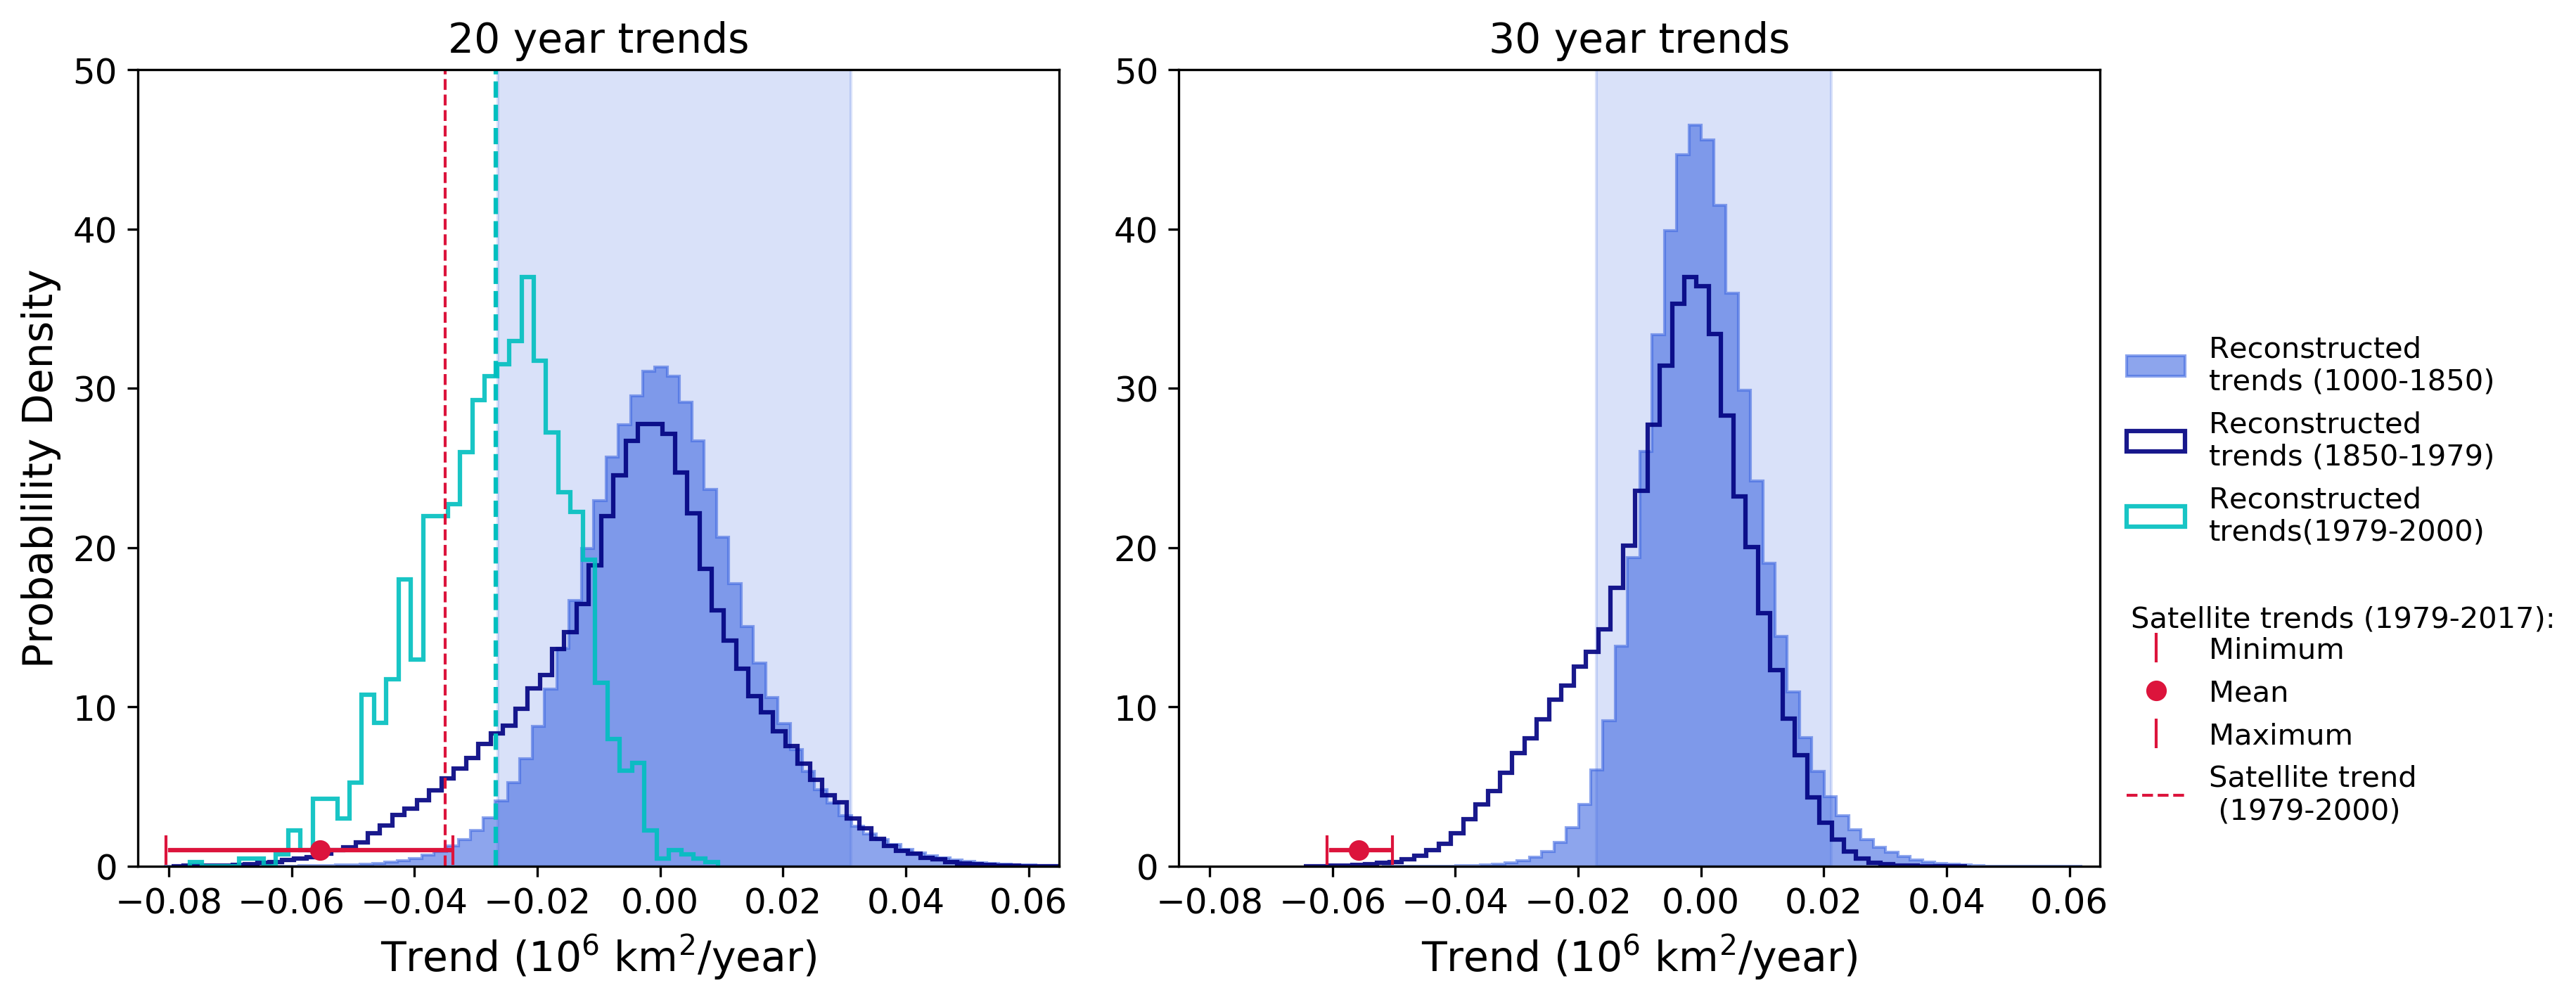

In [121]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat(pre20_slope_all_endpts_ccsm4, post20_slope_all_endpts_ccsm4, 
                       sat20_slope_recon_ccsm4,2.5, 97.5, 1000, binwidth, ax_hist[0],strends=True)
plot_hist_pre_post_sat(pre30_slope_all_endpts_ccsm4, post30_slope_all_endpts_ccsm4, 
                       np.zeros(30), 2.5, 97.5, 1000, binwidth, ax_hist[1],strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ')
ax_hist[0].axhline(y=1,xmin=0.035,xmax=0.34,color='crimson',linewidth=1.5)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.165,xmax=0.23,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.085,0.065)
ax_hist[0].set_ylim(0,50)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.085,0.065)
ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[7], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[7], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 15,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_ccsm4.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

In [189]:
def plot_hist_pre_post_sat_test(pre_industrial_trends, post_industrial_trends, sat_trends, 
                           percentile_low, percentile_high, start_year, binwidth, ax_hist,
                           palette = 'blues',strends=False): 
    hist_kwargs = dict(histtype='step',linewidth=1.5)
    
    if palette in ['blues']:
        c1 = 'royalblue'
        c2 = 'navy'
        c3 = 'c'
    elif palette in ['purples']: 
        c1 = 'rebeccapurple'
        c2 = 'indigo'
        c3 = 'mediumorchid'
    else:
        c1 = 'darkcyan'
        c2 = 'darkslategray'
        c3 = 'c'

#     ax_hist.axvspan(np.percentile(pre_industrial_trends,percentile_low),
#                     np.percentile(pre_industrial_trends,percentile_high),
#                     color='royalblue',alpha=0.2,edgecolor=None)

    ax_hist.axvline(np.percentile(pre_industrial_trends,percentile_low),
                    ymin=0, ymax=0.15, color='w',linewidth=1.5,zorder=1)
    ax_hist.axvline(np.percentile(pre_industrial_trends,percentile_high),
                    ymin=0, ymax=0.15, color='w',linewidth=1.5,zorder=1)

    # ax_hist.axvline(np.nanmean(post_industrial_trends),linestyle='--',color='navy')

    ax_hist.hist(pre_industrial_trends,facecolor=c1,edgecolor=c1,
                 fill=True,density=True,alpha=0.6,label='Reconstructed \ntrends ('+str(start_year)+'-1850)',
                 bins=np.arange(min(pre_industrial_trends),max(pre_industrial_trends) + binwidth, binwidth),
                 histtype='step',linewidth=1,zorder=0)
    ax_hist.hist(post_industrial_trends,edgecolor=c2,density=True,
                 alpha=0.9,label='Reconstructed \ntrends (1850-1979)',
                 bins=np.arange(min(post_industrial_trends),max(post_industrial_trends) + binwidth, binwidth), 
                 zorder=2,**hist_kwargs)
    ax_hist.hist(sat_trends,edgecolor=c3,density=True,
                 facecolor=c3,alpha=0.9,label='Reconstructed \ntrends(1979-2000)',
                 bins=np.arange(min(sat_trends),max(sat_trends) + binwidth, binwidth),
                 zorder=3,**hist_kwargs)

    if strends is True: 
        ax_hist.axvline(np.mean(sat_trends),linestyle='--',color=c3)

    return 

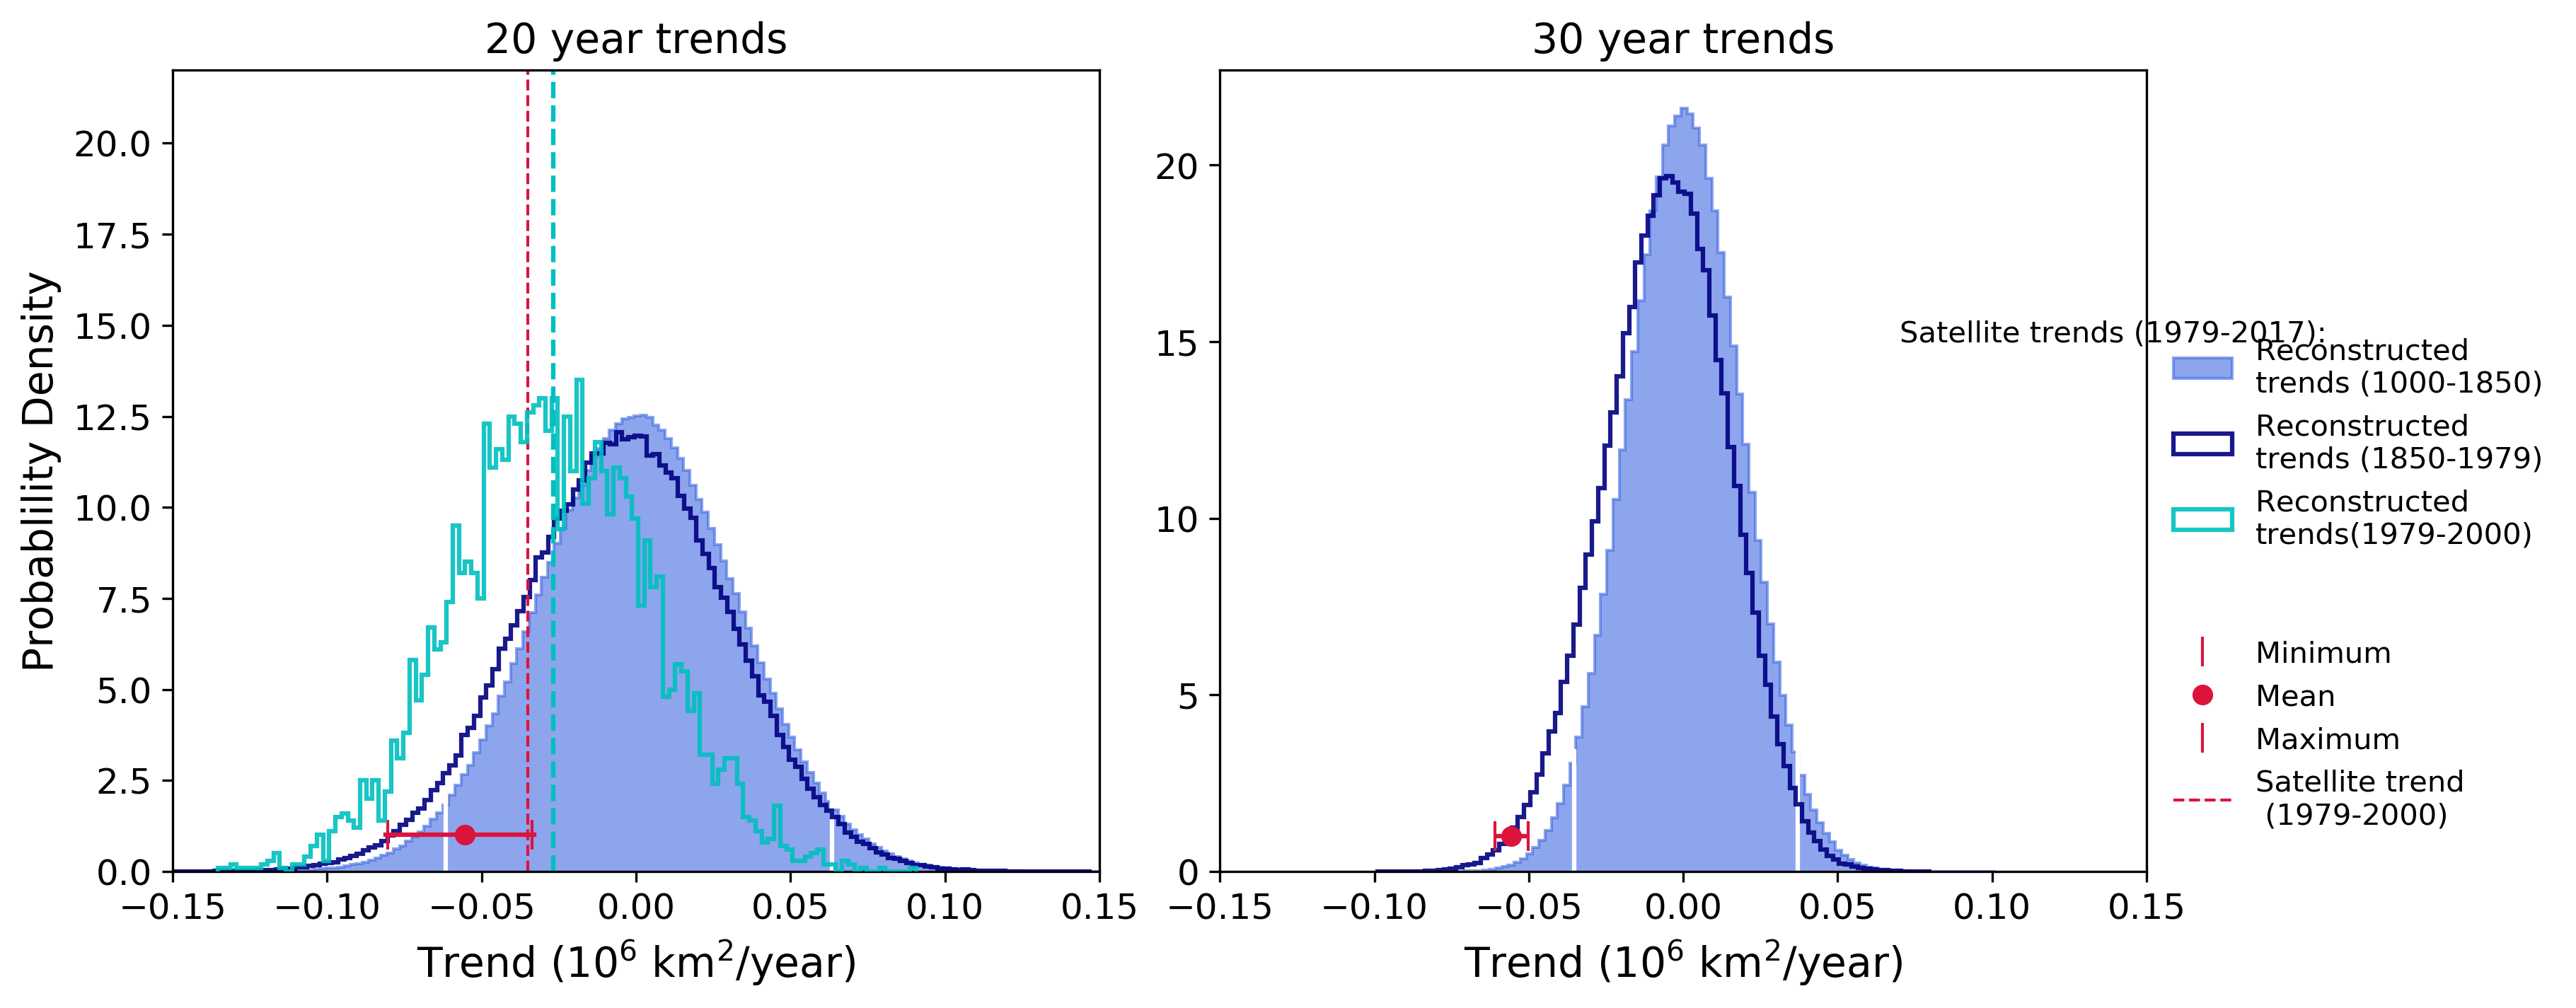

In [205]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat_test(pre20_slope_all_endpts_ccsm4, post20_slope_all_endpts_ccsm4, 
                            sat20_slope_recon_ccsm4,2.5, 97.5, 1000, binwidth, ax_hist[0],
                            palette = 'blues',strends=True)
plot_hist_pre_post_sat_test(pre30_slope_all_endpts_ccsm4, post30_slope_all_endpts_ccsm4, 
                            np.zeros(30), 2.5, 97.5, 1000, binwidth, ax_hist[1],
                            palette = 'blues',strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ',zorder=5)
ax_hist[0].axhline(y=1,xmin=0.23,xmax=0.39,color='crimson',linewidth=1.5,zorder=4)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.3,xmax=0.33,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.15,0.15)
ax_hist[0].set_ylim(0,22)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.15,0.15)
#ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[7], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[7], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 15,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_ccsm4_white_scramble.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

NameError: name 'pre20_slope_all_endpts_ccsm4_770' is not defined

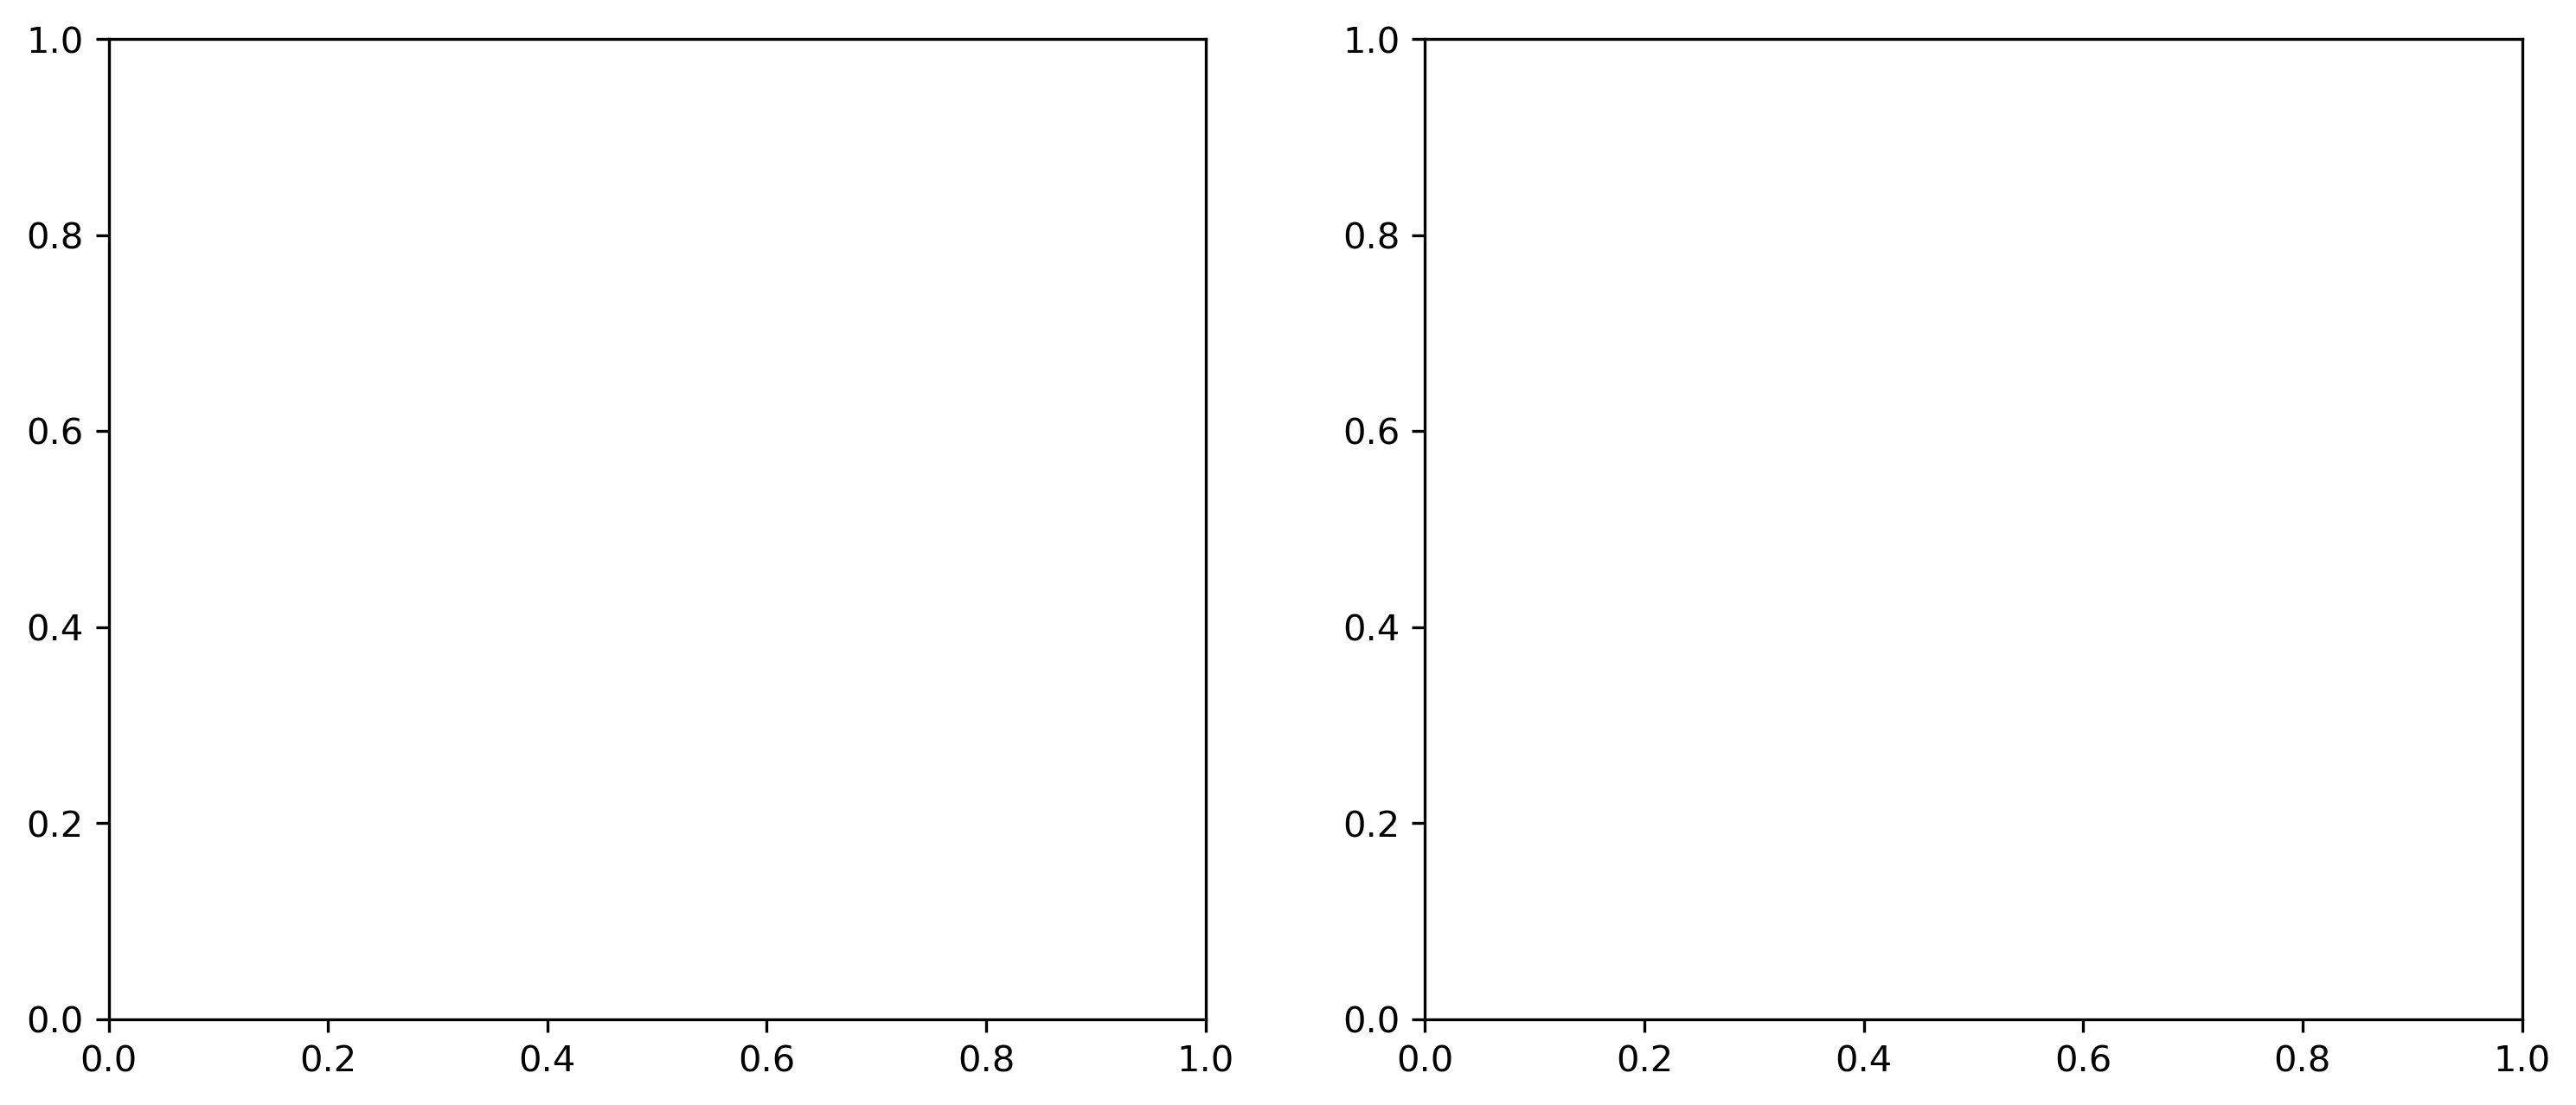

In [74]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat_test(pre20_slope_all_endpts_ccsm4_770, post20_slope_all_endpts_ccsm4_770, 
                       np.zeros(30),2.5, 97.5, 1200, binwidth, ax_hist[0],palette='hi',strends=False)
plot_hist_pre_post_sat_test(pre30_slope_all_endpts_ccsm4_770, post30_slope_all_endpts_ccsm4_770, 
                       np.zeros(30), 2.5, 97.5, 1200, binwidth, ax_hist[1],palette='hi',strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ',zorder=5)
ax_hist[0].axhline(y=1,xmin=0.035,xmax=0.34,color='crimson',linewidth=1.5,zorder=4)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.165,xmax=0.23,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.085,0.065)
ax_hist[0].set_ylim(0,50)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.085,0.065)
#ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 29,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_ccsm4_white_fixed_proxy_f770.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

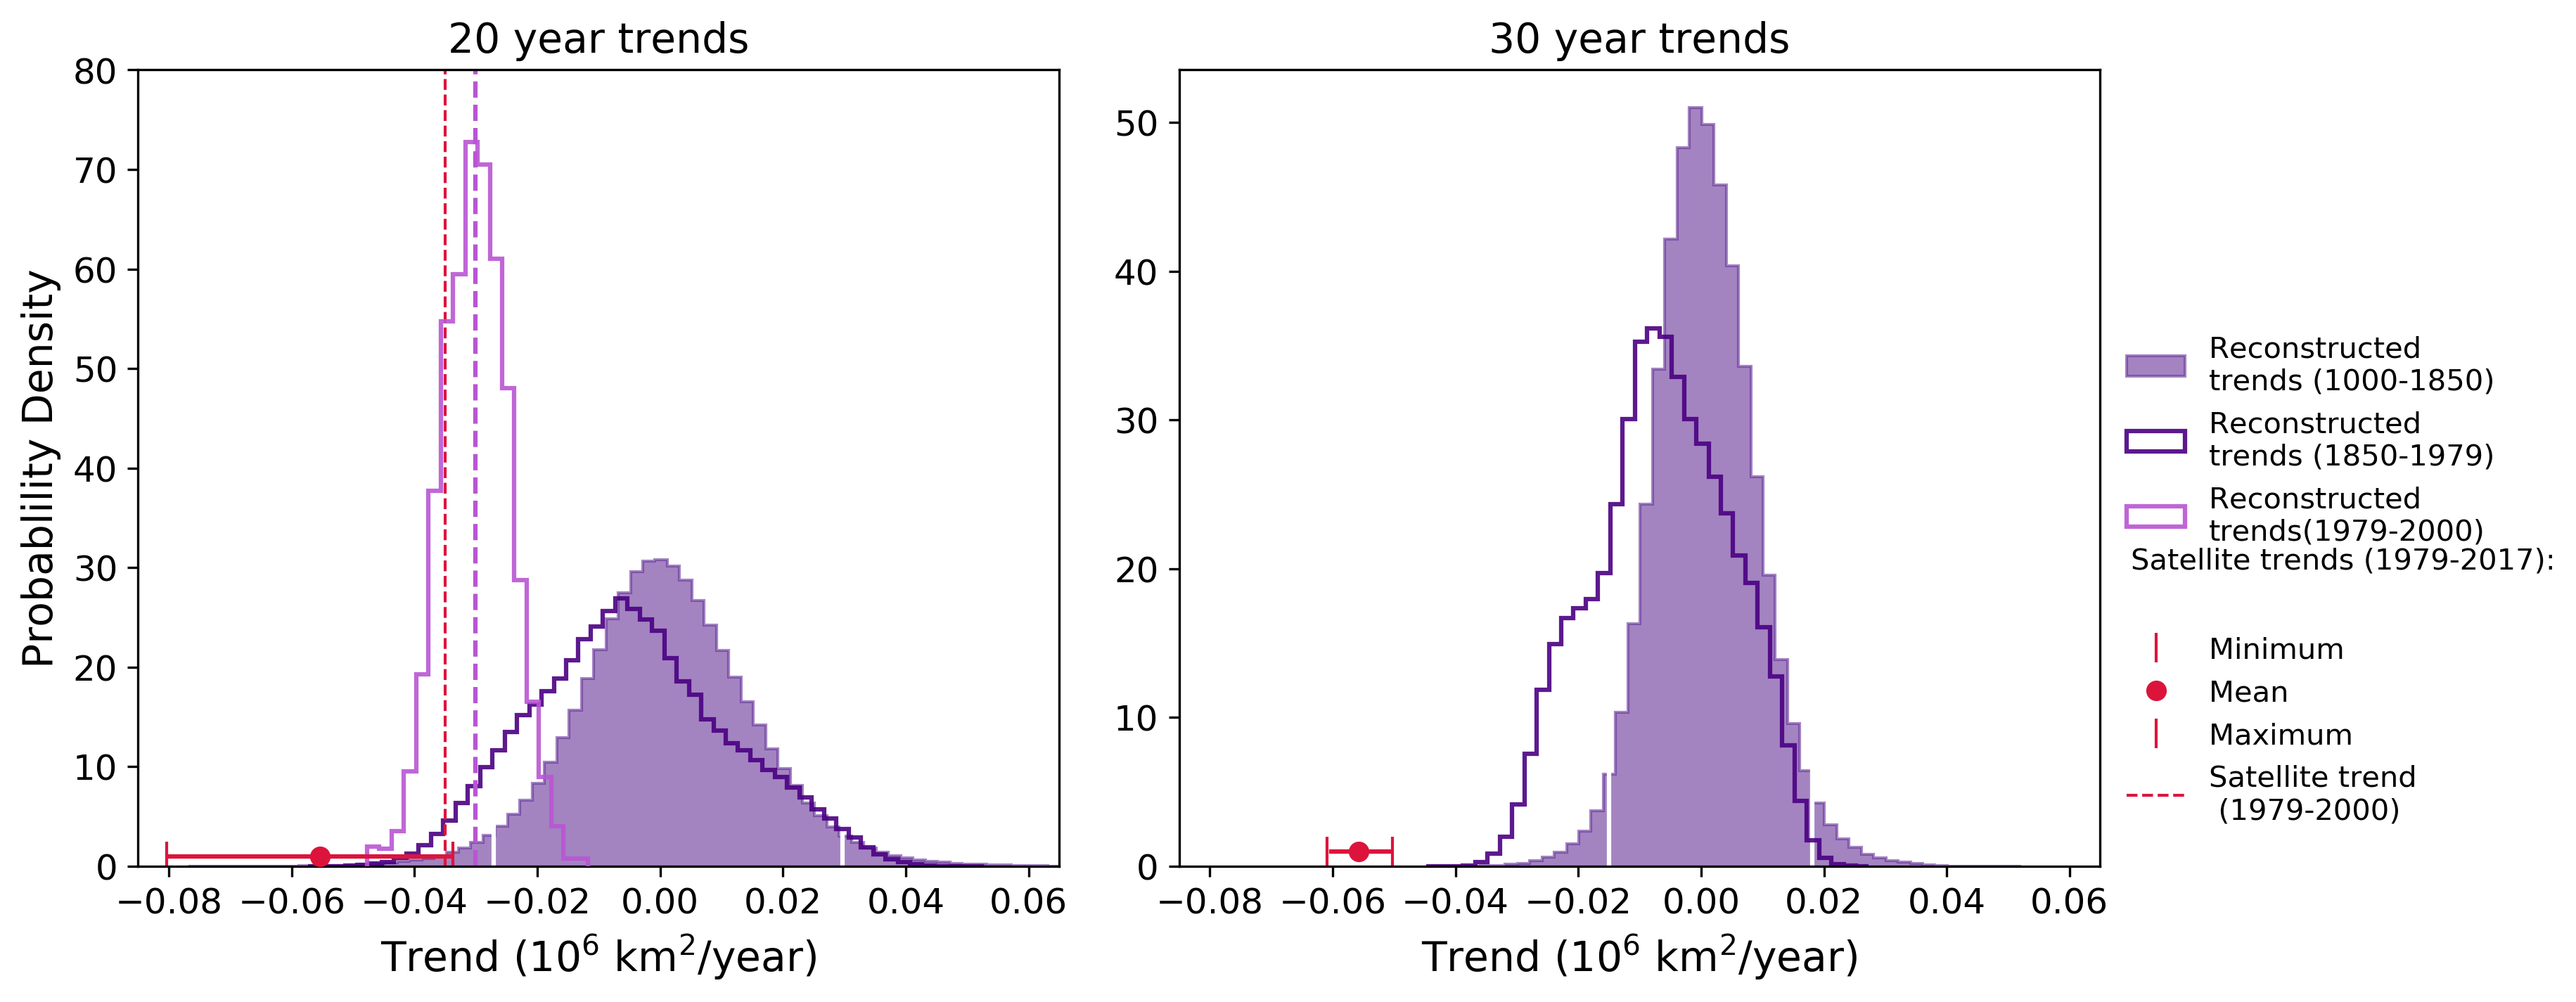

In [85]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat_test(pre20_slope_all_endpts_mpi, post20_slope_all_endpts_mpi, 
                            sat20_slope_recon_mpi,2.5, 97.5, 1000, binwidth, ax_hist[0],
                            palette = 'purples',strends=True)
plot_hist_pre_post_sat_test(pre30_slope_all_endpts_mpi, post30_slope_all_endpts_mpi, 
                            np.zeros(30), 2.5, 97.5, 1000, binwidth, ax_hist[1],
                            palette = 'purples',strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=1,
                label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ',zorder=5)
ax_hist[0].axhline(y=1,xmin=0.035,xmax=0.34,color='crimson',linewidth=1.5,zorder=4)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.165,xmax=0.23,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.085,0.065)
ax_hist[0].set_ylim(0,80)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.085,0.065)
#ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[7], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[7], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 20,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_mpi_white_scramble.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## At what chunk length do distributions deviatiate?

In [20]:
window_pre = np.arange(10,40,1)

pre_slope_mean = np.zeros(window_pre.shape[0])
pre_slope_max = np.zeros(window_pre.shape[0])
pre_slope_min = np.zeros(window_pre.shape[0])
pre_slope_p95 = np.zeros(window_pre.shape[0])
pre_slope_p5 = np.zeros(window_pre.shape[0])
pre_slope_p97_5 = np.zeros(window_pre.shape[0])
pre_slope_p2_5 = np.zeros(window_pre.shape[0])

for w,win in enumerate(window_pre): 
    print(str(w)+', '+str(win))
    # Pre-industrial 
#     pre_slope_all_endpts_ccsm4 = calc_all_trends(win,1000,1850,sie_ens_allit_ccsm4_2d,
#                                                  np.array(recon_years_mpi))
    pre_slope_all_endpts_ccsm4 = calc_all_trends(win,1000,1850,sie_ens_anom_allit_ccsm4_scrambled,
                                                 np.array(recon_years_mpi))

    pre_slope_mean[w] = np.nanmean(pre_slope_all_endpts_ccsm4)
    pre_slope_max[w] = pre_slope_all_endpts_ccsm4.max()
    pre_slope_min[w] = pre_slope_all_endpts_ccsm4.min()
    pre_slope_p95[w] = np.percentile(pre_slope_all_endpts_ccsm4,95)
    pre_slope_p97_5[w] = np.percentile(pre_slope_all_endpts_ccsm4,97.5)
    pre_slope_p2_5[w] = np.percentile(pre_slope_all_endpts_ccsm4,2.5)
    pre_slope_p5[w] = np.percentile(pre_slope_all_endpts_ccsm4,5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [21]:
window_pre = np.arange(10,40,1)

pre_mpi_slope_mean = np.zeros(window_pre.shape[0])
pre_mpi_slope_max = np.zeros(window_pre.shape[0])
pre_mpi_slope_min = np.zeros(window_pre.shape[0])
pre_mpi_slope_p97_5 = np.zeros(window_pre.shape[0])
pre_mpi_slope_p2_5 = np.zeros(window_pre.shape[0])

for w,win in enumerate(window_pre): 
    print(str(w)+', '+str(win))
    # Pre-industrial 
#     pre_mpi_slope_all_endpts = calc_all_trends(win,1000,1850,sie_ens_allit_mpi_2d,
#                                                  np.array(recon_years_mpi))
    pre_mpi_slope_all_endpts = calc_all_trends(win,1000,1850,sie_ens_anom_allit_mpi_scrambled,
                                                 np.array(recon_years_mpi))

    pre_mpi_slope_mean[w] = np.nanmean(pre_mpi_slope_all_endpts)
    pre_mpi_slope_max[w] = pre_mpi_slope_all_endpts.max()
    pre_mpi_slope_min[w] = pre_mpi_slope_all_endpts.min()
    pre_mpi_slope_p97_5[w] = np.percentile(pre_mpi_slope_all_endpts,97.5)
    pre_mpi_slope_p2_5[w] = np.percentile(pre_mpi_slope_all_endpts,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [44]:
window_prior = np.arange(10,40,1)

prior_mpi_slope_mean = np.zeros(window_pre.shape[0])
prior_mpi_slope_max = np.zeros(window_pre.shape[0])
prior_mpi_slope_min = np.zeros(window_pre.shape[0])
prior_mpi_slope_p95 = np.zeros(window_pre.shape[0])
prior_mpi_slope_p5 = np.zeros(window_pre.shape[0])
prior_mpi_slope_p97_5 = np.zeros(window_pre.shape[0])
prior_mpi_slope_p2_5 = np.zeros(window_pre.shape[0])

prior_ccsm4_slope_mean = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_max = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_min = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_p95 = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_p5 = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_p97_5 = np.zeros(window_pre.shape[0])
prior_ccsm4_slope_p2_5 = np.zeros(window_pre.shape[0])

for w,win in enumerate(window_pre): 
    print(str(w)+', '+str(win))
    # Pre-industrial 
    prior_mpi_slope_all_endpts_ccsm4 = calc_all_trends(win,1000,1849,sie_nh_mpi_anom[:,np.newaxis],
                                                       mpi_time)
    prior_ccsm4_slope_all_endpts_ccsm4 = calc_all_trends(win,1000,1850,sie_nh_ccsm4_truth_anom[:,np.newaxis],
                                                         ccsm4_truth_time)

    prior_mpi_slope_mean[w] = np.nanmean(prior_mpi_slope_all_endpts_ccsm4)
    prior_mpi_slope_max[w] = prior_mpi_slope_all_endpts_ccsm4.max()
    prior_mpi_slope_min[w] = prior_mpi_slope_all_endpts_ccsm4.min()
    prior_mpi_slope_p95[w] = np.percentile(prior_mpi_slope_all_endpts_ccsm4,95)
    prior_mpi_slope_p97_5[w] = np.percentile(prior_mpi_slope_all_endpts_ccsm4,97.5)
    prior_mpi_slope_p2_5[w] = np.percentile(prior_mpi_slope_all_endpts_ccsm4,2.5)
    prior_mpi_slope_p5[w] = np.percentile(prior_mpi_slope_all_endpts_ccsm4,5)
    
    prior_ccsm4_slope_mean[w] = np.nanmean(prior_ccsm4_slope_all_endpts_ccsm4)
    prior_ccsm4_slope_max[w] = prior_ccsm4_slope_all_endpts_ccsm4.max()
    prior_ccsm4_slope_min[w] = prior_ccsm4_slope_all_endpts_ccsm4.min()
    prior_ccsm4_slope_p95[w] = np.percentile(prior_ccsm4_slope_all_endpts_ccsm4,95)
    prior_ccsm4_slope_p97_5[w] = np.percentile(prior_ccsm4_slope_all_endpts_ccsm4,97.5)
    prior_ccsm4_slope_p2_5[w] = np.percentile(prior_ccsm4_slope_all_endpts_ccsm4,2.5)
    prior_ccsm4_slope_p5[w] = np.percentile(prior_ccsm4_slope_all_endpts_ccsm4,5)

0, 10
0 of 1
0 of 1
1, 11
0 of 1
0 of 1
2, 12
0 of 1
0 of 1
3, 13
0 of 1
0 of 1
4, 14
0 of 1
0 of 1
5, 15
0 of 1
0 of 1
6, 16
0 of 1
0 of 1
7, 17
0 of 1
0 of 1
8, 18
0 of 1
0 of 1
9, 19
0 of 1
0 of 1
10, 20
0 of 1
0 of 1
11, 21
0 of 1
0 of 1
12, 22
0 of 1
0 of 1
13, 23
0 of 1
0 of 1
14, 24
0 of 1
0 of 1
15, 25
0 of 1
0 of 1
16, 26
0 of 1
0 of 1
17, 27
0 of 1
0 of 1
18, 28
0 of 1
0 of 1
19, 29
0 of 1
0 of 1
20, 30
0 of 1
0 of 1
21, 31
0 of 1
0 of 1
22, 32
0 of 1
0 of 1
23, 33
0 of 1
0 of 1
24, 34
0 of 1
0 of 1
25, 35
0 of 1
0 of 1
26, 36
0 of 1
0 of 1
27, 37
0 of 1
0 of 1
28, 38
0 of 1
0 of 1
29, 39
0 of 1
0 of 1


In [22]:
window_post = np.arange(10,40,1)

post_slope_mean = np.zeros(window_post.shape[0])
post_slope_max = np.zeros(window_post.shape[0])
post_slope_min = np.zeros(window_post.shape[0])
post_slope_p95 = np.zeros(window_post.shape[0])
post_slope_p5 = np.zeros(window_post.shape[0])
post_slope_p97_5 = np.zeros(window_post.shape[0])
post_slope_p2_5 = np.zeros(window_post.shape[0])

for w,win in enumerate(window_post):    
    print(str(w)+', '+str(win))
    # Post-industrial range: 
#     post_slope_all_endpts_ccsm4 = calc_all_trends(win,1850,1979,sie_ens_allit_mpi_2d,
#                                                   np.array(recon_years_mpi))
    post_slope_all_endpts_ccsm4 = calc_all_trends(win,1850,1979,sie_ens_anom_allit_ccsm4_scrambled,
                                                  np.array(recon_years_ccsm4))

    post_slope_mean[w] = np.nanmean(post_slope_all_endpts_ccsm4)
    post_slope_max[w] = post_slope_all_endpts_ccsm4.max()
    post_slope_min[w] = post_slope_all_endpts_ccsm4.min()
    post_slope_p95[w] = np.percentile(post_slope_all_endpts_ccsm4,95)
    post_slope_p97_5[w] = np.percentile(post_slope_all_endpts_ccsm4,97.5)
    post_slope_p2_5[w] = np.percentile(post_slope_all_endpts_ccsm4,2.5)
    post_slope_p5[w] = np.percentile(post_slope_all_endpts_ccsm4,5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [23]:
window_post = np.arange(10,40,1)

post_mpi_slope_mean = np.zeros(window_post.shape[0])
post_mpi_slope_max = np.zeros(window_post.shape[0])
post_mpi_slope_min = np.zeros(window_post.shape[0])
post_mpi_slope_p97_5 = np.zeros(window_post.shape[0])
post_mpi_slope_p2_5 = np.zeros(window_post.shape[0])

for w,win in enumerate(window_post):    
    print(str(w)+', '+str(win))
    # Post-industrial range: 
#     post_mpi_slope_all_endpts = calc_all_trends(win,1850,1979,sie_ens_allit_mpi_2d,
#                                                   np.array(recon_years_mpi))
    post_mpi_slope_all_endpts = calc_all_trends(win,1850,1979,sie_ens_anom_allit_mpi_scrambled,
                                                  np.array(recon_years_mpi))

    post_mpi_slope_mean[w] = np.nanmean(post_mpi_slope_all_endpts)
    post_mpi_slope_max[w] = post_mpi_slope_all_endpts.max()
    post_mpi_slope_min[w] = post_mpi_slope_all_endpts.min()
    post_mpi_slope_p97_5[w] = np.percentile(post_mpi_slope_all_endpts,97.5)
    post_mpi_slope_p2_5[w] = np.percentile(post_mpi_slope_all_endpts,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [24]:
window_sat_recon = np.arange(10,21,1)

sat_recon_slope_mean = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_max = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_min = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p95 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p5 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p97_5 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p2_5 = np.zeros(window_sat_recon.shape[0])

#slope_sat_recon_ccsm4 = np.zeros((window_sat_recon.shape[0],2000))

for w,win in enumerate(window_sat_recon):
    print(str(w)+', '+str(win))
#     slope_sat_recon_ccsm4 = calc_all_trends(win,1979,2000,sie_ens_allit_ccsm4_2d,
#                                                  np.array(recon_years_ccsm4))
    slope_sat_recon_ccsm4 = calc_all_trends(win,1979,2000,sie_ens_anom_allit_ccsm4_scrambled,
                                                 np.array(recon_years_ccsm4))

    sat_recon_slope_mean[w] = np.nanmean(slope_sat_recon_ccsm4)
    sat_recon_slope_max[w] = slope_sat_recon_ccsm4.max()
    sat_recon_slope_min[w] = slope_sat_recon_ccsm4.min()
    sat_recon_slope_p95[w] = np.percentile(slope_sat_recon_ccsm4,95)
    sat_recon_slope_p5[w] = np.percentile(slope_sat_recon_ccsm4,5)
    sat_recon_slope_p97_5[w] = np.percentile(slope_sat_recon_ccsm4,97.5)
    sat_recon_slope_p2_5[w] = np.percentile(slope_sat_recon_ccsm4,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [25]:
window_sat_recon = np.arange(10,21,1)

sat_recon_mpi_slope_mean = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_max = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_min = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p95 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p5 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p97_5 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p2_5 = np.zeros(window_sat_recon.shape[0])

#slope_sat_recon_ccsm4 = np.zeros((window_sat_recon.shape[0],2000))

for w,win in enumerate(window_sat_recon):
    print(str(w)+', '+str(win))
#     slope_sat_recon_mpi = calc_all_trends(win,1979,2000,sie_ens_allit_mpi_2d,
#                                                  np.array(recon_years_mpi))
    slope_sat_recon_mpi = calc_all_trends(win,1979,2000,sie_ens_anom_allit_mpi_scrambled,
                                                 np.array(recon_years_mpi))

    sat_recon_mpi_slope_mean[w] = np.nanmean(slope_sat_recon_mpi)
    sat_recon_mpi_slope_max[w] = slope_sat_recon_mpi.max()
    sat_recon_mpi_slope_min[w] = slope_sat_recon_mpi.min()
    sat_recon_mpi_slope_p95[w] = np.percentile(slope_sat_recon_mpi,95)
    sat_recon_mpi_slope_p5[w] = np.percentile(slope_sat_recon_mpi,5)
    sat_recon_mpi_slope_p97_5[w] = np.percentile(slope_sat_recon_mpi,97.5)
    sat_recon_mpi_slope_p2_5[w] = np.percentile(slope_sat_recon_mpi,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [26]:
window = np.arange(10,38,1)

sat_slope_mean = np.zeros(window.shape[0])
sat_slope_max = np.zeros(window.shape[0])
sat_slope_min = np.zeros(window.shape[0])
sat_slope_p95 = np.zeros(window.shape[0])
sat_slope_p5 = np.zeros(window.shape[0])
sat_slope_p97_5 = np.zeros(window.shape[0])
sat_slope_p2_5 = np.zeros(window.shape[0])

for w,win in enumerate(window): 
    print(str(w)+', '+str(win))
    # Satellite range: 
    sat_range_start = np.arange(1979,2017-win,1)
    sat_range_end = np.arange(1979+win,2017,1)

    # Calc possible trends satellite era: -----------------------------
    sat_slope_all_endpts = np.zeros(len(sat_range_start))

    for t,time in enumerate(sat_range_start):
        sat_slope_all_endpts[t] = rrutils.find_trend(fet_sie_anom,fet_time,
                                                     sat_range_start[t],sat_range_end[t])

    sat_slope_mean[w] = np.nanmean(sat_slope_all_endpts)
    sat_slope_max[w] = sat_slope_all_endpts.max()
    sat_slope_min[w] = sat_slope_all_endpts.min()
    sat_slope_p95[w] = np.percentile(sat_slope_all_endpts,95)
    sat_slope_p5[w] = np.percentile(sat_slope_all_endpts,5)
    sat_slope_p97_5[w] = np.percentile(sat_slope_all_endpts,97.5)
    sat_slope_p2_5[w] = np.percentile(sat_slope_all_endpts,2.5)

0, 10
1, 11
2, 12
3, 13
4, 14
5, 15
6, 16
7, 17
8, 18
9, 19
10, 20
11, 21
12, 22
13, 23
14, 24
15, 25
16, 26
17, 27
18, 28
19, 29
20, 30
21, 31
22, 32
23, 33
24, 34
25, 35
26, 36
27, 37


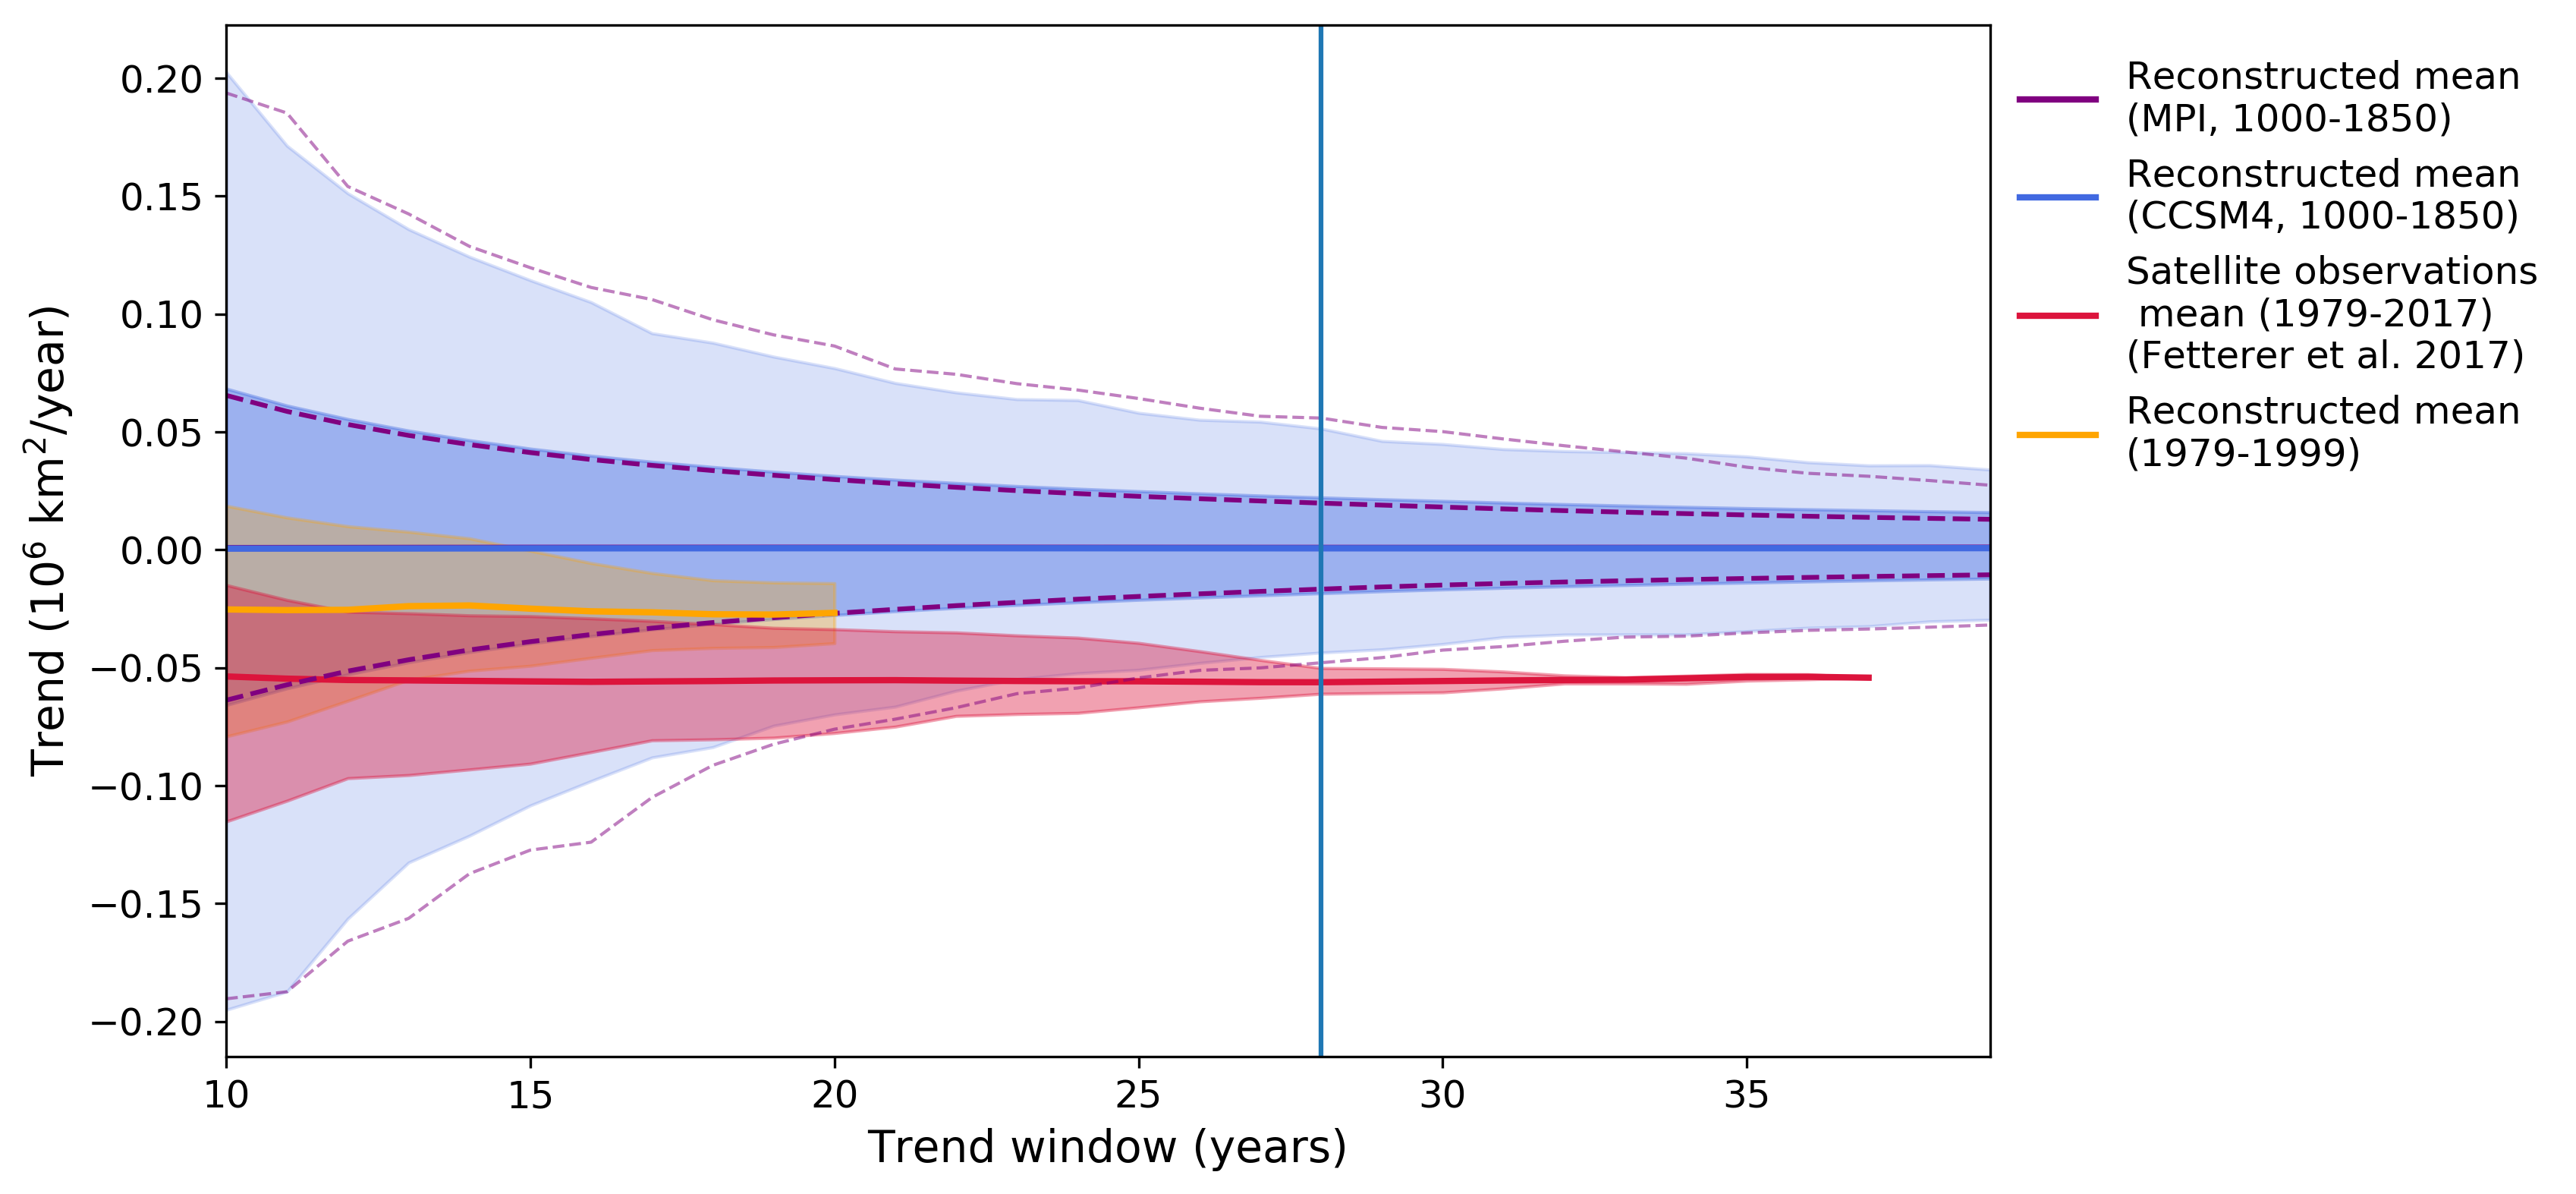

In [31]:
window_prior = np.arange(10,40,1)

plt.figure(figsize=(10,6))

plt.plot(window_prior, pre_mpi_slope_mean,linewidth=2, color='purple', 
         label='Reconstructed mean \n(MPI, 1000-1850)')
# plt.plot(window_prior, prior_ccsm4_slope_mean,linewidth=2, color='g', 
#          label='CCSM4 LM mean \n(1000-1850)')

plt.plot(window_pre, pre_slope_mean,linewidth=2, color='royalblue', 
         label='Reconstructed mean \n(CCSM4, 1000-1850)')
plt.plot(window, sat_slope_mean,linewidth=2, color='crimson', 
         label='Satellite observations\n mean (1979-2017) \n(Fetterer et al. 2017)')
# plt.plot(window_post,post_slope_mean,linewidth=2, color='navy', 
#          label='Satellite observations\n mean (1979-2017) \n(Fetterer et al. 2017)')

plt.plot(window_prior, pre_mpi_slope_p2_5,linewidth=1.5,linestyle = '--', color='purple')
plt.plot(window_prior, pre_mpi_slope_p97_5,linewidth=1.5,linestyle = '--', color='purple')

# plt.plot(window_prior, prior_mpi_slope_p2_5,linewidth=1.5,linestyle = '--', color='purple', 
#          label='MPI LM 95 % confidence \ninterval (1000-1850)')
# plt.plot(window_prior, prior_mpi_slope_p97_5,linewidth=1.5,linestyle = '--', color='purple')
# plt.plot(window_prior, prior_ccsm4_slope_p97_5,linewidth=1.5,linestyle = '--', color='c', 
#          label='CCSM4 LM 95 % confidence \ninterval (1000-1850)')
# plt.plot(window_prior, prior_ccsm4_slope_p2_5,linewidth=1.5, linestyle = '--',color='c')

plt.plot(window_prior, pre_mpi_slope_min,linewidth=1,linestyle = '--', color='purple', alpha=0.5)
plt.plot(window_prior, pre_mpi_slope_max,linewidth=1,linestyle = '--', color='purple', alpha=0.5)

plt.plot(window_sat_recon, sat_recon_slope_mean,linewidth=2, color='orange', 
         label='Reconstructed mean \n(CCSM4, 1979-1999)')

# plt.plot(window_prior, prior_mpi_slope_min,linewidth=1,linestyle = '--', color='purple', alpha=0.5)
# plt.plot(window_prior, prior_mpi_slope_max,linewidth=1,linestyle = '--', color='purple', alpha=0.5)
# plt.plot(window_prior, prior_ccsm4_slope_min,linewidth=1,linestyle = '--', color='c', alpha=0.5)
# plt.plot(window_prior, prior_ccsm4_slope_max,linewidth=1, linestyle = '--',color='c', alpha=0.5)

plt.fill_between(window_pre,pre_slope_min, pre_slope_max, color='royalblue', alpha=0.2)
# #plt.fill_between(window_sat_recon,sat_recon_slope_min, sat_recon_slope_max, color='m', alpha=0.2)
# #plt.fill_between(window,sat_slope_min, sat_slope_max, color='crimson', alpha=0.2)

plt.fill_between(window_pre,pre_slope_p2_5, pre_slope_p97_5, color='royalblue', 
                 alpha=0.4)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window_sat_recon,sat_recon_slope_p2_5, sat_recon_slope_p97_5,
                 color='orange', alpha=0.3)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window,sat_slope_p2_5, sat_slope_p97_5, color='crimson', 
                 alpha=0.4)#,label='2.5th and 97.5th \npercentiles')
# plt.fill_between(window,sat_slope_p2_5, sat_slope_p97_5, color='navy', 
#                  alpha=0.4)#,label='2.5th and 97.5th \npercentiles')

# plt.plot(window_pre,pre_slope_p5,color='royalblue', linestyle='--', linewidth=1.5)
# plt.plot(window_pre,pre_slope_p95,color='royalblue', linestyle='--', linewidth=1.5)
# plt.plot(window_sat_recon,sat_recon_slope_p5,color='salmon', linestyle='--', linewidth=1.5)
# plt.plot(window_sat_recon,sat_recon_slope_p95,color='salmon', linestyle='--', linewidth=1.5)
# plt.plot(window,sat_slope_p5,color='crimson', linestyle='--', linewidth=1.5)
# plt.plot(window,sat_slope_p95,color='crimson', linestyle='--', linewidth=1.5)

plt.xlabel('Trend window (years)', fontsize=14)
plt.ylabel('Trend (10$^6$ km$^2$/year)', fontsize=14)

plt.legend(fontsize=12, bbox_to_anchor=(0.83, 0.5, 0.5, 0.5), frameon=False)
plt.xticks(np.arange(10,40,5))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(10, 39)
#plt.ylim(-0.15,0.15)

plt.axvline(28)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Window_trends_15_38_ccsm4_mpi_scrambled.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

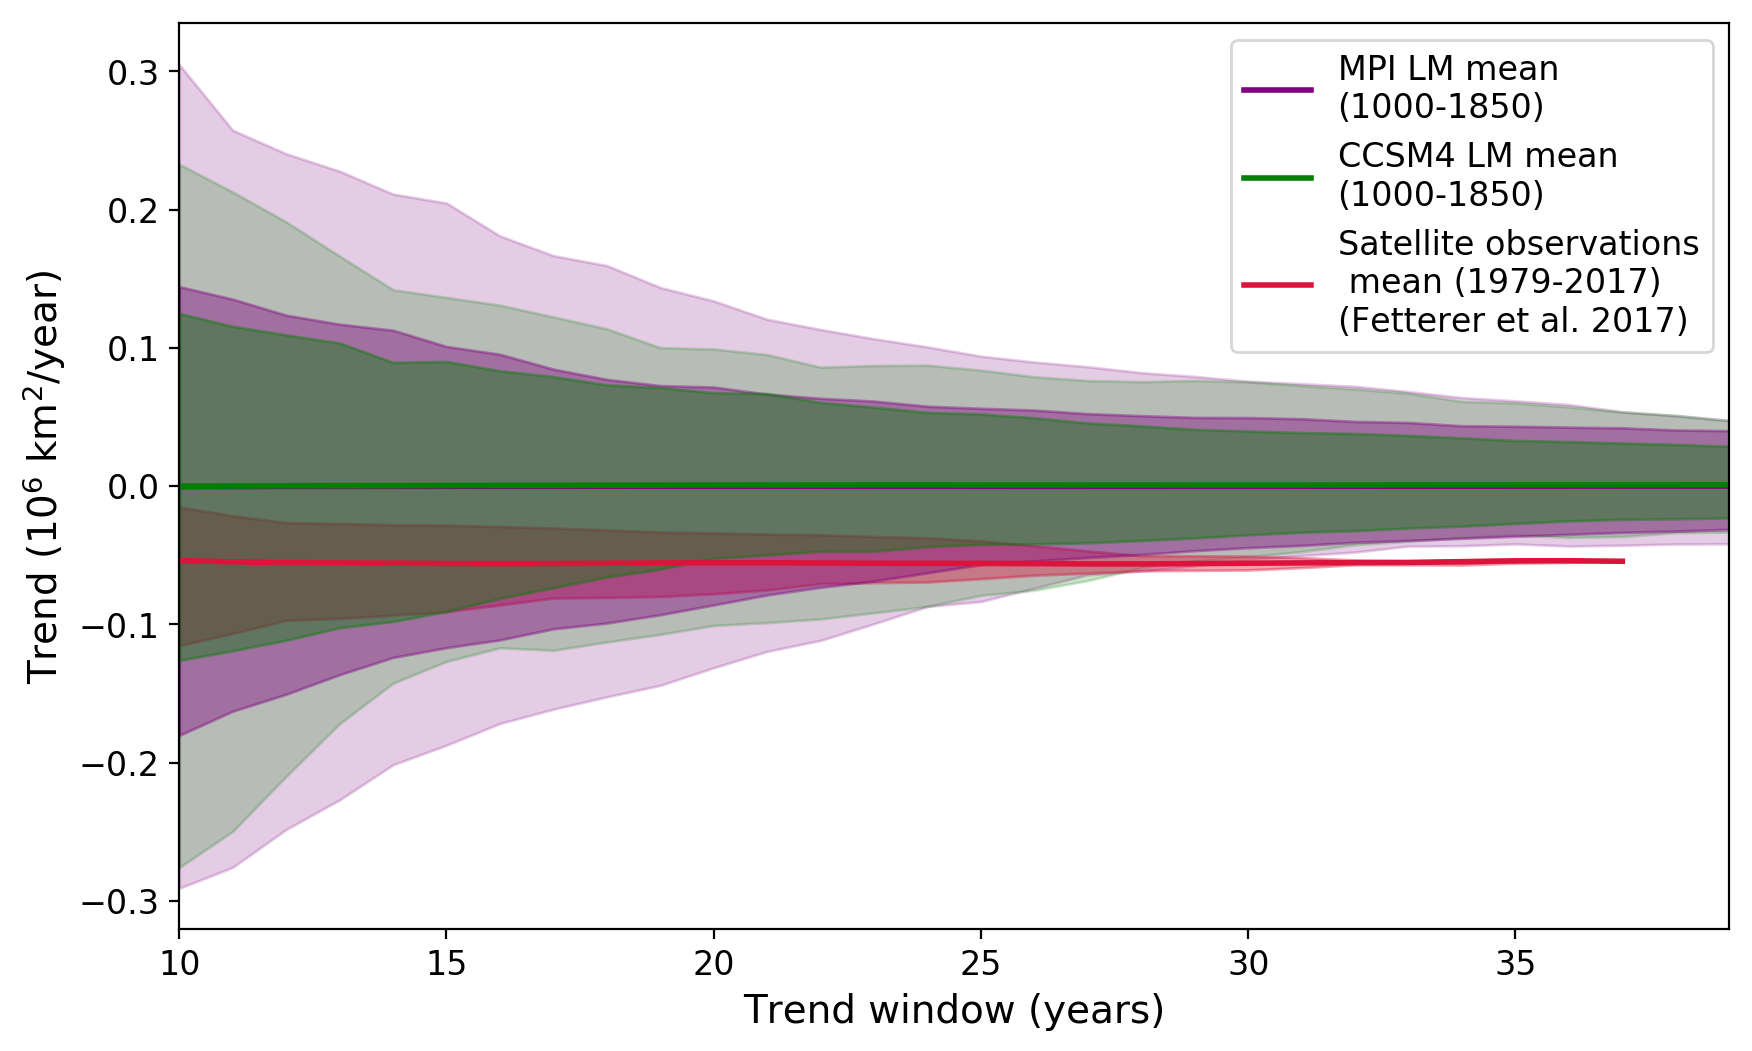

In [49]:
plt.figure(figsize=(10,6))

plt.plot(window_prior, prior_mpi_slope_mean,linewidth=2, color='purple', 
         label='MPI LM mean \n(1000-1850)')
plt.plot(window_prior, prior_ccsm4_slope_mean,linewidth=2, color='g', 
         label='CCSM4 LM mean \n(1000-1850)')

# plt.plot(window_pre, pre_slope_mean,linewidth=2, color='royalblue', 
#          label='Reconstructed mean \n(1000-1850)')
# plt.plot(window_sat_recon, sat_recon_slope_mean,linewidth=2, color='cyan', 
#          label='Reconstructed mean \n(1979-1999)')
plt.plot(window, sat_slope_mean,linewidth=2, color='crimson', 
         label='Satellite observations\n mean (1979-2017) \n(Fetterer et al. 2017)')
# plt.plot(window_post,post_slope_mean,linewidth=2, color='navy', 
#          label='Satellite observations\n mean (1979-2017) \n(Fetterer et al. 2017)')

# plt.fill_between(window_pre,pre_slope_min, pre_slope_max, color='royalblue', alpha=0.2)
# #plt.fill_between(window_sat_recon,sat_recon_slope_min, sat_recon_slope_max, color='m', alpha=0.2)
# #plt.fill_between(window,sat_slope_min, sat_slope_max, color='crimson', alpha=0.2)
plt.fill_between(window_prior,prior_mpi_slope_min, prior_mpi_slope_max, color='purple', alpha=0.2)
plt.fill_between(window_prior,prior_ccsm4_slope_min, prior_ccsm4_slope_max, color='g', alpha=0.2)

# plt.fill_between(window_pre,pre_slope_p2_5, pre_slope_p97_5, color='royalblue', 
#                  alpha=0.4)#, label='2.5th and 97.5th \npercentiles')
# plt.fill_between(window_sat_recon,sat_recon_slope_p2_5, sat_recon_slope_p97_5,
#                  color='c', alpha=0.3)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window,sat_slope_p2_5, sat_slope_p97_5, color='crimson', 
                 alpha=0.4)#,label='2.5th and 97.5th \npercentiles')
# plt.fill_between(window,sat_slope_p2_5, sat_slope_p97_5, color='navy', 
#                  alpha=0.4)#,label='2.5th and 97.5th \npercentiles')

plt.fill_between(window_prior,prior_mpi_slope_p2_5, prior_mpi_slope_p97_5, color='purple', 
                 alpha=0.4)#,label='2.5th and 97.5th \npercentiles')
plt.fill_between(window_prior,prior_ccsm4_slope_p2_5, prior_ccsm4_slope_p97_5, color='g', 
                 alpha=0.4)#,label='2.5th and 97.5th \npercentiles')

# plt.plot(window_pre,pre_slope_p5,color='royalblue', linestyle='--', linewidth=1.5)
# plt.plot(window_pre,pre_slope_p95,color='royalblue', linestyle='--', linewidth=1.5)
# plt.plot(window_sat_recon,sat_recon_slope_p5,color='salmon', linestyle='--', linewidth=1.5)
# plt.plot(window_sat_recon,sat_recon_slope_p95,color='salmon', linestyle='--', linewidth=1.5)
# plt.plot(window,sat_slope_p5,color='crimson', linestyle='--', linewidth=1.5)
# plt.plot(window,sat_slope_p95,color='crimson', linestyle='--', linewidth=1.5)

plt.xlabel('Trend window (years)', fontsize=14)
plt.ylabel('Trend (10$^6$ km$^2$/year)', fontsize=14)

plt.legend(fontsize=12)
plt.xticks(np.arange(10,40,5))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(10, 39)
#plt.ylim(-0.15,0.15)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Window_trends_15_38_ccsm4_mpi_prior.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## Estimating internal variability: 
### Detrended standard deviation: 

In [33]:
pre_ind = (np.array(recon_years_ccsm4)>=1000)&((np.array(recon_years_ccsm4)<1850))
post_ind = (np.array(recon_years_ccsm4)>=1850)&((np.array(recon_years_ccsm4)<1979))
sat_ind = (np.array(recon_years_ccsm4)>=1979)&((np.array(recon_years_ccsm4)<2000))

pre_ind_f400 = (np.array(recon_years_f400)>=1600)&((np.array(recon_years_f400)<1850))
post_ind_f400 = (np.array(recon_years_f400)>=1850)&((np.array(recon_years_f400)<1979))
sat_ind_f400 = (np.array(recon_years_f400)>=1979)&((np.array(recon_years_f400)<2000))

pre_sie_allits_ccsm4_2d = sie_ens_allit_ccsm4_2d[pre_ind,:]
post_sie_allits_ccsm4_2d = sie_ens_allit_ccsm4_2d[post_ind,:]
sat_sie_allits_ccsm4_2d = sie_ens_allit_ccsm4_2d[sat_ind,:]

pre_sie_allits_f400_2d = sie_ens_allit_2d_f400[pre_ind_f400,:]
post_sie_allits_f400_2d = sie_ens_allit_2d_f400[post_ind_f400,:]
sat_sie_allits_f400_2d = sie_ens_allit_2d_f400[sat_ind_f400,:]

In [34]:
sat_sie_allits_ccsm4_2d_dt = signal.detrend(sat_sie_allits_ccsm4_2d,axis=0)
pre_sie_allits_ccsm4_2d_dt = signal.detrend(pre_sie_allits_ccsm4_2d,axis=0)
post_sie_allits_ccsm4_2d_dt = signal.detrend(post_sie_allits_ccsm4_2d,axis=0)

sat_sie_allits_f400_2d_dt = signal.detrend(sat_sie_allits_f400_2d,axis=0)
pre_sie_allits_f400_2d_dt = signal.detrend(pre_sie_allits_f400_2d,axis=0)
post_sie_allits_f400_2d_dt = signal.detrend(post_sie_allits_f400_2d,axis=0)

sat_sie_dt = signal.detrend(fet_sie_anom,axis=0)

In [35]:
sat_recon_std_dt = np.mean(np.std(sat_sie_allits_ccsm4_2d_dt,axis=0))
pre_recon_std_dt = np.mean(np.std(pre_sie_allits_ccsm4_2d_dt,axis=0))
post_recon_std_dt = np.mean(np.std(post_sie_allits_ccsm4_2d_dt,axis=0))

sat_recon_f400_std_dt = np.mean(np.std(sat_sie_allits_f400_2d_dt,axis=0))
pre_recon_f400_std_dt = np.mean(np.std(pre_sie_allits_f400_2d_dt,axis=0))
post_recon_f400_std_dt = np.mean(np.std(post_sie_allits_f400_2d_dt,axis=0))

sat_std_dt = np.std(sat_sie_dt,axis=0)

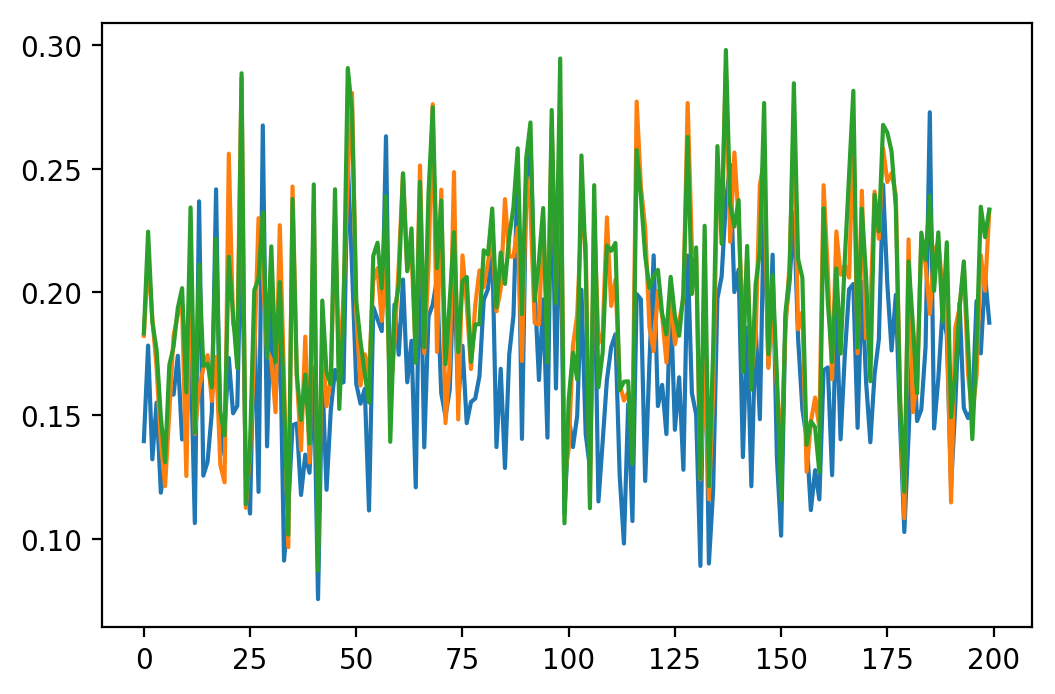

In [107]:
plt.plot(np.std(sat_sie_allits_f400_2d_dt,axis=0))
plt.plot(np.std(pre_sie_allits_f400_2d_dt,axis=0))
plt.plot(np.std(post_sie_allits_f400_2d_dt,axis=0))

In [36]:
print('Standard deviation:')
print('Full recons: ')
print('pre-industrial recon  = '+str(pre_recon_std_dt))
print('post-industrial recon = '+str(post_recon_std_dt))
print('satellite recon       = '+str(sat_recon_std_dt))
print('satellite record      = '+str(sat_std_dt))

print('f400 recons: ')
print('pre-industrial recon  = '+str(pre_recon_f400_std_dt))
print('post-industrial recon = '+str(post_recon_f400_std_dt))
print('satellite recon       = '+str(sat_recon_f400_std_dt))
print('satellite record      = '+str(sat_std_dt))

Standard deviation:
Full recons: 
pre-industrial recon  = 0.24749609927332425
post-industrial recon = 0.2853688489548803
satellite recon       = 0.20792143551073672
satellite record      = 0.21439089024871738
f400 recons: 
pre-industrial recon  = 0.19353368110410707
post-industrial recon = 0.19844863523855985
satellite recon       = 0.1674609542045905
satellite record      = 0.21439089024871738


In [ ]:
stats.ftest()

Text(0.5,1,'Full recon')

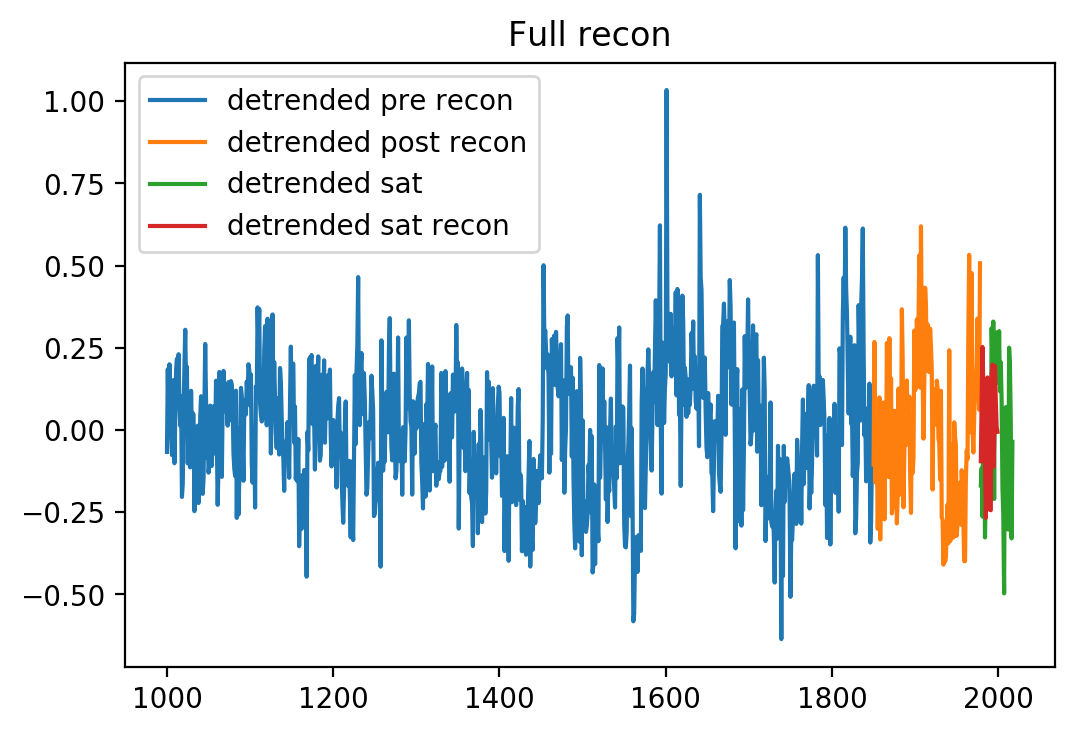

In [37]:
plt.plot(np.array(recon_years_ccsm4)[pre_ind],np.mean(pre_sie_allits_ccsm4_2d_dt,axis=1),
         label='detrended pre recon')
plt.plot(np.array(recon_years_ccsm4)[post_ind],np.mean(post_sie_allits_ccsm4_2d_dt,axis=1),
         label='detrended post recon')
plt.plot(fet_time,sat_sie_dt, label='detrended sat')
plt.plot(np.array(recon_years_ccsm4)[sat_ind],np.mean(sat_sie_allits_ccsm4_2d_dt,axis=1),
         label='detrended sat recon')
plt.legend()
plt.title('Full recon')

Text(0.5,1,'f400')

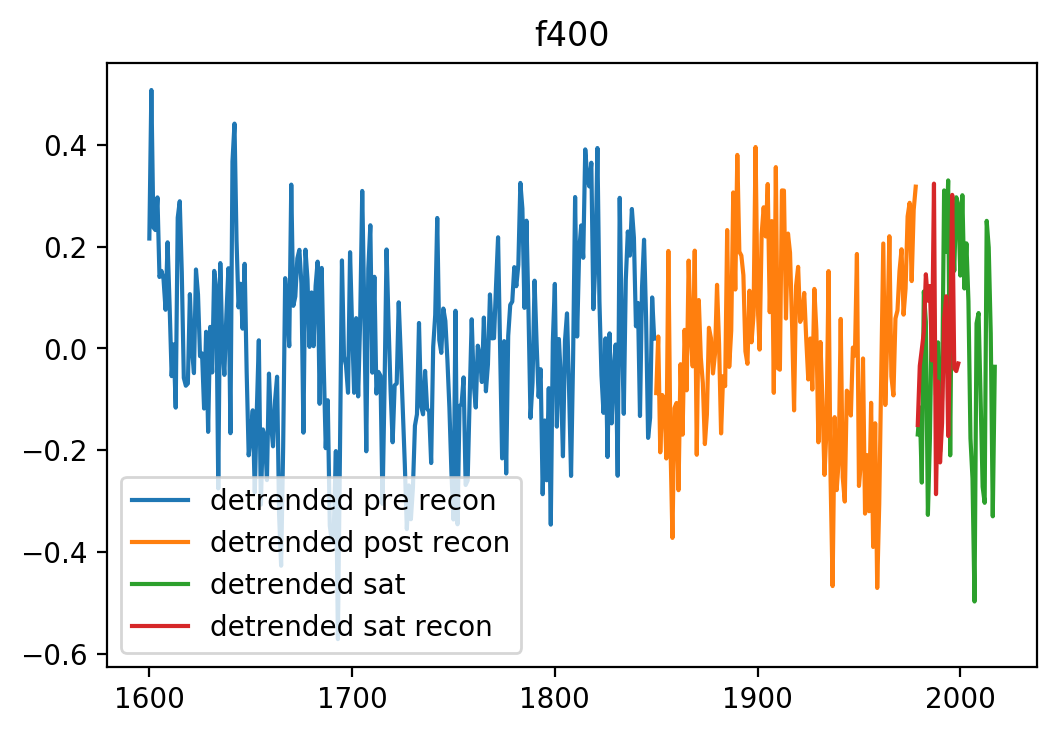

In [38]:
plt.plot(np.array(recon_years_f400)[pre_ind_f400],np.mean(pre_sie_allits_f400_2d_dt,axis=1),
         label='detrended pre recon')
plt.plot(np.array(recon_years_f400)[post_ind_f400],np.mean(post_sie_allits_f400_2d_dt,axis=1),
         label='detrended post recon')
plt.plot(fet_time,sat_sie_dt, label='detrended sat')
plt.plot(np.array(recon_years_f400)[sat_ind_f400],np.mean(sat_sie_allits_f400_2d_dt,axis=1), 
         label='detrended sat recon')
plt.legend(loc='lower left')
plt.title('f400')

In [100]:
np.std(sat_sie_allits_f400_2d_dt,axis=0).shape, np.std(pre_sie_allits_f400_2d_dt,axis=0).shape

((200,), (200,))

In [103]:
print('T-test results: full pre/post')
stat, p = stats.ttest_ind(np.std(sat_sie_allits_f400_2d_dt,axis=0), np.std(pre_sie_allits_f400_2d_dt,axis=0))
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('Sat mean = '+str(np.mean(np.std(sat_sie_allits_f400_2d_dt,axis=0))))
print('Pre mean = '+str(np.mean(np.std(pre_sie_allits_f400_2d_dt,axis=0))))

T-test results: full pre/post
Different distributions (reject null)
Sat mean = 0.1674609542045905
Pre mean = 0.19353368110410707


### Randomly sample 20 year periods from each period to detrend: 

This may be artificially inflating the variance of earlier time periods simply because we're sampling a longer time period and detrending it. Its harder to pull out trends of a longer timeseries compared to a short one. 

In [39]:
import random as rd

In [40]:
def rand_samp_std(nsamp,timeseries, tsize1=False):
    std = np.zeros(nsamp)
    
    if tsize1 is True: 
        for i in range(nsamp):
            it = rd.randint(0,timeseries.shape[0]-20)
            std[i] = np.std(signal.detrend(timeseries[it:it+20]))
    else:
        for i in range(nsamp):
            iens = rd.randint(0,timeseries.shape[1]-20)
            it = rd.randint(0,timeseries.shape[0]-20)
            std[i] = np.std(signal.detrend(timeseries[it:it+20,iens],axis=0))
        
    return std

In [162]:
pre_recon_std_f400_dt_rand = rand_samp_std(1000,pre_sie_allits_f400_2d)
post_recon_std_f400_dt_rand = rand_samp_std(1000,post_sie_allits_f400_2d)

pre_recon_std_full_dt_rand = rand_samp_std(1000,pre_sie_allits_ccsm4_2d)
post_recon_std_full_dt_rand = rand_samp_std(1000,post_sie_allits_ccsm4_2d)

sat_std_dt_rand = rand_samp_std(1000,fet_sie_anom,tsize1=True)

In [163]:
print('Standard deviation, of randomly sampled 20-year periods:')
print('Full recons: ')
print('pre-industrial recon  = '+str(np.mean(pre_recon_std_full_dt_rand)))
print('post-industrial recon = '+str(np.mean(post_recon_std_full_dt_rand)))
print('satellite recon       = '+str(sat_recon_std_dt))
print('satellite record      = '+str(np.mean(sat_std_dt_rand))+'\n')

print('f400 recons: ')
print('pre-industrial recon  = '+str(np.mean(pre_recon_std_f400_dt_rand)))
print('post-industrial recon = '+str(np.mean(post_recon_std_f400_dt_rand)))
print('satellite recon       = '+str(sat_recon_f400_std_dt))
print('satellite record      = '+str(np.mean(sat_std_dt_rand))+'\n')

print('satellite record full = '+str(sat_std_dt))

Standard deviation, of randomly sampled 20-year periods:
Full recons: 
pre-industrial recon  = 0.1803840760441883
post-industrial recon = 0.21568611809595814
satellite recon       = 0.20792143551073672
satellite record      = 0.18741817924337642

f400 recons: 
pre-industrial recon  = 0.15498094459628908
post-industrial recon = 0.1503564065798579
satellite recon       = 0.1674609542045905
satellite record      = 0.18741817924337642

satellite record full = 0.21439089024871738


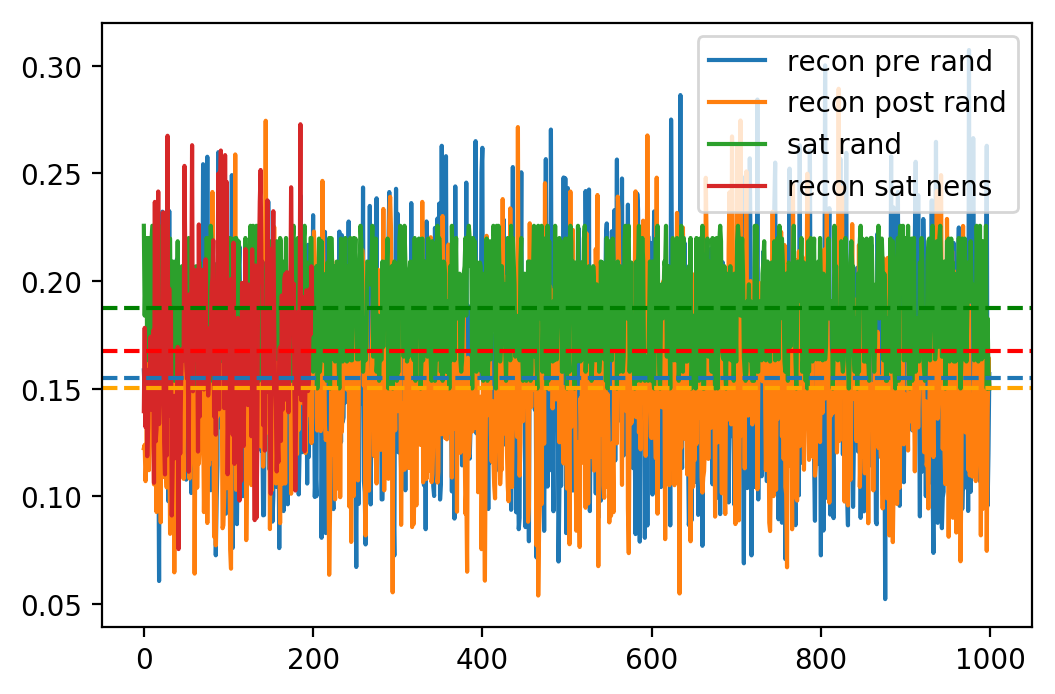

In [164]:
plt.plot(pre_recon_std_f400_dt_rand, label='recon pre rand')
plt.plot(post_recon_std_f400_dt_rand, label='recon post rand')
plt.plot(sat_std_dt_rand, label='sat rand')
plt.plot(np.std(sat_sie_allits_f400_2d_dt,axis=0), label='recon sat nens')

plt.axhline(np.mean(pre_recon_std_f400_dt_rand),linestyle='--')
plt.axhline(np.mean(post_recon_std_f400_dt_rand),linestyle='--', color='orange')
plt.axhline(np.mean(sat_std_dt_rand),linestyle='--', color='g')
plt.axhline(np.mean(np.std(sat_sie_allits_f400_2d_dt,axis=0)),linestyle='--', color='r')

plt.legend()

In [165]:
def ttest_kb(var1,var2):
    size1 = var1.shape[0]
    size2 = var2.shape[0]
    
    variance1 = np.var(var1)
    variance2 = np.var(var2)
    df = size1+size2-2
    
    sigma = np.sqrt((size1*variance1+size2*variance2)/(df))
    
    top = var1.mean()-var2.mean()
    bottom = sigma*np.sqrt((1/size1)+(1/size2))
    
    tstat = top/bottom
    
    return tstat, df

In [179]:
tstat, df = ttest_kb(np.std(sat_sie_allits_f400_2d_dt,axis=0), np.std(sat_sie_allits_f400_2d_dt,axis=0))
p = (1-stats.t.cdf(np.abs(tstat),df=df))*2
alpha=0.05 

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
p, df

Same distributions (Fail to reject null)


(1.0, 398)

In [180]:
tstat, df = ttest_kb(pre_recon_std_f400_dt_rand, np.std(sat_sie_allits_f400_2d_dt,axis=0))
p = (1-stats.t.cdf(tstat,df=df))*2
alpha=0.05 

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
p, df

Same distributions (Fail to reject null)


(1.9998118768208848, 1198)

In [181]:
tstat, df = ttest_kb(pre_recon_std_f400_dt_rand, post_recon_std_f400_dt_rand)
p = (1-stats.t.cdf(np.abs(tstat),df=df))*2
alpha=0.05 

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
p, df

Different distributions (reject null)


(0.013549484330679817, 1998)

In [178]:
tstat, df = ttest_kb(pre_recon_std_f400_dt_rand, sat_std_dt_rand)
p = (1-stats.t.cdf(np.abs(tstat),df=df))*2
alpha=0.05 

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
p, df, tstat

Different distributions (reject null)


(0.0, 1998, -20.42895245342632)

In [167]:
print('T-test results: f400 pre/post')
stat, p = stats.ttest_ind(pre_recon_std_f400_dt_rand, post_recon_std_f400_dt_rand,equal_var = False)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('pre rand  = '+str(np.mean(pre_recon_std_f400_dt_rand)))
print('post rand = '+str(np.mean(post_recon_std_f400_dt_rand)))
p

T-test results: f400 pre/post
Different distributions (reject null)
pre rand  = 0.15498094459628908
post rand = 0.1503564065798579


0.013550176185681082

In [168]:
print('T-test results: f400 sat recon/sat obs')
stat, p = stats.ttest_ind(sat_std_dt_rand, np.std(sat_sie_allits_f400_2d_dt,axis=0),equal_var = False)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('Sat mean rand       = '+str(np.mean(sat_std_dt_rand)))
print('Sat recon nens mean = '+str(np.mean(np.std(sat_sie_allits_f400_2d_dt,axis=0))))
p

T-test results: f400 sat recon/sat obs
Different distributions (reject null)
Sat mean rand       = 0.18741817924337642
Sat recon nens mean = 0.1674609542045905


4.441119388515478e-11

In [172]:
print('T-test results: f400 pre/sat recon')
stat, p = stats.ttest_ind(pre_recon_std_f400_dt_rand, np.std(sat_sie_allits_f400_2d_dt,axis=0),equal_var = False)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('pre mean rand       = '+str(np.mean(pre_recon_std_f400_dt_rand)))
print('Sat recon nens mean = '+str(np.mean(np.std(sat_sie_allits_f400_2d_dt,axis=0))))
p

T-test results: f400 pre/sat recon
Different distributions (reject null)
pre mean rand       = 0.15498094459628908
Sat recon nens mean = 0.1674609542045905


7.243781334588555e-05

In [94]:
print('T-test results: full pre/post')
stat, p = stats.ttest_ind(post_recon_std_full_dt_rand, pre_recon_std_full_dt_rand)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('post mean = '+str(np.mean(post_recon_std_full_dt_rand)))
print('Pre  mean = '+str(np.mean(pre_recon_std_full_dt_rand)))

T-test results: full pre/post
Different distributions (reject null)
post mean = 0.21571718407466842
Pre  mean = 0.1833551566442261


In [93]:
print('T-test results: full pre/sat obs')
stat, p = stats.ttest_ind(sat_std_dt_rand, pre_recon_std_full_dt_rand)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')
    
print('Sat mean = '+str(np.mean(sat_std_dt_rand)))
print('Pre mean = '+str(np.mean(pre_recon_std_full_dt_rand)))

T-test results: full pre/sat obs
Different distributions (reject null)
Sat mean = 0.18799719192577033
Pre mean = 0.1833551566442261


In [71]:
print('F-test results: full pre/post')
F = post_recon_std_full_dt_rand**2/pre_recon_std_full_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: full pre/post
31.89% of random samples indicate population variance is not equal


In [80]:
print('F-test results: full sat/post')
F = sat_std_dt_rand**2/post_recon_std_full_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: full sat/post
5.82% of random samples indicate population variance is not equal


In [84]:
print('F-test results: full sat obs/post')
F = sat_std_dt_rand**2/post_recon_std_full_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: full sat obs/post
5.82% of random samples indicate population variance is not equal


In [85]:
print('F-test results: full sat/post')
F = sat_recon_std_dt**2/pre_recon_std_full_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: full sat/post
27.6% of random samples indicate population variance is not equal


In [95]:
print('T-test results: f400')
stat, p = stats.ttest_ind(pre_recon_std_f400_dt_rand, post_recon_std_f400_dt_rand)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')

print('post mean = '+str(np.mean(post_recon_std_f400_dt_rand)))
print('Pre  mean = '+str(np.mean(pre_recon_std_f400_dt_rand)))

T-test results: f400
Different distributions (reject null)
post mean = 0.150363739778949
Pre  mean = 0.15361507648187567


In [97]:
print('T-test results: f400')
stat, p = stats.ttest_ind(pre_recon_std_f400_dt_rand, sat_std_dt_rand)
alpha = 0.05

if p>alpha:
    print('Same distributions (Fail to reject null)')
else: 
    print('Different distributions (reject null)')

print('Sat mean = '+str(np.mean(sat_std_dt_rand)))
print('Pre mean = '+str(np.mean(pre_recon_std_f400_dt_rand)))

T-test results: f400
Different distributions (reject null)
Sat mean = 0.18799719192577033
Pre mean = 0.15361507648187567


In [75]:
print('F-test results: f400 pre/post')
F = post_recon_std_f400_dt_rand**2/pre_recon_std_f400_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: f400
15.45% of random samples indicate population variance is not equal


In [76]:
print('F-test results: f400 sat/post')
F = sat_recon_f400_std_dt**2/post_recon_std_f400_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: f400 sat/post
18.060000000000002% of random samples indicate population variance is not equal


In [77]:
print('F-test results: f400 sat/pre')
F = sat_recon_f400_std_dt**2/pre_recon_std_f400_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: f400 sat/post
18.77% of random samples indicate population variance is not equal


In [87]:
print('F-test results: f400 sat obs/pre')
F = sat_std_dt_rand**2/pre_recon_std_f400_dt_rand**2
p = np.zeros(F.shape[0])

for i in range(F.shape[0]):
    p[i] = 1-stats.f.cdf(F[i], 19, 19)
    
perc_pass = ((p<=0.05).sum()/p.shape[0])*100
print(str(perc_pass)+'% of random samples indicate population variance is not equal')

F-test results: f400 sat obs/pre
31.180000000000003% of random samples indicate population variance is not equal


In [ ]:
stats.f()